# НУЖНО ЕЩЕ РАЗ ПОПРОБОВАТЬ!!!!!!!!!!!!

# <center> **NLP analysis of jokes dataset**

## Table of Contents

1. **[RNN models](#5)**
	* [Pretrained embedding (word2vec)](#sub-heading)
     + [Dataset loader](#sub-sub-heading-1) 
     + [Split](#sub-sub-heading-2)
     + [RNN](#sub-sub-heading-2)
     + [LSTM](#sub-sub-heading-2)
     + [Bidirectional LSTM](#sub-sub-heading-2)
     + [GRU](#sub-sub-heading-2)
	* [Glove Embedding](#sub-heading)
     + [Dataset loader](#sub-sub-heading-1) 
     + [Split](#sub-sub-heading-2)
     + [RNN](#sub-sub-heading-2)
     + [LSTM](#sub-sub-heading-2)
     + [Bidirectional LSTM](#sub-sub-heading-2)
	* [Make own vocab by train word2vec model](#sub-heading)
     + [Dataset loader](#sub-sub-heading-1) 
     + [Split](#sub-sub-heading-2)
     + [LSTM](#sub-sub-heading-2)




In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 
import warnings
warnings.simplefilter('ignore')

from google.colab import drive
import os
import string

import plotly as py
import numpy as np
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas(desc='PROGRESS>>>')

from google_drive_downloader import GoogleDriveDownloader as gdd
from IPython.core.display import display, HTML

from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold, KFold, cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import label_binarize, StandardScaler

from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

from functools import partial
import re
import gc
import os

import fileinput
import string
import tensorflow as tf
import zipfile
import datetime
import sys
from tqdm  import tqdm
tqdm.pandas()


import io
import requests
import nltk
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from nltk import wordpunct_tokenize
from sklearn.model_selection import train_test_split
import scipy.stats


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.functional as F
from torch.autograd import Variable
import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


# Read data: 

In [3]:
data = pd.read_csv('/content/drive/My Drive/NLP_humor/data/jokes_dataset_MAIN_PREPROC.csv', 
                 sep=',', 
                 encoding='utf-8').set_index('id')

In [4]:
data.head()

joke  rank
id                                                             
5tz52q  I hate how you cannot even say black paint any...     1
5tz4dd  What is the difference between a Jew in Nazi G...     0
5tz319  I recently went to America..... ...and being t...     0
5tz2wj  Brian raises his hand and says, "He is in Heav...     1
5tz1pc  You hear about the University book store worke...     0

In [5]:
data.dropna(inplace=True)

In [6]:
data.isna().sum()

joke    0
rank    0
dtype: int64

In [7]:
data['rank'].value_counts()

0    60139
2    40704
4    38302
3    34199
1    18942
Name: rank, dtype: int64

# **Preprocessing**

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [8]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

data['joke'] = data[['joke']].applymap(lambda x: " ".join(tokenizer.tokenize(x.lower())))

Now we can assume that our text is a space-separated list of tokens:

In [9]:
print("Tokenized:")
print(data["joke"][2::100000])

Tokenized:
id
5tz319    i recently went to america ..... ... and being...
3kidb9    if you think your job is meaningless . remembe...
Name: joke, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [10]:
from collections import Counter
token_counts = Counter()
# Count how many times does each token occur in both "Title" and "FullDescription" in total


for line in data['joke'].values:
    token_counts.update(line.split(" "))

In [11]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(531000, 532000)
assert len(token_counts) in range(80000, 81000)
print('Correct!')

Total unique tokens : 80705
('the', 531570)
('.', 438871)
(',', 416017)
('a', 334973)
('and', 248355)
...
('uhr', 1)
('pinat', 1)
('ddr', 1)
Correct!


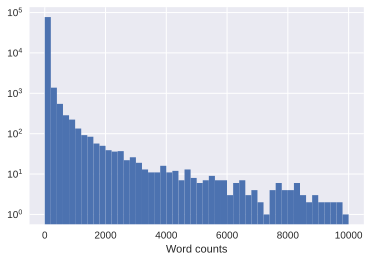

In [12]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

 Get a list of all tokens that occur at least 10 times.

In [13]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [14]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(18000, 21000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 20434
Correct!


 Build an inverse token index: a dictionary from token(string) to it's index in tokens (int)

In [15]:
token_to_id = {t: i for i, t in enumerate(tokens)}

In [16]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [17]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [18]:
print("Lines:")
print('\n'.join(data["joke"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["joke"][::100000]))

Lines:
i hate how you cannot even say black paint anymore . now i have to say " leroy can you please paint the fence ?"
why did the snowman leave his wife ?. because she got plowed by another man .

Matrix:
[[ 9138  8519  9003 20334  3066  6486 15656  2238 12898  1210   309 12348
   9138  8538 18466 15656    67 10507  3034 20334 13594 12898 18222  6923
    464]
 [19961  5387 18222 16734 10439  8787 19979   487  1977 16126  8008 13611
   2933  1173 11025   309     1     1     1     1     1     1     1     1
      1]]


# Split

In [19]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

data_train, data_test = train_test_split(data_train, test_size=0.2, random_state=42)

data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))
print("Test size = ", len(data_test))

Train size =  123062
Validation size =  38458
Test size =  30766


In [20]:
TARGET_COLUMN = 'rank'

In [21]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["joke"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["joke"] = as_matrix(data["joke"].values, max_len)
    
    if word_dropout != 0:
        batch["joke"] = apply_word_dropout(batch["joke"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [22]:
make_batch(data_train[:3], max_len=10)

{'joke': tensor([[19961, 19725,  9876,     0,   588, 18222, 12157,  9659,   487,  1977],
         [19925,   257, 18151,   257,  1110,  2003, 19649,  9594,   552,  1817],
         [18965, 10500,  1326, 13581, 13676,   336, 18222, 12576, 18326,  9281]]),
 'rank': tensor([4, 1, 1])}

In [23]:
BATCH_SIZE = 128
EPOCHS = 10

# Utils

In [24]:
import os

In [25]:
def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    print("Saving model and optimizer state at iteration {} to {}".format(
        iteration, filepath))

    model_state_dict = model.state_dict().copy()

    torch.save({'iteration': iteration,
                'state_dict': model_state_dict,
                'optimizer': optimizer.state_dict(),
                'learning_rate': learning_rate}, filepath)

In [26]:
def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')

    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, optimizer, learning_rate, iteration

In [27]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

In [28]:
def train(model, optimizer, criterion, 
          data_train, data_val, 
          batch_size=128,
          epochs=100, iter_per_validation=50,
          early_stopping=False,
          checkpoint_path="./best_checkpoint",
          save_by="accuracy",
          device=DEVICE,  **kw):
  count = 0
  patience = 5
 
  iteration = 0
  loss_list = []
  iteration_list = []
  accuracy_list = []
  best_score = None


  best_score = None

  for epoch in range(epochs):
      print(f"Epoch {epoch}")

      # for vec, vlen, labels in train_loader:
      for i, batch in tqdm.notebook.tqdm(
                      enumerate(iterate_minibatches(
                                          data_train, 
                                          batch_size=batch_size, 
                                          device=DEVICE)), 
                                          total=len(data_train) // batch_size
                                          ):
          model.train()
          # Clear gradients
          optimizer.zero_grad()
        
          # Forward propagation
          outputs = model(batch)
      
          # Calculate softmax and ross entropy loss
          loss = criterion(outputs,  batch[TARGET_COLUMN])
          
          # Calculating gradients
          loss.backward()
          
          # Update parameters
          optimizer.step()
          
          iteration += 1
          
          if iteration % iter_per_validation == 99:
              model.eval()
              with torch.no_grad():
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Iterate through test dataset
                # for i, batch in tqdm.notebook.tqdm(
                #       enumerate(iterate_minibatches(
                #                           data_val, 
                #                           batch_size=batch_size, 
                #                           device=DEVICE)), 
                #                           total=len(data_val) // batch_size
                #                           ):
                for i, batch in enumerate(iterate_minibatches(
                                        data_val, 
                                        batch_size=batch_size, 
                                        device=DEVICE)):
                    # Forward propagation
                    outputs = model(batch)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]
                    
                    # Total number of labels
                    total += len(batch[TARGET_COLUMN])
                    
                    correct += (predicted == batch[TARGET_COLUMN]).sum()
                
                accuracy = 100 * correct / float(total)
            
                # store loss and iteration
                loss_list.append(loss.data.detach().cpu().numpy())
                iteration_list.append(iteration)
                accuracy_list.append(accuracy.detach().cpu().numpy())
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(iteration, loss.data, accuracy))

                # save if we have best model state
                ref_score = accuracy if save_by == "accuracy" else loss.data
                compare = (lambda x, y: x > y) if save_by == "accuracy" else (lambda x, y: x < y)
                if best_score is None or compare(ref_score, best_score):
                    best_score = ref_score
                    save_checkpoint(model, optimizer, 
                                    optimizer.state_dict()['param_groups'][0]['lr'], 
                                    iteration, checkpoint_path)
                    
                 # Early stopping if the current valid_loss is greater than the last three valid losses
                if  early_stopping == True:
                    if len(accuracy_list) > 3 and all(accuracy >= acc for acc in accuracy_list[-4:]):
                        print('Stopping early')
                        break

  return iteration_list, loss_list, accuracy_list


              
              # # Early stopping if the current valid_loss is greater than the last three valid losses
              # if len(val_loss_array) > 2 and val_loss_array[-1] > val_loss_array[-2] > val_loss_array[-3]:
              #   count +=1 
              #   if count > patience:
              #     print('Early stopping, number of epoch:', epoch)
              #     break


In [29]:
def draw_visualization(iteration_list, loss_list, accuracy_list):
    # visualization loss 
    plt.plot(iteration_list,loss_list)
    plt.xlabel("Number of iteration")
    plt.ylabel("Loss")
    plt.title("Loss vs Number of iteration")
    plt.show()

    # visualization accuracy 
    plt.plot(iteration_list,accuracy_list,color = "red")
    plt.xlabel("Number of iteration")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Number of iteration")
    plt.show()

!ls

%cd /content/drive/My Drive/NLP_humor/

from plot_cm import plot_confusion_matrix
from plot_roc import plot_roc

def calc_metrics(test_label, preds):
    classes_names = ['0', '1', '2', '3', '4']
    num_classes = 5

    plot_confusion_matrix(cm=metrics.confusion_matrix(test_label, preds),
                          target_names=classes_names,
                          normalize=False)
    
    print("Accuracy:",
          round(metrics.accuracy_score(test_label, preds), 5),
        '\nBalanced accuracy:',
        round(metrics.balanced_accuracy_score(test_label, preds), 5), 
        '\nMulticlass f1-score:',
        '\n    micro:', round(metrics.f1_score(test_label, preds, average='micro'), 5),
        '\n    macro:', round(metrics.f1_score(test_label, preds, average='macro'), 5),
        '\n    weighted:', round(metrics.f1_score(test_label, preds, average='weighted'), 5))

    print('\n\nClassification report:\n')
    print(metrics.classification_report(test_label, preds, digits=5))

drive  sample_data
/content/drive/My Drive/NLP_humor


# Models

In [53]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features = self.joke_encoder(joke_embeddings).squeeze()

        return self.final_predictor(joke_features).squeeze()

In [58]:
model_bn = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_bn.parameters(), lr=learning_rate)

In [59]:
iteration_list, loss_list, accuracy_list  = train(model_bn, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_bn_best_checkpoint_v2",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.6177606582641602  Accuracy: 20.60429573059082 %
Saving model and optimizer state at iteration 99 to ./cnn_bn_best_checkpoint_v2
Iteration: 199  Loss: 1.6101988554000854  Accuracy: 22.25284767150879 %
Saving model and optimizer state at iteration 199 to ./cnn_bn_best_checkpoint_v2
Iteration: 299  Loss: 1.6141568422317505  Accuracy: 23.625774383544922 %
Saving model and optimizer state at iteration 299 to ./cnn_bn_best_checkpoint_v2
Iteration: 399  Loss: 1.6001994609832764  Accuracy: 25.908782958984375 %
Saving model and optimizer state at iteration 399 to ./cnn_bn_best_checkpoint_v2
Iteration: 499  Loss: 1.592348575592041  Accuracy: 27.068490982055664 %
Saving model and optimizer state at iteration 499 to ./cnn_bn_best_checkpoint_v2
Iteration: 599  Loss: 1.594573736190796  Accuracy: 28.298402786254883 %
Saving model and optimizer state at iteration 599 to ./cnn_bn_best_checkpoint_v2
Iteration: 699  Loss: 1.5904920101165771  Accuracy: 29.354101181030273 %
Saving mo

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5820198059082031  Accuracy: 31.34328269958496 %
Saving model and optimizer state at iteration 999 to ./cnn_bn_best_checkpoint_v2
Iteration: 1099  Loss: 1.5774760246276855  Accuracy: 31.74372100830078 %
Saving model and optimizer state at iteration 1099 to ./cnn_bn_best_checkpoint_v2
Iteration: 1199  Loss: 1.5820908546447754  Accuracy: 32.003746032714844 %
Saving model and optimizer state at iteration 1199 to ./cnn_bn_best_checkpoint_v2
Iteration: 1299  Loss: 1.581742525100708  Accuracy: 32.15715789794922 %
Saving model and optimizer state at iteration 1299 to ./cnn_bn_best_checkpoint_v2
Iteration: 1399  Loss: 1.5817118883132935  Accuracy: 32.36777877807617 %
Saving model and optimizer state at iteration 1399 to ./cnn_bn_best_checkpoint_v2
Iteration: 1499  Loss: 1.5646129846572876  Accuracy: 32.557594299316406 %
Saving model and optimizer state at iteration 1499 to ./cnn_bn_best_checkpoint_v2
Iteration: 1599  Loss: 1.5688095092773438  Accuracy: 32.5159912109375 %

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5555822849273682  Accuracy: 32.81241989135742 %
Saving model and optimizer state at iteration 1999 to ./cnn_bn_best_checkpoint_v2
Iteration: 2099  Loss: 1.5612655878067017  Accuracy: 32.95283126831055 %
Saving model and optimizer state at iteration 2099 to ./cnn_bn_best_checkpoint_v2
Iteration: 2199  Loss: 1.5732886791229248  Accuracy: 32.91122817993164 %
Iteration: 2299  Loss: 1.559809684753418  Accuracy: 32.820220947265625 %
Iteration: 2399  Loss: 1.5549826622009277  Accuracy: 32.976234436035156 %
Saving model and optimizer state at iteration 2399 to ./cnn_bn_best_checkpoint_v2
Iteration: 2499  Loss: 1.5602058172225952  Accuracy: 32.84882354736328 %
Iteration: 2599  Loss: 1.5496649742126465  Accuracy: 32.908626556396484 %
Iteration: 2699  Loss: 1.5730853080749512  Accuracy: 32.869625091552734 %
Iteration: 2799  Loss: 1.527356743812561  Accuracy: 32.91122817993164 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5550366640090942  Accuracy: 33.0074348449707 %
Saving model and optimizer state at iteration 2899 to ./cnn_bn_best_checkpoint_v2
Iteration: 2999  Loss: 1.5712618827819824  Accuracy: 33.049041748046875 %
Saving model and optimizer state at iteration 2999 to ./cnn_bn_best_checkpoint_v2
Iteration: 3099  Loss: 1.55178701877594  Accuracy: 32.88522720336914 %
Iteration: 3199  Loss: 1.5663094520568848  Accuracy: 33.05424118041992 %
Saving model and optimizer state at iteration 3199 to ./cnn_bn_best_checkpoint_v2
Iteration: 3299  Loss: 1.557215929031372  Accuracy: 33.11924743652344 %
Saving model and optimizer state at iteration 3299 to ./cnn_bn_best_checkpoint_v2
Iteration: 3399  Loss: 1.5536036491394043  Accuracy: 32.97103500366211 %
Iteration: 3499  Loss: 1.556372880935669  Accuracy: 32.9138298034668 %
Iteration: 3599  Loss: 1.5704742670059204  Accuracy: 32.9554328918457 %
Iteration: 3699  Loss: 1.5623091459274292  Accuracy: 32.96843338012695 %
Iteration: 3799  Loss

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.5725256204605103  Accuracy: 32.958030700683594 %
Iteration: 3999  Loss: 1.5765923261642456  Accuracy: 32.872222900390625 %
Iteration: 4099  Loss: 1.5514906644821167  Accuracy: 33.01783752441406 %
Iteration: 4199  Loss: 1.539804220199585  Accuracy: 32.77601623535156 %
Iteration: 4299  Loss: 1.5351834297180176  Accuracy: 33.05684280395508 %
Iteration: 4399  Loss: 1.522162914276123  Accuracy: 33.025638580322266 %
Iteration: 4499  Loss: 1.5969064235687256  Accuracy: 33.098445892333984 %
Iteration: 4599  Loss: 1.6096105575561523  Accuracy: 32.88002395629883 %
Iteration: 4699  Loss: 1.537196159362793  Accuracy: 32.97883224487305 %
Iteration: 4799  Loss: 1.5498126745224  Accuracy: 32.91642761230469 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.5485061407089233  Accuracy: 32.90082550048828 %
Iteration: 4999  Loss: 1.5904531478881836  Accuracy: 32.86182403564453 %
Iteration: 5099  Loss: 1.5826371908187866  Accuracy: 32.88522720336914 %
Iteration: 5199  Loss: 1.5475172996520996  Accuracy: 32.882625579833984 %
Iteration: 5299  Loss: 1.5222752094268799  Accuracy: 32.895626068115234 %
Iteration: 5399  Loss: 1.5293129682540894  Accuracy: 33.02043914794922 %
Iteration: 5499  Loss: 1.540225863456726  Accuracy: 32.94243240356445 %
Iteration: 5599  Loss: 1.5963425636291504  Accuracy: 32.85142135620117 %
Iteration: 5699  Loss: 1.5688754320144653  Accuracy: 32.95022964477539 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.5591027736663818  Accuracy: 32.95022964477539 %
Iteration: 5899  Loss: 1.589274525642395  Accuracy: 32.95283126831055 %
Iteration: 5999  Loss: 1.5347027778625488  Accuracy: 32.91122817993164 %
Iteration: 6099  Loss: 1.5045734643936157  Accuracy: 32.835819244384766 %
Iteration: 6199  Loss: 1.593193531036377  Accuracy: 32.82542037963867 %
Iteration: 6299  Loss: 1.5231980085372925  Accuracy: 32.87482452392578 %
Iteration: 6399  Loss: 1.5075017213821411  Accuracy: 32.9398307800293 %
Iteration: 6499  Loss: 1.5510207414627075  Accuracy: 32.78121566772461 %
Iteration: 6599  Loss: 1.525739073753357  Accuracy: 32.86442184448242 %
Iteration: 6699  Loss: 1.5441917181015015  Accuracy: 32.92683029174805 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.5364439487457275  Accuracy: 32.79421615600586 %
Iteration: 6899  Loss: 1.540820837020874  Accuracy: 33.05944061279297 %
Iteration: 6999  Loss: 1.5830384492874146  Accuracy: 32.87482452392578 %
Iteration: 7099  Loss: 1.5477873086929321  Accuracy: 32.770816802978516 %
Iteration: 7199  Loss: 1.5128519535064697  Accuracy: 32.822818756103516 %
Iteration: 7299  Loss: 1.5806405544281006  Accuracy: 32.770816802978516 %
Iteration: 7399  Loss: 1.570192575454712  Accuracy: 32.7500114440918 %
Iteration: 7499  Loss: 1.5745666027069092  Accuracy: 32.64600372314453 %
Iteration: 7599  Loss: 1.5181388854980469  Accuracy: 32.7578125 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.5415369272232056  Accuracy: 32.94243240356445 %
Iteration: 7799  Loss: 1.5508495569229126  Accuracy: 32.99443435668945 %
Iteration: 7899  Loss: 1.5127840042114258  Accuracy: 32.84362030029297 %
Iteration: 7999  Loss: 1.5486541986465454  Accuracy: 32.84102249145508 %
Iteration: 8099  Loss: 1.570666790008545  Accuracy: 32.770816802978516 %
Iteration: 8199  Loss: 1.515767216682434  Accuracy: 32.9736328125 %
Iteration: 8299  Loss: 1.5296612977981567  Accuracy: 32.90342712402344 %
Iteration: 8399  Loss: 1.5478864908218384  Accuracy: 32.7318115234375 %
Iteration: 8499  Loss: 1.5259215831756592  Accuracy: 32.70840835571289 %
Iteration: 8599  Loss: 1.5328640937805176  Accuracy: 32.79421615600586 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.5627862215042114  Accuracy: 32.80721664428711 %
Iteration: 8799  Loss: 1.5671918392181396  Accuracy: 32.77861404418945 %
Iteration: 8899  Loss: 1.5466316938400269  Accuracy: 32.75521469116211 %
Iteration: 8999  Loss: 1.5262330770492554  Accuracy: 32.87742614746094 %


KeyboardInterrupt: ignored

In [66]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size*4),
            nn.BatchNorm1d(hid_size*4),
            nn.ReLU(),
            nn.Linear(hid_size*4, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features = self.joke_encoder(joke_embeddings).squeeze()

        return self.final_predictor(joke_features).squeeze()

In [67]:
model_bn = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3 # 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_bn.parameters(), lr=learning_rate)

In [68]:
iteration_list, loss_list, accuracy_list  = train(model_bn, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_bn_best_checkpoint_v3",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.536998987197876  Accuracy: 34.44017028808594 %
Saving model and optimizer state at iteration 99 to ./cnn_bn_best_checkpoint_v3
Iteration: 199  Loss: 1.4801908731460571  Accuracy: 33.2154541015625 %
Iteration: 299  Loss: 1.5899180173873901  Accuracy: 32.328773498535156 %
Iteration: 399  Loss: 1.533078670501709  Accuracy: 32.328773498535156 %
Iteration: 499  Loss: 1.512571096420288  Accuracy: 32.13115692138672 %
Iteration: 599  Loss: 1.5335474014282227  Accuracy: 32.62260055541992 %
Iteration: 699  Loss: 1.505590558052063  Accuracy: 32.5419921875 %
Iteration: 799  Loss: 1.6090127229690552  Accuracy: 32.62000274658203 %
Iteration: 899  Loss: 1.5390677452087402  Accuracy: 32.29757308959961 %


KeyboardInterrupt: ignored

In [ ]:
EPOCHS = 3

In [76]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=32):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.GroupNorm(1, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features = self.joke_encoder(joke_embeddings).squeeze()

        return self.final_predictor(joke_features).squeeze()

In [77]:
model_gn = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gn.parameters(), lr=learning_rate)

In [78]:
iteration_list, loss_list, accuracy_list  = train(model_gn, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_gn_best_checkpoint",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5862840414047241  Accuracy: 31.473295211791992 %
Saving model and optimizer state at iteration 99 to ./cnn_gn_best_checkpoint
Iteration: 199  Loss: 1.5092883110046387  Accuracy: 34.18534469604492 %
Saving model and optimizer state at iteration 199 to ./cnn_gn_best_checkpoint
Iteration: 299  Loss: 1.5360513925552368  Accuracy: 34.20094680786133 %
Saving model and optimizer state at iteration 299 to ./cnn_gn_best_checkpoint
Iteration: 399  Loss: 1.4994537830352783  Accuracy: 34.63518524169922 %
Saving model and optimizer state at iteration 399 to ./cnn_gn_best_checkpoint
Iteration: 499  Loss: 1.5308797359466553  Accuracy: 34.081336975097656 %
Iteration: 599  Loss: 1.533619999885559  Accuracy: 34.85100555419922 %
Saving model and optimizer state at iteration 599 to ./cnn_gn_best_checkpoint
Iteration: 699  Loss: 1.5701675415039062  Accuracy: 34.830204010009766 %
Iteration: 799  Loss: 1.528568148612976  Accuracy: 35.168235778808594 %
Saving model and optimizer state a

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5306496620178223  Accuracy: 34.96281814575195 %
Iteration: 1099  Loss: 1.544053077697754  Accuracy: 35.13443374633789 %
Iteration: 1199  Loss: 1.5292924642562866  Accuracy: 35.10322952270508 %
Iteration: 1299  Loss: 1.4959874153137207  Accuracy: 35.11623001098633 %
Iteration: 1399  Loss: 1.519069790840149  Accuracy: 35.16563415527344 %
Iteration: 1499  Loss: 1.5121147632598877  Accuracy: 35.28004455566406 %
Saving model and optimizer state at iteration 1499 to ./cnn_gn_best_checkpoint
Iteration: 1599  Loss: 1.471788763999939  Accuracy: 35.00442123413086 %
Iteration: 1699  Loss: 1.5123685598373413  Accuracy: 35.23324203491211 %
Iteration: 1799  Loss: 1.5299510955810547  Accuracy: 35.42045974731445 %
Saving model and optimizer state at iteration 1799 to ./cnn_gn_best_checkpoint
Iteration: 1899  Loss: 1.557422161102295  Accuracy: 35.04342269897461 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5041122436523438  Accuracy: 35.38925552368164 %
Iteration: 2099  Loss: 1.5410938262939453  Accuracy: 35.35025405883789 %
Iteration: 2199  Loss: 1.5608103275299072  Accuracy: 35.31904983520508 %
Iteration: 2299  Loss: 1.5154839754104614  Accuracy: 35.13443374633789 %
Iteration: 2399  Loss: 1.513584017753601  Accuracy: 35.4334602355957 %
Saving model and optimizer state at iteration 2399 to ./cnn_gn_best_checkpoint
Iteration: 2499  Loss: 1.50135338306427  Accuracy: 35.58687210083008 %
Saving model and optimizer state at iteration 2499 to ./cnn_gn_best_checkpoint
Iteration: 2599  Loss: 1.462985634803772  Accuracy: 35.49846649169922 %
Iteration: 2699  Loss: 1.5906715393066406  Accuracy: 35.06422424316406 %
Iteration: 2799  Loss: 1.5146400928497314  Accuracy: 35.45166015625 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.4427754878997803  Accuracy: 35.04082489013672 %
Iteration: 2999  Loss: 1.552565097808838  Accuracy: 34.72879409790039 %
Iteration: 3099  Loss: 1.5063080787658691  Accuracy: 35.386653900146484 %
Iteration: 3199  Loss: 1.5226160287857056  Accuracy: 35.11623001098633 %
Iteration: 3299  Loss: 1.512143611907959  Accuracy: 35.17083740234375 %
Iteration: 3399  Loss: 1.5328871011734009  Accuracy: 35.360652923583984 %
Iteration: 3499  Loss: 1.4800037145614624  Accuracy: 35.553070068359375 %
Iteration: 3599  Loss: 1.5331182479858398  Accuracy: 35.51926803588867 %
Iteration: 3699  Loss: 1.470044493675232  Accuracy: 35.693485260009766 %
Saving model and optimizer state at iteration 3699 to ./cnn_gn_best_checkpoint
Iteration: 3799  Loss: 1.5112948417663574  Accuracy: 35.399658203125 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.530747413635254  Accuracy: 35.53746795654297 %
Iteration: 3999  Loss: 1.4661760330200195  Accuracy: 35.50106430053711 %
Iteration: 4099  Loss: 1.4544090032577515  Accuracy: 35.07462692260742 %
Iteration: 4199  Loss: 1.5113775730133057  Accuracy: 35.334651947021484 %
Iteration: 4299  Loss: 1.521353840827942  Accuracy: 35.35805130004883 %
Iteration: 4399  Loss: 1.5762624740600586  Accuracy: 34.46356964111328 %
Iteration: 4499  Loss: 1.475653052330017  Accuracy: 34.710594177246094 %
Iteration: 4599  Loss: 1.4596208333969116  Accuracy: 35.79749298095703 %
Saving model and optimizer state at iteration 4599 to ./cnn_gn_best_checkpoint
Iteration: 4699  Loss: 1.5062373876571655  Accuracy: 35.97690963745117 %
Saving model and optimizer state at iteration 4699 to ./cnn_gn_best_checkpoint
Iteration: 4799  Loss: 1.5277049541473389  Accuracy: 35.50886535644531 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.4638723134994507  Accuracy: 35.566070556640625 %
Iteration: 4999  Loss: 1.5099881887435913  Accuracy: 35.99251174926758 %
Saving model and optimizer state at iteration 4999 to ./cnn_gn_best_checkpoint
Iteration: 5099  Loss: 1.4573568105697632  Accuracy: 35.15003204345703 %
Iteration: 5199  Loss: 1.5390785932540894  Accuracy: 35.97951126098633 %
Iteration: 5299  Loss: 1.542214035987854  Accuracy: 36.18232727050781 %
Saving model and optimizer state at iteration 5299 to ./cnn_gn_best_checkpoint
Iteration: 5399  Loss: 1.5349912643432617  Accuracy: 36.00551223754883 %
Iteration: 5499  Loss: 1.4960943460464478  Accuracy: 35.589473724365234 %
Iteration: 5599  Loss: 1.5216848850250244  Accuracy: 35.75328826904297 %
Iteration: 5699  Loss: 1.5160284042358398  Accuracy: 35.974308013916016 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.4628095626831055  Accuracy: 35.742889404296875 %
Iteration: 5899  Loss: 1.4998204708099365  Accuracy: 35.92750549316406 %
Iteration: 5999  Loss: 1.454928994178772  Accuracy: 36.25253677368164 %
Saving model and optimizer state at iteration 5999 to ./cnn_gn_best_checkpoint
Iteration: 6099  Loss: 1.4743977785110474  Accuracy: 35.33985137939453 %
Iteration: 6199  Loss: 1.5879017114639282  Accuracy: 36.18492889404297 %
Iteration: 6299  Loss: 1.4607322216033936  Accuracy: 35.566070556640625 %
Iteration: 6399  Loss: 1.4906361103057861  Accuracy: 36.00031280517578 %
Iteration: 6499  Loss: 1.4755594730377197  Accuracy: 35.74808883666992 %
Iteration: 6599  Loss: 1.5179784297943115  Accuracy: 35.974308013916016 %
Iteration: 6699  Loss: 1.476621150970459  Accuracy: 35.21503829956055 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.5874184370040894  Accuracy: 36.08612060546875 %
Iteration: 6899  Loss: 1.503522515296936  Accuracy: 35.77408981323242 %
Iteration: 6999  Loss: 1.4979276657104492  Accuracy: 35.80789566040039 %
Iteration: 7099  Loss: 1.5191266536712646  Accuracy: 35.924903869628906 %
Iteration: 7199  Loss: 1.4500006437301636  Accuracy: 34.59618377685547 %
Iteration: 7299  Loss: 1.4870036840438843  Accuracy: 36.236934661865234 %
Iteration: 7399  Loss: 1.4696533679962158  Accuracy: 35.397056579589844 %
Iteration: 7499  Loss: 1.4548215866088867  Accuracy: 35.25664520263672 %
Iteration: 7599  Loss: 1.4638513326644897  Accuracy: 35.90410232543945 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.518330454826355  Accuracy: 36.01591491699219 %
Iteration: 7799  Loss: 1.4806697368621826  Accuracy: 35.670082092285156 %
Iteration: 7899  Loss: 1.5093562602996826  Accuracy: 35.95350646972656 %
Iteration: 7999  Loss: 1.5081665515899658  Accuracy: 35.4178581237793 %
Iteration: 8099  Loss: 1.5032533407211304  Accuracy: 35.67788314819336 %
Iteration: 8199  Loss: 1.495036005973816  Accuracy: 35.30344772338867 %
Iteration: 8299  Loss: 1.5400493144989014  Accuracy: 35.84429931640625 %
Iteration: 8399  Loss: 1.4905626773834229  Accuracy: 35.6752815246582 %
Iteration: 8499  Loss: 1.4598897695541382  Accuracy: 35.55567169189453 %
Iteration: 8599  Loss: 1.4674841165542603  Accuracy: 36.034114837646484 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.505290150642395  Accuracy: 35.43865966796875 %
Iteration: 8799  Loss: 1.4174001216888428  Accuracy: 35.8651008605957 %
Iteration: 8899  Loss: 1.4021388292312622  Accuracy: 35.35545349121094 %
Iteration: 8999  Loss: 1.4911335706710815  Accuracy: 35.922306060791016 %
Iteration: 9099  Loss: 1.4101823568344116  Accuracy: 35.28004455566406 %
Iteration: 9199  Loss: 1.5231878757476807  Accuracy: 34.90561294555664 %
Iteration: 9299  Loss: 1.4503930807113647  Accuracy: 35.31385040283203 %
Iteration: 9399  Loss: 1.4773155450820923  Accuracy: 35.56087112426758 %
Iteration: 9499  Loss: 1.4859507083892822  Accuracy: 36.044517517089844 %
Iteration: 9599  Loss: 1.5032416582107544  Accuracy: 35.47246170043945 %


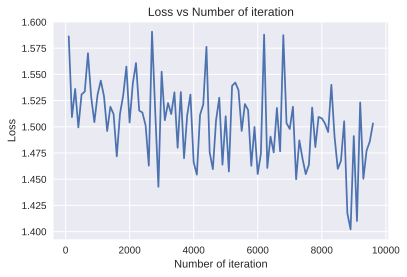

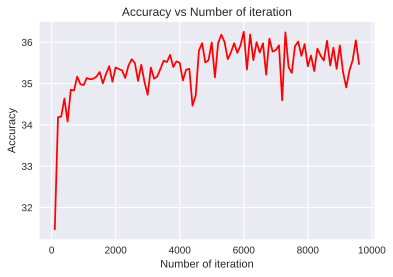

In [82]:
draw_visualization(iteration_list, loss_list, accuracy_list)

**Pred**

In [83]:
_ = load_checkpoint('./cnn_gn_best_checkpoint', model_gn, optimizer)

Loading checkpoint './cnn_gn_best_checkpoint'
Loaded checkpoint './cnn_gn_best_checkpoint' from iteration 5999


In [ ]:
with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=7000, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_gn(batch)

In [ ]:
predicted = torch.max(test_outputs.data,1)[1]

calc_metrics(data_test['rank'].values, predicted)

### **Add Layer Normalization**

In [ ]:

# def calc_metrics(test_label, preds):
#     classes_names = ['0', '1', '2', '3', '4']
#     num_classes = 5

#     plot_confusion_matrix(cm=metrics.confusion_matrix(test_label, preds),
#                           target_names=classes_names,
#                           normalize=False)
    
#     print("Accuracy:",
#           round(metrics.accuracy_score(test_label, preds), 5),
#         '\nBalanced accuracy:',
#         round(metrics.balanced_accuracy_score(test_label, preds), 5), 
#         '\nMulticlass f1-score:',
#         '\n    micro:', round(metrics.f1_score(test_label, preds, average='micro'), 5),
#         '\n    macro:', round(metrics.f1_score(test_label, preds, average='macro'), 5),
#         '\n    weighted:', round(metrics.f1_score(test_label, preds, average='weighted'), 5))
# print('\n\nClassification report:\n')
# print(metrics.classification_report(test_label, preds, digits=5))


In [39]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.LayerNorm(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features = self.joke_encoder(joke_embeddings).squeeze()

        return self.final_predictor(joke_features).squeeze()

In [50]:
model_ln = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ln.parameters(), lr=learning_rate)

In [51]:
iteration_list, loss_list, accuracy_list  = train(model_ln, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_ln_best_checkpoint",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5955954790115356  Accuracy: 31.473295211791992 %
Saving model and optimizer state at iteration 99 to ./cnn_ln_best_checkpoint
Iteration: 199  Loss: 1.583066701889038  Accuracy: 31.473295211791992 %
Iteration: 299  Loss: 1.555360198020935  Accuracy: 31.473295211791992 %
Iteration: 399  Loss: 1.532615303993225  Accuracy: 31.473295211791992 %
Iteration: 499  Loss: 1.5727708339691162  Accuracy: 31.5226993560791 %
Saving model and optimizer state at iteration 499 to ./cnn_ln_best_checkpoint
Iteration: 599  Loss: 1.5256062746047974  Accuracy: 33.70429992675781 %
Saving model and optimizer state at iteration 599 to ./cnn_ln_best_checkpoint
Iteration: 699  Loss: 1.5905901193618774  Accuracy: 33.98512649536133 %
Saving model and optimizer state at iteration 699 to ./cnn_ln_best_checkpoint
Iteration: 799  Loss: 1.5474646091461182  Accuracy: 33.96952438354492 %
Iteration: 899  Loss: 1.5626447200775146  Accuracy: 34.169742584228516 %
Saving model and optimizer state at itera

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5404211282730103  Accuracy: 34.41156768798828 %
Saving model and optimizer state at iteration 999 to ./cnn_ln_best_checkpoint
Iteration: 1099  Loss: 1.5819209814071655  Accuracy: 34.206146240234375 %
Iteration: 1199  Loss: 1.546195149421692  Accuracy: 34.29715347290039 %
Iteration: 1299  Loss: 1.5531891584396362  Accuracy: 34.481773376464844 %
Saving model and optimizer state at iteration 1299 to ./cnn_ln_best_checkpoint
Iteration: 1399  Loss: 1.5588330030441284  Accuracy: 34.38816452026367 %
Iteration: 1499  Loss: 1.522262692451477  Accuracy: 34.59618377685547 %
Saving model and optimizer state at iteration 1499 to ./cnn_ln_best_checkpoint
Iteration: 1599  Loss: 1.512118935585022  Accuracy: 33.80051040649414 %
Iteration: 1699  Loss: 1.5129413604736328  Accuracy: 34.65858840942383 %
Saving model and optimizer state at iteration 1699 to ./cnn_ln_best_checkpoint
Iteration: 1799  Loss: 1.5437766313552856  Accuracy: 34.76259994506836 %
Saving model and optimizer sta

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5303518772125244  Accuracy: 34.5441780090332 %
Iteration: 2099  Loss: 1.54430091381073  Accuracy: 34.193145751953125 %
Iteration: 2199  Loss: 1.5728479623794556  Accuracy: 34.62218475341797 %
Iteration: 2299  Loss: 1.5472012758255005  Accuracy: 34.70279312133789 %
Iteration: 2399  Loss: 1.5176892280578613  Accuracy: 34.7183952331543 %
Iteration: 2499  Loss: 1.5582573413848877  Accuracy: 34.78860092163086 %
Saving model and optimizer state at iteration 2499 to ./cnn_ln_best_checkpoint
Iteration: 2599  Loss: 1.541519045829773  Accuracy: 34.320556640625 %
Iteration: 2699  Loss: 1.5015311241149902  Accuracy: 34.46097183227539 %
Iteration: 2799  Loss: 1.5221211910247803  Accuracy: 34.84580612182617 %
Saving model and optimizer state at iteration 2799 to ./cnn_ln_best_checkpoint
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5376464128494263  Accuracy: 34.7599983215332 %
Iteration: 2999  Loss: 1.5309640169143677  Accuracy: 34.14894104003906 %
Iteration: 3099  Loss: 1.5470472574234009  Accuracy: 34.63518524169922 %
Iteration: 3199  Loss: 1.525909662246704  Accuracy: 34.75739669799805 %
Iteration: 3299  Loss: 1.5261307954788208  Accuracy: 34.80160140991211 %
Iteration: 3399  Loss: 1.534341812133789  Accuracy: 34.36736297607422 %
Iteration: 3499  Loss: 1.5436207056045532  Accuracy: 34.804203033447266 %
Iteration: 3599  Loss: 1.4856462478637695  Accuracy: 34.85880661010742 %
Saving model and optimizer state at iteration 3599 to ./cnn_ln_best_checkpoint
Iteration: 3699  Loss: 1.5260370969772339  Accuracy: 34.65338897705078 %
Iteration: 3799  Loss: 1.5884865522384644  Accuracy: 34.310157775878906 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.5512826442718506  Accuracy: 34.942012786865234 %
Saving model and optimizer state at iteration 3899 to ./cnn_ln_best_checkpoint
Iteration: 3999  Loss: 1.539258599281311  Accuracy: 34.843204498291016 %
Iteration: 4099  Loss: 1.527744174003601  Accuracy: 34.92121124267578 %
Iteration: 4199  Loss: 1.5159554481506348  Accuracy: 34.68979263305664 %
Iteration: 4299  Loss: 1.546163558959961  Accuracy: 34.76519775390625 %
Iteration: 4399  Loss: 1.5272414684295654  Accuracy: 34.47917175292969 %
Iteration: 4499  Loss: 1.511220097541809  Accuracy: 34.54157638549805 %
Iteration: 4599  Loss: 1.5138338804244995  Accuracy: 34.73139572143555 %
Iteration: 4699  Loss: 1.5719807147979736  Accuracy: 34.85100555419922 %
Iteration: 4799  Loss: 1.5803804397583008  Accuracy: 34.830204010009766 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.5916938781738281  Accuracy: 34.73919677734375 %
Iteration: 4999  Loss: 1.5282175540924072  Accuracy: 34.21134567260742 %
Iteration: 5099  Loss: 1.5238980054855347  Accuracy: 34.85100555419922 %
Iteration: 5199  Loss: 1.4785444736480713  Accuracy: 34.588382720947266 %
Iteration: 5299  Loss: 1.4514000415802002  Accuracy: 34.65338897705078 %
Iteration: 5399  Loss: 1.5128262042999268  Accuracy: 34.66899108886719 %
Iteration: 5499  Loss: 1.5203242301940918  Accuracy: 34.219146728515625 %
Iteration: 5599  Loss: 1.5626267194747925  Accuracy: 34.90561294555664 %
Iteration: 5699  Loss: 1.5285366773605347  Accuracy: 34.853607177734375 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.4800353050231934  Accuracy: 35.01742172241211 %
Saving model and optimizer state at iteration 5799 to ./cnn_ln_best_checkpoint
Iteration: 5899  Loss: 1.4863018989562988  Accuracy: 34.60398483276367 %
Iteration: 5999  Loss: 1.5028164386749268  Accuracy: 34.23215103149414 %
Iteration: 6099  Loss: 1.5078980922698975  Accuracy: 34.70279312133789 %
Iteration: 6199  Loss: 1.4892973899841309  Accuracy: 34.94461441040039 %
Iteration: 6299  Loss: 1.535871148109436  Accuracy: 34.983619689941406 %
Iteration: 6399  Loss: 1.5611737966537476  Accuracy: 34.120338439941406 %
Iteration: 6499  Loss: 1.5461004972457886  Accuracy: 34.69239044189453 %
Iteration: 6599  Loss: 1.5342097282409668  Accuracy: 34.46356964111328 %
Iteration: 6699  Loss: 1.5028709173202515  Accuracy: 33.891517639160156 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.5361665487289429  Accuracy: 35.035621643066406 %
Saving model and optimizer state at iteration 6799 to ./cnn_ln_best_checkpoint
Iteration: 6899  Loss: 1.5248419046401978  Accuracy: 34.700191497802734 %
Iteration: 6999  Loss: 1.5163147449493408  Accuracy: 34.51557540893555 %
Iteration: 7099  Loss: 1.4660024642944336  Accuracy: 34.58058166503906 %
Iteration: 7199  Loss: 1.5331511497497559  Accuracy: 34.627384185791016 %
Iteration: 7299  Loss: 1.502678632736206  Accuracy: 34.879608154296875 %
Iteration: 7399  Loss: 1.4616212844848633  Accuracy: 34.59358215332031 %
Iteration: 7499  Loss: 1.4843095541000366  Accuracy: 34.9862174987793 %
Iteration: 7599  Loss: 1.5489706993103027  Accuracy: 34.23474884033203 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.5580229759216309  Accuracy: 34.49217224121094 %
Iteration: 7799  Loss: 1.5134716033935547  Accuracy: 35.022621154785156 %
Iteration: 7899  Loss: 1.4956134557724  Accuracy: 34.28155517578125 %
Iteration: 7999  Loss: 1.5550963878631592  Accuracy: 34.91081237792969 %
Iteration: 8099  Loss: 1.513311505317688  Accuracy: 34.82240295410156 %
Iteration: 8199  Loss: 1.5769315958023071  Accuracy: 34.577980041503906 %
Iteration: 8299  Loss: 1.538731336593628  Accuracy: 35.11103057861328 %
Saving model and optimizer state at iteration 8299 to ./cnn_ln_best_checkpoint
Iteration: 8399  Loss: 1.5796496868133545  Accuracy: 34.9342155456543 %
Iteration: 8499  Loss: 1.5013096332550049  Accuracy: 35.08502960205078 %
Iteration: 8599  Loss: 1.5171236991882324  Accuracy: 34.44017028808594 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.5143016576766968  Accuracy: 34.78340148925781 %
Iteration: 8799  Loss: 1.5565046072006226  Accuracy: 34.85100555419922 %
Iteration: 8899  Loss: 1.550681471824646  Accuracy: 34.5103759765625 %
Iteration: 8999  Loss: 1.5553547143936157  Accuracy: 34.520774841308594 %
Iteration: 9099  Loss: 1.4642665386199951  Accuracy: 34.5103759765625 %
Iteration: 9199  Loss: 1.5560784339904785  Accuracy: 34.434967041015625 %
Iteration: 9299  Loss: 1.5240951776504517  Accuracy: 35.10062789916992 %
Iteration: 9399  Loss: 1.5366175174713135  Accuracy: 34.36736297607422 %
Iteration: 9499  Loss: 1.5340138673782349  Accuracy: 34.78860092163086 %
Iteration: 9599  Loss: 1.514206886291504  Accuracy: 34.82760238647461 %


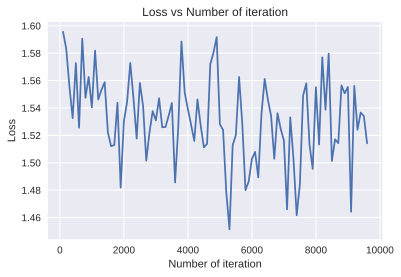

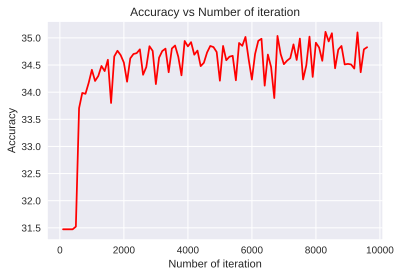

In [52]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [53]:
_ = load_checkpoint('./cnn_ln_best_checkpoint', model_ln, optimizer)

Loading checkpoint './cnn_ln_best_checkpoint'
Loaded checkpoint './cnn_ln_best_checkpoint' from iteration 8299


In [54]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_ln(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted)

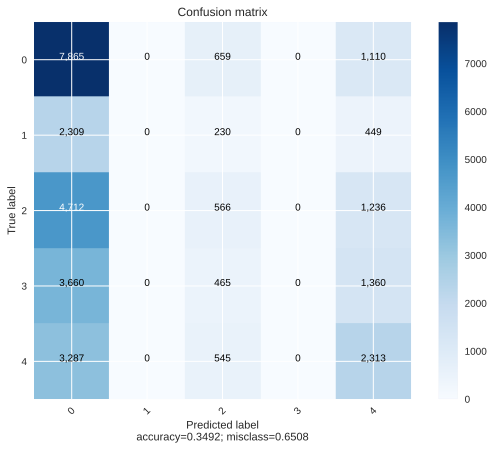

Accuracy: 0.34922 
Balanced accuracy: 0.25593 
Multiclass f1-score: 
    micro: 0.34922 
    macro: 0.19855 
    weighted: 0.25648


Classification report:

              precision    recall  f1-score   support

           0    0.36023   0.81638   0.49989      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.22961   0.08689   0.12607      6514
           3    0.00000   0.00000   0.00000      5485
           4    0.35761   0.37640   0.36676      6145

    accuracy                        0.34922     30766
   macro avg    0.18949   0.25593   0.19855     30766
weighted avg    0.23284   0.34922   0.25648     30766



In [55]:
calc_metrics(data_test['rank'].values, preds)

### CNN layers V1

In [56]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),

            nn.Conv1d(hid_size, hid_size ,kernel_size=3),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.GroupNorm(1, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features = self.joke_encoder(joke_embeddings).squeeze()

        return self.final_predictor(joke_features).squeeze()

In [59]:
model_cnn = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)


In [60]:
iteration_list, loss_list, accuracy_list  = train(model_cnn, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_best_checkpoint",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5610045194625854  Accuracy: 31.473295211791992 %
Saving model and optimizer state at iteration 99 to ./cnn_best_checkpoint
Iteration: 199  Loss: 1.5787012577056885  Accuracy: 31.473295211791992 %
Iteration: 299  Loss: 1.5611486434936523  Accuracy: 31.473295211791992 %
Iteration: 399  Loss: 1.5598503351211548  Accuracy: 33.62629318237305 %
Saving model and optimizer state at iteration 399 to ./cnn_best_checkpoint
Iteration: 499  Loss: 1.5597202777862549  Accuracy: 33.50148391723633 %
Iteration: 599  Loss: 1.5206538438796997  Accuracy: 33.75630569458008 %
Saving model and optimizer state at iteration 599 to ./cnn_best_checkpoint
Iteration: 699  Loss: 1.5806856155395508  Accuracy: 34.076133728027344 %
Saving model and optimizer state at iteration 699 to ./cnn_best_checkpoint
Iteration: 799  Loss: 1.539920687675476  Accuracy: 33.99812698364258 %
Iteration: 899  Loss: 1.5896655321121216  Accuracy: 34.291954040527344 %
Saving model and optimizer state at iteration 899 

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5734453201293945  Accuracy: 34.252952575683594 %
Iteration: 1099  Loss: 1.5587658882141113  Accuracy: 34.219146728515625 %
Iteration: 1199  Loss: 1.5008090734481812  Accuracy: 34.536376953125 %
Saving model and optimizer state at iteration 1199 to ./cnn_best_checkpoint
Iteration: 1299  Loss: 1.555207371711731  Accuracy: 34.494773864746094 %
Iteration: 1399  Loss: 1.5210626125335693  Accuracy: 34.5623779296875 %
Saving model and optimizer state at iteration 1399 to ./cnn_best_checkpoint
Iteration: 1499  Loss: 1.5010308027267456  Accuracy: 34.57278060913086 %
Saving model and optimizer state at iteration 1499 to ./cnn_best_checkpoint
Iteration: 1599  Loss: 1.5263957977294922  Accuracy: 34.310157775878906 %
Iteration: 1699  Loss: 1.5116779804229736  Accuracy: 34.64818572998047 %
Saving model and optimizer state at iteration 1699 to ./cnn_best_checkpoint
Iteration: 1799  Loss: 1.5370597839355469  Accuracy: 34.51557540893555 %
Iteration: 1899  Loss: 1.569148063659668

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5162434577941895  Accuracy: 34.27375411987305 %
Iteration: 2099  Loss: 1.5381971597671509  Accuracy: 34.72879409790039 %
Saving model and optimizer state at iteration 2099 to ./cnn_best_checkpoint
Iteration: 2199  Loss: 1.5558322668075562  Accuracy: 34.7261962890625 %
Iteration: 2299  Loss: 1.5890141725540161  Accuracy: 34.697593688964844 %
Iteration: 2399  Loss: 1.557069182395935  Accuracy: 34.525978088378906 %
Iteration: 2499  Loss: 1.525377869606018  Accuracy: 34.74699783325195 %
Saving model and optimizer state at iteration 2499 to ./cnn_best_checkpoint
Iteration: 2599  Loss: 1.5425598621368408  Accuracy: 34.01112747192383 %
Iteration: 2699  Loss: 1.5185438394546509  Accuracy: 34.93161392211914 %
Saving model and optimizer state at iteration 2699 to ./cnn_best_checkpoint
Iteration: 2799  Loss: 1.4945077896118164  Accuracy: 34.903011322021484 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5445892810821533  Accuracy: 34.67938995361328 %
Iteration: 2999  Loss: 1.5439518690109253  Accuracy: 34.56758117675781 %
Iteration: 3099  Loss: 1.5383479595184326  Accuracy: 34.952415466308594 %
Saving model and optimizer state at iteration 3099 to ./cnn_best_checkpoint
Iteration: 3199  Loss: 1.5678642988204956  Accuracy: 34.91081237792969 %
Iteration: 3299  Loss: 1.4502818584442139  Accuracy: 34.64558792114258 %
Iteration: 3399  Loss: 1.5597245693206787  Accuracy: 34.41936492919922 %
Iteration: 3499  Loss: 1.5435738563537598  Accuracy: 34.203548431396484 %
Iteration: 3599  Loss: 1.5584574937820435  Accuracy: 34.9862174987793 %
Saving model and optimizer state at iteration 3599 to ./cnn_best_checkpoint
Iteration: 3699  Loss: 1.5384654998779297  Accuracy: 34.5103759765625 %
Iteration: 3799  Loss: 1.5627593994140625  Accuracy: 34.29975509643555 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.5162183046340942  Accuracy: 34.91341018676758 %
Iteration: 3999  Loss: 1.517935872077942  Accuracy: 34.520774841308594 %
Iteration: 4099  Loss: 1.5422288179397583  Accuracy: 34.88220977783203 %
Iteration: 4199  Loss: 1.4919414520263672  Accuracy: 34.968017578125 %
Iteration: 4299  Loss: 1.5074970722198486  Accuracy: 34.24774932861328 %
Iteration: 4399  Loss: 1.5244054794311523  Accuracy: 34.79640197753906 %
Iteration: 4499  Loss: 1.540549397468567  Accuracy: 34.736595153808594 %


KeyboardInterrupt: ignored

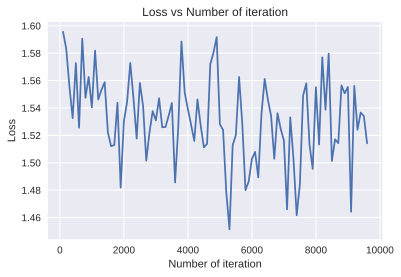

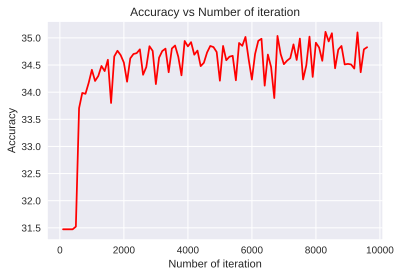

In [61]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [62]:
_ = load_checkpoint('./cnn_best_checkpoint', model_cnn, optimizer)

Loading checkpoint './cnn_best_checkpoint'
Loaded checkpoint './cnn_best_checkpoint' from iteration 3599


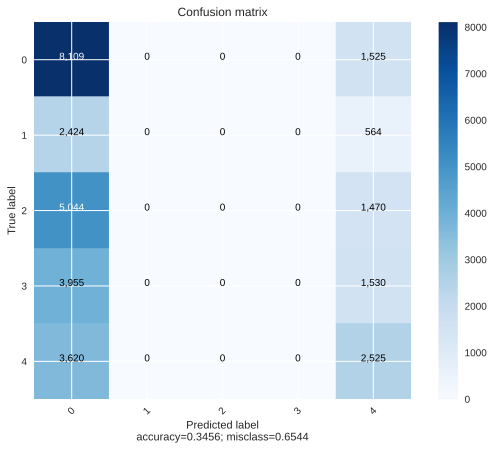

Accuracy: 0.34564 
Balanced accuracy: 0.25052 
Multiclass f1-score: 
    micro: 0.34564 
    macro: 0.17234 
    weighted: 0.22821


Classification report:

              precision    recall  f1-score   support

           0    0.35025   0.84171   0.49466      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.00000   0.00000   0.00000      6514
           3    0.00000   0.00000   0.00000      5485
           4    0.33163   0.41090   0.36703      6145

    accuracy                        0.34564     30766
   macro avg    0.13638   0.25052   0.17234     30766
weighted avg    0.17591   0.34564   0.22821     30766



In [63]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_cnn(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted)

calc_metrics(data_test['rank'].values, preds)

**V2**

In [61]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.Dropout(p=0.25),
            nn.ReLU(),

            nn.Conv1d(hid_size, hid_size ,kernel_size=5),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.GroupNorm(1, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features = self.joke_encoder(joke_embeddings).squeeze()

        return self.final_predictor(joke_features).squeeze()

In [68]:
model_cnn_v2 = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn_v2.parameters(), lr=learning_rate)

In [69]:
iteration_list, loss_list, accuracy_list  = train(model_cnn_v2, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_best_checkpoint_v2",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5897153615951538  Accuracy: 30.186176300048828 %
Saving model and optimizer state at iteration 99 to ./cnn_best_checkpoint_v2
Iteration: 199  Loss: 1.555572271347046  Accuracy: 34.5103759765625 %
Saving model and optimizer state at iteration 199 to ./cnn_best_checkpoint_v2
Iteration: 299  Loss: 1.5368435382843018  Accuracy: 33.8967170715332 %
Iteration: 399  Loss: 1.5443848371505737  Accuracy: 33.48588180541992 %
Iteration: 499  Loss: 1.5685927867889404  Accuracy: 32.9554328918457 %
Iteration: 599  Loss: 1.5431830883026123  Accuracy: 34.27635192871094 %
Iteration: 699  Loss: 1.5368458032608032  Accuracy: 35.01742172241211 %
Saving model and optimizer state at iteration 699 to ./cnn_best_checkpoint_v2
Iteration: 799  Loss: 1.531943678855896  Accuracy: 35.16303253173828 %
Saving model and optimizer state at iteration 799 to ./cnn_best_checkpoint_v2
Iteration: 899  Loss: 1.5753216743469238  Accuracy: 35.23064041137695 %
Saving model and optimizer state at iteration 

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5317702293395996  Accuracy: 35.082427978515625 %
Iteration: 1099  Loss: 1.5769703388214111  Accuracy: 35.24104309082031 %
Saving model and optimizer state at iteration 1099 to ./cnn_best_checkpoint_v2
Iteration: 1199  Loss: 1.5268208980560303  Accuracy: 35.493263244628906 %
Saving model and optimizer state at iteration 1199 to ./cnn_best_checkpoint_v2
Iteration: 1299  Loss: 1.4619359970092773  Accuracy: 35.108428955078125 %
Iteration: 1399  Loss: 1.5709915161132812  Accuracy: 35.24884033203125 %
Iteration: 1499  Loss: 1.5760623216629028  Accuracy: 35.54787063598633 %
Saving model and optimizer state at iteration 1499 to ./cnn_best_checkpoint_v2
Iteration: 1599  Loss: 1.4708762168884277  Accuracy: 35.683082580566406 %
Saving model and optimizer state at iteration 1599 to ./cnn_best_checkpoint_v2
Iteration: 1699  Loss: 1.504534125328064  Accuracy: 35.51926803588867 %
Iteration: 1799  Loss: 1.5373599529266357  Accuracy: 35.298248291015625 %
Iteration: 1899  Loss: 1

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5258013010025024  Accuracy: 35.56087112426758 %
Iteration: 2099  Loss: 1.5243279933929443  Accuracy: 35.4438591003418 %
Iteration: 2199  Loss: 1.5506975650787354  Accuracy: 34.749595642089844 %
Iteration: 2299  Loss: 1.548926830291748  Accuracy: 34.36736297607422 %
Iteration: 2399  Loss: 1.4960697889328003  Accuracy: 35.95610809326172 %
Saving model and optimizer state at iteration 2399 to ./cnn_best_checkpoint_v2
Iteration: 2499  Loss: 1.5166126489639282  Accuracy: 35.99251174926758 %
Saving model and optimizer state at iteration 2499 to ./cnn_best_checkpoint_v2
Iteration: 2599  Loss: 1.5152158737182617  Accuracy: 36.1069221496582 %
Saving model and optimizer state at iteration 2599 to ./cnn_best_checkpoint_v2
Iteration: 2699  Loss: 1.4928109645843506  Accuracy: 36.14852523803711 %
Saving model and optimizer state at iteration 2699 to ./cnn_best_checkpoint_v2
Iteration: 2799  Loss: 1.532780647277832  Accuracy: 36.09392166137695 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.514695167541504  Accuracy: 36.275936126708984 %
Saving model and optimizer state at iteration 2899 to ./cnn_best_checkpoint_v2
Iteration: 2999  Loss: 1.5557745695114136  Accuracy: 34.87180709838867 %
Iteration: 3099  Loss: 1.478318452835083  Accuracy: 36.1251220703125 %
Iteration: 3199  Loss: 1.4890344142913818  Accuracy: 36.010711669921875 %
Iteration: 3299  Loss: 1.5150103569030762  Accuracy: 36.109519958496094 %
Iteration: 3399  Loss: 1.5448274612426758  Accuracy: 35.059024810791016 %
Iteration: 3499  Loss: 1.486335277557373  Accuracy: 36.455352783203125 %
Saving model and optimizer state at iteration 3499 to ./cnn_best_checkpoint_v2
Iteration: 3599  Loss: 1.5618921518325806  Accuracy: 36.09392166137695 %
Iteration: 3699  Loss: 1.5337661504745483  Accuracy: 36.1589241027832 %
Iteration: 3799  Loss: 1.5188841819763184  Accuracy: 36.69197463989258 %
Saving model and optimizer state at iteration 3799 to ./cnn_best_checkpoint_v2
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.4640347957611084  Accuracy: 36.3071403503418 %
Iteration: 3999  Loss: 1.5071508884429932  Accuracy: 36.109519958496094 %
Iteration: 4099  Loss: 1.4910495281219482  Accuracy: 36.17192840576172 %
Iteration: 4199  Loss: 1.4850263595581055  Accuracy: 34.87700653076172 %
Iteration: 4299  Loss: 1.504149317741394  Accuracy: 35.035621643066406 %
Iteration: 4399  Loss: 1.4536330699920654  Accuracy: 35.59987258911133 %
Iteration: 4499  Loss: 1.4583590030670166  Accuracy: 35.61027526855469 %
Iteration: 4599  Loss: 1.497894287109375  Accuracy: 36.37214660644531 %
Iteration: 4699  Loss: 1.5292145013809204  Accuracy: 36.03151321411133 %
Iteration: 4799  Loss: 1.498986840248108  Accuracy: 35.961307525634766 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.5049383640289307  Accuracy: 36.008113861083984 %
Iteration: 4999  Loss: 1.439369559288025  Accuracy: 36.03931427001953 %
Iteration: 5099  Loss: 1.5092897415161133  Accuracy: 36.252532958984375 %
Iteration: 5199  Loss: 1.4661121368408203  Accuracy: 35.82349395751953 %
Iteration: 5299  Loss: 1.5475398302078247  Accuracy: 35.80009460449219 %
Iteration: 5399  Loss: 1.507830023765564  Accuracy: 36.166725158691406 %
Iteration: 5499  Loss: 1.515005350112915  Accuracy: 35.88330078125 %
Iteration: 5599  Loss: 1.4280507564544678  Accuracy: 35.38145446777344 %
Iteration: 5699  Loss: 1.4865045547485352  Accuracy: 35.55826950073242 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.4817373752593994  Accuracy: 36.05491638183594 %
Iteration: 5899  Loss: 1.517606258392334  Accuracy: 35.90670394897461 %
Iteration: 5999  Loss: 1.4731279611587524  Accuracy: 36.20833206176758 %
Iteration: 6099  Loss: 1.476563811302185  Accuracy: 36.00031280517578 %
Iteration: 6199  Loss: 1.4496042728424072  Accuracy: 35.46466064453125 %
Iteration: 6299  Loss: 1.4943510293960571  Accuracy: 36.04191589355469 %
Iteration: 6399  Loss: 1.4824864864349365  Accuracy: 35.50106430053711 %
Iteration: 6499  Loss: 1.4175559282302856  Accuracy: 35.66228103637695 %
Iteration: 6599  Loss: 1.508674144744873  Accuracy: 36.14852523803711 %
Iteration: 6699  Loss: 1.4979255199432373  Accuracy: 36.1069221496582 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.4554054737091064  Accuracy: 36.190128326416016 %
Iteration: 6899  Loss: 1.5075786113739014  Accuracy: 35.628475189208984 %
Iteration: 6999  Loss: 1.5097981691360474  Accuracy: 36.023712158203125 %
Iteration: 7099  Loss: 1.474299430847168  Accuracy: 35.91450500488281 %
Iteration: 7199  Loss: 1.4993153810501099  Accuracy: 36.31753921508789 %
Iteration: 7299  Loss: 1.5040937662124634  Accuracy: 36.060115814208984 %
Iteration: 7399  Loss: 1.459611177444458  Accuracy: 35.83649444580078 %
Iteration: 7499  Loss: 1.4831485748291016  Accuracy: 35.612876892089844 %
Iteration: 7599  Loss: 1.4633723497390747  Accuracy: 35.337249755859375 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.4374234676361084  Accuracy: 35.85989761352539 %
Iteration: 7799  Loss: 1.432138442993164  Accuracy: 35.347652435302734 %
Iteration: 7899  Loss: 1.4388819932937622  Accuracy: 36.166725158691406 %
Iteration: 7999  Loss: 1.3982304334640503  Accuracy: 35.493263244628906 %
Iteration: 8099  Loss: 1.4502241611480713  Accuracy: 36.18752670288086 %
Iteration: 8199  Loss: 1.4471275806427002  Accuracy: 35.841697692871094 %
Iteration: 8299  Loss: 1.434194564819336  Accuracy: 36.19792938232422 %
Iteration: 8399  Loss: 1.4278039932250977  Accuracy: 35.76108932495117 %
Iteration: 8499  Loss: 1.4304819107055664  Accuracy: 36.008113861083984 %
Iteration: 8599  Loss: 1.5020577907562256  Accuracy: 35.19943618774414 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.3948944807052612  Accuracy: 35.807891845703125 %
Iteration: 8799  Loss: 1.447952389717102  Accuracy: 35.85989761352539 %
Iteration: 8899  Loss: 1.4471672773361206  Accuracy: 35.14223098754883 %
Iteration: 8999  Loss: 1.4699022769927979  Accuracy: 36.502159118652344 %
Iteration: 9099  Loss: 1.4701892137527466  Accuracy: 35.96650695800781 %
Iteration: 9199  Loss: 1.4728679656982422  Accuracy: 36.17972946166992 %
Iteration: 9299  Loss: 1.5192956924438477  Accuracy: 35.758487701416016 %
Iteration: 9399  Loss: 1.4311364889144897  Accuracy: 35.67267990112305 %
Iteration: 9499  Loss: 1.4641109704971313  Accuracy: 36.42414855957031 %
Iteration: 9599  Loss: 1.5153356790542603  Accuracy: 35.9171028137207 %


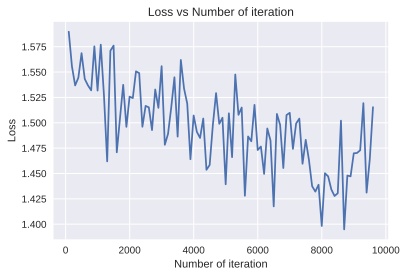

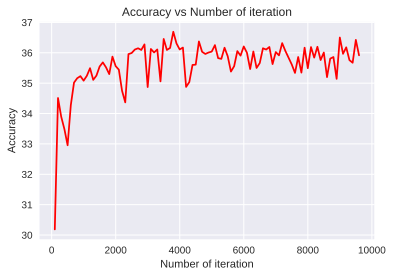

In [70]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [71]:
_ = load_checkpoint('./cnn_best_checkpoint_v2', model_cnn_v2, optimizer)

Loading checkpoint './cnn_best_checkpoint_v2'
Loaded checkpoint './cnn_best_checkpoint_v2' from iteration 3799


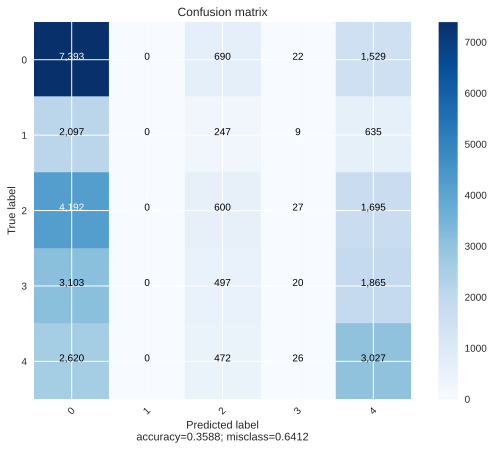

Accuracy: 0.35884 
Balanced accuracy: 0.27115 
Multiclass f1-score: 
    micro: 0.35884 
    macro: 0.21116 
    weighted: 0.27006


Classification report:

              precision    recall  f1-score   support

           0    0.38098   0.76739   0.50918      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.23943   0.09211   0.13304      6514
           3    0.19231   0.00365   0.00716      5485
           4    0.34590   0.49260   0.40642      6145

    accuracy                        0.35884     30766
   macro avg    0.23172   0.27115   0.21116     30766
weighted avg    0.27337   0.35884   0.27006     30766



In [72]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_cnn_v2(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

**Add more Conv. layers V3**

In [73]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),

            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.Dropout(p=0.25),
            nn.ReLU(),

            nn.Conv1d(hid_size, hid_size ,kernel_size=5),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.GroupNorm(1, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features = self.joke_encoder(joke_embeddings).squeeze()

        return self.final_predictor(joke_features).squeeze()

In [74]:
model_cnn_v3 = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn_v3.parameters(), lr=learning_rate)

In [75]:
iteration_list, loss_list, accuracy_list  = train(model_cnn_v3, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_best_checkpoint_v3",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.554137945175171  Accuracy: 34.24515151977539 %
Saving model and optimizer state at iteration 99 to ./cnn_best_checkpoint_v3
Iteration: 199  Loss: 1.5803898572921753  Accuracy: 32.95022964477539 %
Iteration: 299  Loss: 1.5746338367462158  Accuracy: 34.0709342956543 %
Iteration: 399  Loss: 1.533982753753662  Accuracy: 32.9996337890625 %
Iteration: 499  Loss: 1.5136489868164062  Accuracy: 34.577980041503906 %
Saving model and optimizer state at iteration 499 to ./cnn_best_checkpoint_v3
Iteration: 599  Loss: 1.5430856943130493  Accuracy: 34.33095932006836 %
Iteration: 699  Loss: 1.532363772392273  Accuracy: 34.90040969848633 %
Saving model and optimizer state at iteration 699 to ./cnn_best_checkpoint_v3
Iteration: 799  Loss: 1.572935938835144  Accuracy: 34.143741607666016 %
Iteration: 899  Loss: 1.533387541770935  Accuracy: 34.991416931152344 %
Saving model and optimizer state at iteration 899 to ./cnn_best_checkpoint_v3
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5151726007461548  Accuracy: 34.952415466308594 %
Iteration: 1099  Loss: 1.5338011980056763  Accuracy: 34.663787841796875 %
Iteration: 1199  Loss: 1.4937735795974731  Accuracy: 35.033023834228516 %
Saving model and optimizer state at iteration 1199 to ./cnn_best_checkpoint_v3
Iteration: 1299  Loss: 1.5407724380493164  Accuracy: 35.022621154785156 %
Iteration: 1399  Loss: 1.5837911367416382  Accuracy: 34.5103759765625 %
Iteration: 1499  Loss: 1.5011096000671387  Accuracy: 34.892608642578125 %
Iteration: 1599  Loss: 1.520819067955017  Accuracy: 35.03042221069336 %
Iteration: 1699  Loss: 1.4917813539505005  Accuracy: 34.278953552246094 %
Iteration: 1799  Loss: 1.5323277711868286  Accuracy: 35.13963317871094 %
Saving model and optimizer state at iteration 1799 to ./cnn_best_checkpoint_v3
Iteration: 1899  Loss: 1.5895674228668213  Accuracy: 31.551301956176758 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.512346863746643  Accuracy: 35.168235778808594 %
Saving model and optimizer state at iteration 1999 to ./cnn_best_checkpoint_v3
Iteration: 2099  Loss: 1.4955480098724365  Accuracy: 35.10062789916992 %
Iteration: 2199  Loss: 1.5368411540985107  Accuracy: 35.55046844482422 %
Saving model and optimizer state at iteration 2199 to ./cnn_best_checkpoint_v3
Iteration: 2299  Loss: 1.4677438735961914  Accuracy: 35.54526901245117 %
Iteration: 2399  Loss: 1.5108717679977417  Accuracy: 35.61027526855469 %
Saving model and optimizer state at iteration 2399 to ./cnn_best_checkpoint_v3
Iteration: 2499  Loss: 1.4957761764526367  Accuracy: 35.755889892578125 %
Saving model and optimizer state at iteration 2499 to ./cnn_best_checkpoint_v3
Iteration: 2599  Loss: 1.520359992980957  Accuracy: 35.696083068847656 %
Iteration: 2699  Loss: 1.523146390914917  Accuracy: 35.51406478881836 %
Iteration: 2799  Loss: 1.5249900817871094  Accuracy: 35.893699645996094 %
Saving model and optimizer

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.4590237140655518  Accuracy: 35.64407730102539 %
Iteration: 2999  Loss: 1.4888734817504883  Accuracy: 35.4438591003418 %
Iteration: 3099  Loss: 1.52196204662323  Accuracy: 35.238441467285156 %
Iteration: 3199  Loss: 1.5100375413894653  Accuracy: 35.625877380371094 %
Iteration: 3299  Loss: 1.484127402305603  Accuracy: 35.324249267578125 %
Iteration: 3399  Loss: 1.489842414855957  Accuracy: 35.360652923583984 %
Iteration: 3499  Loss: 1.502802848815918  Accuracy: 36.06791687011719 %
Saving model and optimizer state at iteration 3499 to ./cnn_best_checkpoint_v3
Iteration: 3599  Loss: 1.5264092683792114  Accuracy: 36.04191589355469 %
Iteration: 3699  Loss: 1.4870671033859253  Accuracy: 35.90670394897461 %
Iteration: 3799  Loss: 1.5304044485092163  Accuracy: 35.85209655761719 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.4251821041107178  Accuracy: 35.92230224609375 %
Iteration: 3999  Loss: 1.5184050798416138  Accuracy: 34.713191986083984 %
Iteration: 4099  Loss: 1.4899661540985107  Accuracy: 36.04971694946289 %
Iteration: 4199  Loss: 1.5410451889038086  Accuracy: 36.16152572631836 %
Saving model and optimizer state at iteration 4199 to ./cnn_best_checkpoint_v3
Iteration: 4299  Loss: 1.5247902870178223  Accuracy: 35.664878845214844 %
Iteration: 4399  Loss: 1.4671176671981812  Accuracy: 35.8754997253418 %
Iteration: 4499  Loss: 1.5338919162750244  Accuracy: 36.01851272583008 %
Iteration: 4599  Loss: 1.4599716663360596  Accuracy: 35.911903381347656 %
Iteration: 4699  Loss: 1.4891602993011475  Accuracy: 35.96390914916992 %
Iteration: 4799  Loss: 1.480549693107605  Accuracy: 36.034114837646484 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.5047001838684082  Accuracy: 35.25404357910156 %
Iteration: 4999  Loss: 1.498108983039856  Accuracy: 35.58427429199219 %
Iteration: 5099  Loss: 1.4435937404632568  Accuracy: 35.79749298095703 %
Iteration: 5199  Loss: 1.4737027883529663  Accuracy: 36.30453872680664 %
Saving model and optimizer state at iteration 5199 to ./cnn_best_checkpoint_v3
Iteration: 5299  Loss: 1.5117803812026978  Accuracy: 35.81569290161133 %
Iteration: 5399  Loss: 1.479933738708496  Accuracy: 36.13552474975586 %
Iteration: 5499  Loss: 1.496067762374878  Accuracy: 36.047115325927734 %
Iteration: 5599  Loss: 1.4656471014022827  Accuracy: 35.97951126098633 %
Iteration: 5699  Loss: 1.4697376489639282  Accuracy: 36.47095489501953 %
Saving model and optimizer state at iteration 5699 to ./cnn_best_checkpoint_v3
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.5114164352416992  Accuracy: 35.75328826904297 %
Iteration: 5899  Loss: 1.4551308155059814  Accuracy: 35.18643569946289 %
Iteration: 5999  Loss: 1.4884737730026245  Accuracy: 35.97951126098633 %
Iteration: 6099  Loss: 1.4855717420578003  Accuracy: 35.238441467285156 %
Iteration: 6199  Loss: 1.512427568435669  Accuracy: 35.63627624511719 %
Iteration: 6299  Loss: 1.5437644720077515  Accuracy: 35.89630126953125 %
Iteration: 6399  Loss: 1.455657720565796  Accuracy: 36.021114349365234 %
Iteration: 6499  Loss: 1.5446995496749878  Accuracy: 35.83649444580078 %
Iteration: 6599  Loss: 1.5104444026947021  Accuracy: 36.43715286254883 %
Iteration: 6699  Loss: 1.4806270599365234  Accuracy: 36.00031280517578 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.4729312658309937  Accuracy: 35.70388412475586 %
Iteration: 6899  Loss: 1.4337143898010254  Accuracy: 35.4178581237793 %
Iteration: 6999  Loss: 1.4907593727111816  Accuracy: 36.140724182128906 %
Iteration: 7099  Loss: 1.529626488685608  Accuracy: 35.91450500488281 %
Iteration: 7199  Loss: 1.5339604616165161  Accuracy: 36.01331329345703 %
Iteration: 7299  Loss: 1.489578366279602  Accuracy: 35.61027526855469 %
Iteration: 7399  Loss: 1.5064103603363037  Accuracy: 36.1173210144043 %
Iteration: 7499  Loss: 1.4320640563964844  Accuracy: 36.166725158691406 %
Iteration: 7599  Loss: 1.5066742897033691  Accuracy: 35.99251174926758 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.4083832502365112  Accuracy: 35.841697692871094 %
Iteration: 7799  Loss: 1.4583977460861206  Accuracy: 35.911903381347656 %
Iteration: 7899  Loss: 1.4581875801086426  Accuracy: 35.99510955810547 %
Iteration: 7999  Loss: 1.4871090650558472  Accuracy: 35.23324203491211 %
Iteration: 8099  Loss: 1.4228894710540771  Accuracy: 35.48286437988281 %
Iteration: 8199  Loss: 1.4823638200759888  Accuracy: 35.44906234741211 %
Iteration: 8299  Loss: 1.4483580589294434  Accuracy: 35.971710205078125 %
Iteration: 8399  Loss: 1.4265751838684082  Accuracy: 35.87810134887695 %
Iteration: 8499  Loss: 1.461121916770935  Accuracy: 35.36585235595703 %
Iteration: 8599  Loss: 1.3449509143829346  Accuracy: 35.92230224609375 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.4315955638885498  Accuracy: 35.72988510131836 %
Iteration: 8799  Loss: 1.4189807176589966  Accuracy: 35.78709030151367 %
Iteration: 8899  Loss: 1.4713459014892578  Accuracy: 35.527069091796875 %
Iteration: 8999  Loss: 1.4583929777145386  Accuracy: 35.25664138793945 %
Iteration: 9099  Loss: 1.4115679264068604  Accuracy: 36.096519470214844 %
Iteration: 9199  Loss: 1.4362785816192627  Accuracy: 34.9940185546875 %
Iteration: 9299  Loss: 1.4412552118301392  Accuracy: 35.38145446777344 %
Iteration: 9399  Loss: 1.4268343448638916  Accuracy: 35.628475189208984 %
Iteration: 9499  Loss: 1.4417445659637451  Accuracy: 35.87289810180664 %
Iteration: 9599  Loss: 1.4746779203414917  Accuracy: 35.86249923706055 %


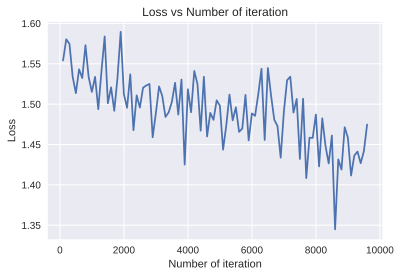

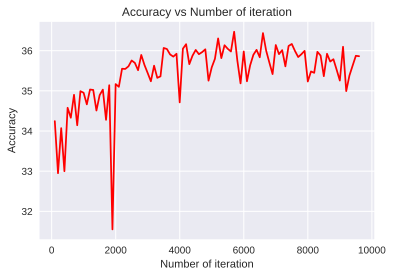

In [76]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [77]:
_ = load_checkpoint('./cnn_best_checkpoint_v3', model_cnn_v3, optimizer)

Loading checkpoint './cnn_best_checkpoint_v3'
Loaded checkpoint './cnn_best_checkpoint_v3' from iteration 5699


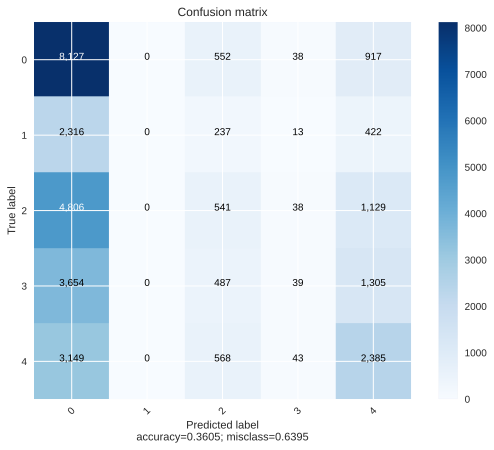

Accuracy: 0.36053 
Balanced accuracy: 0.26437 
Multiclass f1-score: 
    micro: 0.36053 
    macro: 0.20721 
    weighted: 0.26627


Classification report:

              precision    recall  f1-score   support

           0    0.36854   0.84357   0.51297      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.22683   0.08305   0.12159      6514
           3    0.22807   0.00711   0.01379      5485
           4    0.38730   0.38812   0.38771      6145

    accuracy                        0.36053     30766
   macro avg    0.24215   0.26437   0.20721     30766
weighted avg    0.28145   0.36053   0.26627     30766



In [78]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_cnn_v3(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

### **V4**

In [79]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.MaxPool1d(2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.GroupNorm(1, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features = self.joke_encoder(joke_embeddings).squeeze()

        return self.final_predictor(joke_features).squeeze()

In [80]:
model_cnn_v4 = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn_v4.parameters(), lr=learning_rate)

In [81]:
iteration_list, loss_list, accuracy_list  = train(model_cnn_v4, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_best_checkpoint_v4",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.557693600654602  Accuracy: 32.98663330078125 %
Saving model and optimizer state at iteration 99 to ./cnn_best_checkpoint_v4
Iteration: 199  Loss: 1.5850894451141357  Accuracy: 34.89521026611328 %
Saving model and optimizer state at iteration 199 to ./cnn_best_checkpoint_v4
Iteration: 299  Loss: 1.5489819049835205  Accuracy: 34.193145751953125 %
Iteration: 399  Loss: 1.510162591934204  Accuracy: 34.996620178222656 %
Saving model and optimizer state at iteration 399 to ./cnn_best_checkpoint_v4
Iteration: 499  Loss: 1.513824701309204  Accuracy: 35.18903732299805 %
Saving model and optimizer state at iteration 499 to ./cnn_best_checkpoint_v4
Iteration: 599  Loss: 1.4969652891159058  Accuracy: 35.15003204345703 %
Iteration: 699  Loss: 1.546288251876831  Accuracy: 35.31644821166992 %
Saving model and optimizer state at iteration 699 to ./cnn_best_checkpoint_v4
Iteration: 799  Loss: 1.4994533061981201  Accuracy: 34.98101806640625 %
Iteration: 899  Loss: 1.50988543033599

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.4779644012451172  Accuracy: 35.12663269042969 %
Iteration: 1099  Loss: 1.5215190649032593  Accuracy: 35.07722473144531 %
Iteration: 1199  Loss: 1.5342931747436523  Accuracy: 35.58167266845703 %
Saving model and optimizer state at iteration 1199 to ./cnn_best_checkpoint_v4
Iteration: 1299  Loss: 1.5542634725570679  Accuracy: 35.26704406738281 %
Iteration: 1399  Loss: 1.5212388038635254  Accuracy: 35.71688461303711 %
Saving model and optimizer state at iteration 1399 to ./cnn_best_checkpoint_v4
Iteration: 1499  Loss: 1.503290057182312  Accuracy: 35.72728729248047 %
Saving model and optimizer state at iteration 1499 to ./cnn_best_checkpoint_v4
Iteration: 1599  Loss: 1.5550750494003296  Accuracy: 35.58167266845703 %
Iteration: 1699  Loss: 1.5070396661758423  Accuracy: 35.935306549072266 %
Saving model and optimizer state at iteration 1699 to ./cnn_best_checkpoint_v4
Iteration: 1799  Loss: 1.4586362838745117  Accuracy: 36.08091735839844 %
Saving model and optimizer s

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5565924644470215  Accuracy: 36.057518005371094 %
Iteration: 2099  Loss: 1.5121780633926392  Accuracy: 35.844295501708984 %
Iteration: 2199  Loss: 1.5431467294692993  Accuracy: 36.057518005371094 %
Iteration: 2299  Loss: 1.5101535320281982  Accuracy: 36.252532958984375 %
Saving model and optimizer state at iteration 2299 to ./cnn_best_checkpoint_v4
Iteration: 2399  Loss: 1.5348056554794312  Accuracy: 36.07831954956055 %
Iteration: 2499  Loss: 1.5048831701278687  Accuracy: 35.576473236083984 %
Iteration: 2599  Loss: 1.500900387763977  Accuracy: 35.6596794128418 %
Iteration: 2699  Loss: 1.484615683555603  Accuracy: 36.07571792602539 %
Iteration: 2799  Loss: 1.4775116443634033  Accuracy: 36.262935638427734 %
Saving model and optimizer state at iteration 2799 to ./cnn_best_checkpoint_v4
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.555649995803833  Accuracy: 35.99510955810547 %
Iteration: 2999  Loss: 1.5159108638763428  Accuracy: 36.21873092651367 %
Iteration: 3099  Loss: 1.5704822540283203  Accuracy: 35.709083557128906 %
Iteration: 3199  Loss: 1.4989508390426636  Accuracy: 34.736595153808594 %
Iteration: 3299  Loss: 1.4837228059768677  Accuracy: 36.48915481567383 %
Saving model and optimizer state at iteration 3299 to ./cnn_best_checkpoint_v4
Iteration: 3399  Loss: 1.5268657207489014  Accuracy: 35.410057067871094 %
Iteration: 3499  Loss: 1.5123376846313477  Accuracy: 36.286338806152344 %
Iteration: 3599  Loss: 1.5564371347427368  Accuracy: 35.77149200439453 %
Iteration: 3699  Loss: 1.5525977611541748  Accuracy: 35.467262268066406 %
Iteration: 3799  Loss: 1.5014301538467407  Accuracy: 35.9171028137207 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.5108264684677124  Accuracy: 36.07831954956055 %
Iteration: 3999  Loss: 1.4831604957580566  Accuracy: 35.10062789916992 %
Iteration: 4099  Loss: 1.4440977573394775  Accuracy: 36.26553726196289 %
Iteration: 4199  Loss: 1.447954773902893  Accuracy: 36.216129302978516 %
Iteration: 4299  Loss: 1.5270545482635498  Accuracy: 35.6492805480957 %
Iteration: 4399  Loss: 1.5547964572906494  Accuracy: 36.85319137573242 %
Saving model and optimizer state at iteration 4399 to ./cnn_best_checkpoint_v4
Iteration: 4499  Loss: 1.414150595664978  Accuracy: 36.22133255004883 %
Iteration: 4599  Loss: 1.5061360597610474  Accuracy: 36.01851272583008 %
Iteration: 4699  Loss: 1.4786995649337769  Accuracy: 35.59727478027344 %
Iteration: 4799  Loss: 1.5062072277069092  Accuracy: 36.70237731933594 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.4743987321853638  Accuracy: 36.06271743774414 %
Iteration: 4999  Loss: 1.4707094430923462  Accuracy: 36.010711669921875 %
Iteration: 5099  Loss: 1.4455528259277344  Accuracy: 34.15154266357422 %
Iteration: 5199  Loss: 1.5058021545410156  Accuracy: 35.63627624511719 %
Iteration: 5299  Loss: 1.426052212715149  Accuracy: 36.18232727050781 %
Iteration: 5399  Loss: 1.41530442237854  Accuracy: 36.47355651855469 %
Iteration: 5499  Loss: 1.4883650541305542  Accuracy: 35.88330078125 %
Iteration: 5599  Loss: 1.4557411670684814  Accuracy: 35.719486236572266 %
Iteration: 5699  Loss: 1.4942047595977783  Accuracy: 36.49695587158203 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.4767099618911743  Accuracy: 36.01331329345703 %
Iteration: 5899  Loss: 1.545737624168396  Accuracy: 36.72317886352539 %
Iteration: 5999  Loss: 1.4272981882095337  Accuracy: 36.20833206176758 %
Iteration: 6099  Loss: 1.467702865600586  Accuracy: 36.29153823852539 %
Iteration: 6199  Loss: 1.4242124557495117  Accuracy: 36.325340270996094 %
Iteration: 6299  Loss: 1.4558171033859253  Accuracy: 35.78449249267578 %
Iteration: 6399  Loss: 1.5367623567581177  Accuracy: 35.81309509277344 %
Iteration: 6499  Loss: 1.4550187587738037  Accuracy: 36.56976318359375 %
Iteration: 6599  Loss: 1.409466028213501  Accuracy: 36.431949615478516 %
Iteration: 6699  Loss: 1.4509483575820923  Accuracy: 34.9940185546875 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.4473750591278076  Accuracy: 35.94310760498047 %
Iteration: 6899  Loss: 1.43297278881073  Accuracy: 36.127723693847656 %
Iteration: 6999  Loss: 1.4685089588165283  Accuracy: 36.00031280517578 %
Iteration: 7099  Loss: 1.4587392807006836  Accuracy: 34.67938995361328 %
Iteration: 7199  Loss: 1.499420166015625  Accuracy: 36.26553726196289 %
Iteration: 7299  Loss: 1.4319819211959839  Accuracy: 35.15003204345703 %
Iteration: 7399  Loss: 1.4616422653198242  Accuracy: 36.53076171875 %
Iteration: 7499  Loss: 1.4515396356582642  Accuracy: 35.98210906982422 %
Iteration: 7599  Loss: 1.5124064683914185  Accuracy: 36.36174392700195 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.4232984781265259  Accuracy: 36.455352783203125 %
Iteration: 7799  Loss: 1.4696964025497437  Accuracy: 36.096519470214844 %
Iteration: 7899  Loss: 1.4856963157653809  Accuracy: 36.32014083862305 %
Iteration: 7999  Loss: 1.5222022533416748  Accuracy: 35.410057067871094 %
Iteration: 8099  Loss: 1.4681264162063599  Accuracy: 36.15632629394531 %
Iteration: 8199  Loss: 1.4972635507583618  Accuracy: 35.170833587646484 %
Iteration: 8299  Loss: 1.4749464988708496  Accuracy: 36.04451370239258 %
Iteration: 8399  Loss: 1.4412171840667725  Accuracy: 36.38514709472656 %
Iteration: 8499  Loss: 1.4467908143997192  Accuracy: 36.1069221496582 %
Iteration: 8599  Loss: 1.4269940853118896  Accuracy: 36.47095489501953 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.411258339881897  Accuracy: 36.50735855102539 %
Iteration: 8799  Loss: 1.4437397718429565  Accuracy: 36.1173210144043 %
Iteration: 8899  Loss: 1.4695128202438354  Accuracy: 35.4334602355957 %
Iteration: 8999  Loss: 1.4464014768600464  Accuracy: 35.706485748291016 %
Iteration: 9099  Loss: 1.4588061571121216  Accuracy: 35.65447998046875 %
Iteration: 9199  Loss: 1.4083778858184814  Accuracy: 35.84689712524414 %
Iteration: 9299  Loss: 1.3804746866226196  Accuracy: 35.794891357421875 %
Iteration: 9399  Loss: 1.4714630842208862  Accuracy: 35.38145446777344 %
Iteration: 9499  Loss: 1.4281948804855347  Accuracy: 34.78860092163086 %
Iteration: 9599  Loss: 1.448163628578186  Accuracy: 35.60507583618164 %


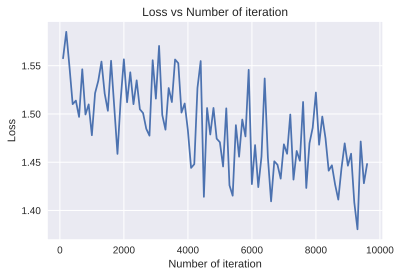

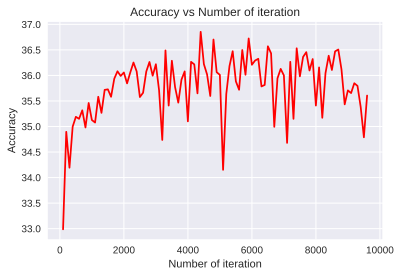

In [82]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [83]:
_ = load_checkpoint('./cnn_best_checkpoint_v4', model_cnn_v4, optimizer)

Loading checkpoint './cnn_best_checkpoint_v4'
Loaded checkpoint './cnn_best_checkpoint_v4' from iteration 4399


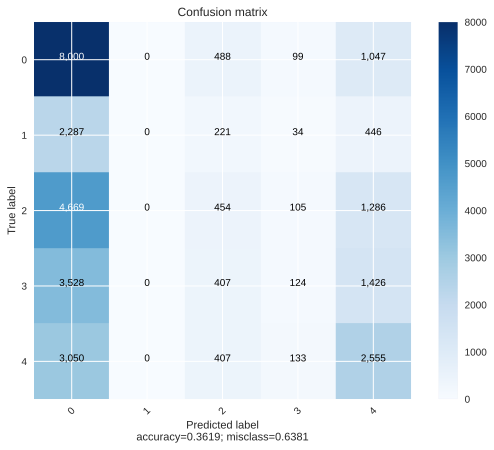

Accuracy: 0.36186 
Balanced accuracy: 0.2677 
Multiclass f1-score: 
    micro: 0.36186 
    macro: 0.21155 
    weighted: 0.26987


Classification report:

              precision    recall  f1-score   support

           0    0.37151   0.83039   0.51335      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.22964   0.06970   0.10694      6514
           3    0.25051   0.02261   0.04147      5485
           4    0.37796   0.41579   0.39597      6145

    accuracy                        0.36186     30766
   macro avg    0.24592   0.26770   0.21155     30766
weighted avg    0.28511   0.36186   0.26987     30766



In [84]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_cnn_v4(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

### **(add more Conv. layers & MaxPooling)**

In [89]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size*2, kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(hid_size*2, hid_size*2, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(hid_size*2, hid_size, kernel_size=5),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features = self.joke_encoder(joke_embeddings).squeeze()

        return self.final_predictor(joke_features).squeeze()

In [90]:
model_cnn5 = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn5.parameters(), lr=learning_rate)

In [91]:
iteration_list, loss_list, accuracy_list  = train(model_cnn5, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_best_checkpoint_v5",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5245040655136108  Accuracy: 31.473295211791992 %
Saving model and optimizer state at iteration 99 to ./cnn_best_checkpoint_v5
Iteration: 199  Loss: 1.5051189661026  Accuracy: 31.691715240478516 %
Saving model and optimizer state at iteration 199 to ./cnn_best_checkpoint_v5
Iteration: 299  Loss: 1.5228567123413086  Accuracy: 31.988142013549805 %
Saving model and optimizer state at iteration 299 to ./cnn_best_checkpoint_v5
Iteration: 399  Loss: 1.5374033451080322  Accuracy: 33.124446868896484 %
Saving model and optimizer state at iteration 399 to ./cnn_best_checkpoint_v5
Iteration: 499  Loss: 1.604420781135559  Accuracy: 32.37557601928711 %
Iteration: 599  Loss: 1.5638937950134277  Accuracy: 31.826927185058594 %
Iteration: 699  Loss: 1.533011555671692  Accuracy: 33.74070358276367 %
Saving model and optimizer state at iteration 699 to ./cnn_best_checkpoint_v5
Iteration: 799  Loss: 1.5316683053970337  Accuracy: 33.064640045166016 %
Iteration: 899  Loss: 1.54582798480

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.515499234199524  Accuracy: 34.003326416015625 %
Saving model and optimizer state at iteration 999 to ./cnn_best_checkpoint_v5
Iteration: 1099  Loss: 1.5018864870071411  Accuracy: 33.1556510925293 %
Iteration: 1199  Loss: 1.5007870197296143  Accuracy: 32.59659957885742 %
Iteration: 1299  Loss: 1.5182710886001587  Accuracy: 33.55348587036133 %
Iteration: 1399  Loss: 1.5649710893630981  Accuracy: 33.4234733581543 %
Iteration: 1499  Loss: 1.4879361391067505  Accuracy: 34.52337646484375 %
Saving model and optimizer state at iteration 1499 to ./cnn_best_checkpoint_v5
Iteration: 1599  Loss: 1.487748622894287  Accuracy: 34.74179458618164 %
Saving model and optimizer state at iteration 1599 to ./cnn_best_checkpoint_v5
Iteration: 1699  Loss: 1.4754117727279663  Accuracy: 34.43236541748047 %
Iteration: 1799  Loss: 1.5184863805770874  Accuracy: 33.644493103027344 %
Iteration: 1899  Loss: 1.564589023590088  Accuracy: 34.551979064941406 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.4854074716567993  Accuracy: 33.472877502441406 %
Iteration: 2099  Loss: 1.490311622619629  Accuracy: 35.441261291503906 %
Saving model and optimizer state at iteration 2099 to ./cnn_best_checkpoint_v5
Iteration: 2199  Loss: 1.501711130142212  Accuracy: 35.410057067871094 %
Iteration: 2299  Loss: 1.5278956890106201  Accuracy: 34.27115249633789 %
Iteration: 2399  Loss: 1.566603422164917  Accuracy: 34.089134216308594 %
Iteration: 2499  Loss: 1.5611793994903564  Accuracy: 35.07982635498047 %
Iteration: 2599  Loss: 1.5124125480651855  Accuracy: 33.966922760009766 %
Iteration: 2699  Loss: 1.4635618925094604  Accuracy: 35.34244918823242 %
Iteration: 2799  Loss: 1.528281807899475  Accuracy: 33.94872283935547 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5192424058914185  Accuracy: 33.47808074951172 %
Iteration: 2999  Loss: 1.5024570226669312  Accuracy: 34.375160217285156 %
Iteration: 3099  Loss: 1.5155682563781738  Accuracy: 34.86140823364258 %
Iteration: 3199  Loss: 1.503312110900879  Accuracy: 34.75739669799805 %
Iteration: 3299  Loss: 1.4971259832382202  Accuracy: 35.70388412475586 %
Saving model and optimizer state at iteration 3299 to ./cnn_best_checkpoint_v5
Iteration: 3399  Loss: 1.5517590045928955  Accuracy: 35.516666412353516 %
Iteration: 3499  Loss: 1.4580848217010498  Accuracy: 35.80009460449219 %
Saving model and optimizer state at iteration 3499 to ./cnn_best_checkpoint_v5
Iteration: 3599  Loss: 1.4553990364074707  Accuracy: 34.26335144042969 %
Iteration: 3699  Loss: 1.5477567911148071  Accuracy: 35.49846649169922 %
Iteration: 3799  Loss: 1.5673022270202637  Accuracy: 34.1385383605957 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.5236144065856934  Accuracy: 35.16043472290039 %
Iteration: 3999  Loss: 1.4505521059036255  Accuracy: 34.73399353027344 %
Iteration: 4099  Loss: 1.5022882223129272  Accuracy: 35.625877380371094 %
Iteration: 4199  Loss: 1.5037018060684204  Accuracy: 35.31644821166992 %
Iteration: 4299  Loss: 1.5031225681304932  Accuracy: 35.01482009887695 %
Iteration: 4399  Loss: 1.4508473873138428  Accuracy: 34.674190521240234 %
Iteration: 4499  Loss: 1.5116382837295532  Accuracy: 34.75739669799805 %
Iteration: 4599  Loss: 1.516250491142273  Accuracy: 34.91861343383789 %
Iteration: 4699  Loss: 1.4786181449890137  Accuracy: 35.11103057861328 %
Iteration: 4799  Loss: 1.5152446031570435  Accuracy: 34.95761489868164 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.4819862842559814  Accuracy: 34.063133239746094 %
Iteration: 4999  Loss: 1.407557487487793  Accuracy: 34.094337463378906 %
Iteration: 5099  Loss: 1.4616674184799194  Accuracy: 35.01222229003906 %
Iteration: 5199  Loss: 1.4551441669464111  Accuracy: 35.503665924072266 %
Iteration: 5299  Loss: 1.4928709268569946  Accuracy: 34.8120002746582 %
Iteration: 5399  Loss: 1.4829022884368896  Accuracy: 35.477664947509766 %
Iteration: 5499  Loss: 1.529180884361267  Accuracy: 34.36476135253906 %
Iteration: 5599  Loss: 1.5017640590667725  Accuracy: 35.220237731933594 %
Iteration: 5699  Loss: 1.4957472085952759  Accuracy: 34.8120002746582 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.4069870710372925  Accuracy: 34.5025749206543 %
Iteration: 5899  Loss: 1.4266020059585571  Accuracy: 35.277442932128906 %
Iteration: 5999  Loss: 1.4438070058822632  Accuracy: 34.26074981689453 %
Iteration: 6099  Loss: 1.4648293256759644  Accuracy: 32.9918327331543 %
Iteration: 6199  Loss: 1.424527645111084  Accuracy: 35.696083068847656 %
Iteration: 6299  Loss: 1.4588595628738403  Accuracy: 33.990325927734375 %
Iteration: 6399  Loss: 1.4493684768676758  Accuracy: 34.229549407958984 %
Iteration: 6499  Loss: 1.4654979705810547  Accuracy: 34.20874786376953 %
Iteration: 6599  Loss: 1.5265532732009888  Accuracy: 33.84211349487305 %
Iteration: 6699  Loss: 1.4337708950042725  Accuracy: 33.94612121582031 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.4705442190170288  Accuracy: 34.281551361083984 %
Iteration: 6899  Loss: 1.3965511322021484  Accuracy: 33.62109375 %
Iteration: 6999  Loss: 1.4393857717514038  Accuracy: 35.17343521118164 %
Iteration: 7099  Loss: 1.4504024982452393  Accuracy: 33.71730041503906 %
Iteration: 7199  Loss: 1.4660223722457886  Accuracy: 33.56128692626953 %
Iteration: 7299  Loss: 1.4426181316375732  Accuracy: 34.40636444091797 %
Iteration: 7399  Loss: 1.4026330709457397  Accuracy: 34.00592803955078 %
Iteration: 7499  Loss: 1.4331793785095215  Accuracy: 34.51557540893555 %
Iteration: 7599  Loss: 1.4900048971176147  Accuracy: 33.80051040649414 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.4757797718048096  Accuracy: 34.107337951660156 %
Iteration: 7799  Loss: 1.4684436321258545  Accuracy: 33.797908782958984 %
Iteration: 7899  Loss: 1.4258551597595215  Accuracy: 34.01892852783203 %
Iteration: 7999  Loss: 1.4665716886520386  Accuracy: 35.40745544433594 %
Iteration: 8099  Loss: 1.448043942451477  Accuracy: 34.856204986572266 %
Iteration: 8199  Loss: 1.49749755859375  Accuracy: 34.978416442871094 %
Iteration: 8299  Loss: 1.4608792066574097  Accuracy: 34.37776184082031 %
Iteration: 8399  Loss: 1.421797275543213  Accuracy: 34.471370697021484 %
Iteration: 8499  Loss: 1.4572384357452393  Accuracy: 33.821311950683594 %
Iteration: 8599  Loss: 1.4228811264038086  Accuracy: 34.55717849731445 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.446729063987732  Accuracy: 33.280460357666016 %
Iteration: 8799  Loss: 1.446389079093933  Accuracy: 32.88002395629883 %
Iteration: 8899  Loss: 1.442964792251587  Accuracy: 34.5103759765625 %
Iteration: 8999  Loss: 1.3744745254516602  Accuracy: 33.95652389526367 %
Iteration: 9099  Loss: 1.4051693677902222  Accuracy: 34.50517272949219 %
Iteration: 9199  Loss: 1.4811310768127441  Accuracy: 33.701698303222656 %
Iteration: 9299  Loss: 1.4206061363220215  Accuracy: 33.446876525878906 %
Iteration: 9399  Loss: 1.4957343339920044  Accuracy: 34.29975509643555 %
Iteration: 9499  Loss: 1.4829092025756836  Accuracy: 34.91341018676758 %
Iteration: 9599  Loss: 1.4161067008972168  Accuracy: 34.51297378540039 %


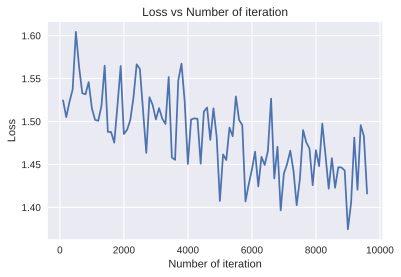

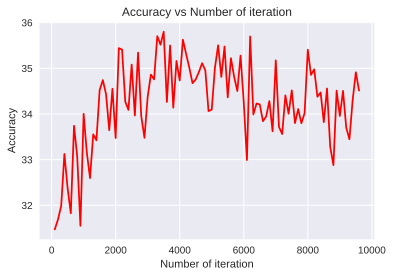

In [92]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [93]:
_ = load_checkpoint('./cnn_best_checkpoint_v5', model_cnn5, optimizer)

Loading checkpoint './cnn_best_checkpoint_v5'
Loaded checkpoint './cnn_best_checkpoint_v5' from iteration 3499


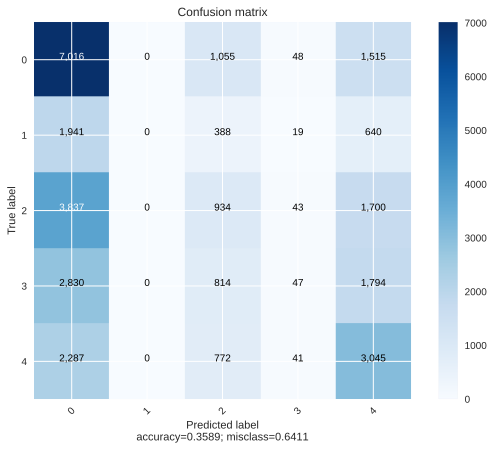

Accuracy: 0.3589 
Balanced accuracy: 0.27515 
Multiclass f1-score: 
    micro: 0.3589 
    macro: 0.22293 
    weighted: 0.28219


Classification report:

              precision    recall  f1-score   support

           0    0.39171   0.72825   0.50942      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.23568   0.14338   0.17830      6514
           3    0.23737   0.00857   0.01654      5485
           4    0.35024   0.49552   0.41041      6145

    accuracy                        0.35890     30766
   macro avg    0.24300   0.27515   0.22293     30766
weighted avg    0.28483   0.35890   0.28219     30766



In [94]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_cnn5(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

## **Pooling слои стандартные**

### максимум по временной компоненте (незавимисо для каждой фичи)

In [37]:
class MaxTimePooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [74]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size*2, kernel_size=2),
            nn.Tanh(),
            nn.Conv1d(hid_size*2, hid_size*2, kernel_size=3),
            nn.LeakyReLU(),
            nn.Conv1d(hid_size*2, hid_size, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),

            nn.Dropout(p=0.25),
            nn.LeakyReLU(),
            MaxTimePooling()
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features = self.joke_encoder(joke_embeddings).squeeze()

        return self.final_predictor(joke_features).squeeze()

In [75]:
model_mtp = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mtp.parameters(), lr=learning_rate)

In [76]:
iteration_list, loss_list, accuracy_list  = train(model_mtp, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_mpt_best_checkpoint",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5930662155151367  Accuracy: 34.64818572998047 %
Saving model and optimizer state at iteration 99 to ./cnn_mpt_best_checkpoint
Iteration: 199  Loss: 1.5805120468139648  Accuracy: 34.3127555847168 %
Iteration: 299  Loss: 1.4928282499313354  Accuracy: 34.20874786376953 %
Iteration: 399  Loss: 1.5414550304412842  Accuracy: 34.12294006347656 %
Iteration: 499  Loss: 1.534339189529419  Accuracy: 34.67158889770508 %
Saving model and optimizer state at iteration 499 to ./cnn_mpt_best_checkpoint
Iteration: 599  Loss: 1.532620906829834  Accuracy: 34.265953063964844 %
Iteration: 699  Loss: 1.5585920810699463  Accuracy: 33.738101959228516 %
Iteration: 799  Loss: 1.509041428565979  Accuracy: 33.631492614746094 %
Iteration: 899  Loss: 1.5225138664245605  Accuracy: 33.433876037597656 %
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.528235912322998  Accuracy: 34.624786376953125 %
Iteration: 1099  Loss: 1.4890412092208862  Accuracy: 33.79010772705078 %
Iteration: 1199  Loss: 1.5216450691223145  Accuracy: 34.62998580932617 %
Iteration: 1299  Loss: 1.484657645225525  Accuracy: 34.51297378540039 %
Iteration: 1399  Loss: 1.5158636569976807  Accuracy: 35.384056091308594 %
Saving model and optimizer state at iteration 1399 to ./cnn_mpt_best_checkpoint
Iteration: 1499  Loss: 1.5461608171463013  Accuracy: 35.10582733154297 %
Iteration: 1599  Loss: 1.4768120050430298  Accuracy: 34.96281433105469 %
Iteration: 1699  Loss: 1.494428277015686  Accuracy: 34.70279312133789 %
Iteration: 1799  Loss: 1.5113627910614014  Accuracy: 34.9758186340332 %
Iteration: 1899  Loss: 1.5223242044448853  Accuracy: 33.93312072753906 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5140619277954102  Accuracy: 35.108428955078125 %
Iteration: 2099  Loss: 1.5095295906066895  Accuracy: 33.58988952636719 %
Iteration: 2199  Loss: 1.5380884408950806  Accuracy: 34.497371673583984 %
Iteration: 2299  Loss: 1.526746392250061  Accuracy: 35.2020378112793 %
Iteration: 2399  Loss: 1.5314996242523193  Accuracy: 35.0278205871582 %
Iteration: 2499  Loss: 1.5023720264434814  Accuracy: 35.410057067871094 %
Saving model and optimizer state at iteration 2499 to ./cnn_mpt_best_checkpoint
Iteration: 2599  Loss: 1.4675589799880981  Accuracy: 35.06422424316406 %
Iteration: 2699  Loss: 1.5162709951400757  Accuracy: 35.50886535644531 %
Saving model and optimizer state at iteration 2699 to ./cnn_mpt_best_checkpoint
Iteration: 2799  Loss: 1.494669795036316  Accuracy: 34.45056915283203 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.4584894180297852  Accuracy: 33.20245361328125 %
Iteration: 2999  Loss: 1.5284934043884277  Accuracy: 34.520774841308594 %
Iteration: 3099  Loss: 1.5365335941314697  Accuracy: 35.61027526855469 %
Saving model and optimizer state at iteration 3099 to ./cnn_mpt_best_checkpoint
Iteration: 3199  Loss: 1.5221232175827026  Accuracy: 35.99251174926758 %
Saving model and optimizer state at iteration 3199 to ./cnn_mpt_best_checkpoint
Iteration: 3299  Loss: 1.5726432800292969  Accuracy: 34.98881912231445 %
Iteration: 3399  Loss: 1.4830597639083862  Accuracy: 34.700191497802734 %
Iteration: 3499  Loss: 1.4778130054473877  Accuracy: 34.939414978027344 %
Iteration: 3599  Loss: 1.5182384252548218  Accuracy: 34.5285758972168 %
Iteration: 3699  Loss: 1.4992717504501343  Accuracy: 35.41265869140625 %
Iteration: 3799  Loss: 1.5532370805740356  Accuracy: 35.50626754760742 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.4161738157272339  Accuracy: 35.12403106689453 %
Iteration: 3999  Loss: 1.4312584400177002  Accuracy: 35.13963317871094 %
Iteration: 4099  Loss: 1.4180012941360474  Accuracy: 35.55567169189453 %
Iteration: 4199  Loss: 1.5174336433410645  Accuracy: 35.493263244628906 %
Iteration: 4299  Loss: 1.5113203525543213  Accuracy: 35.19163513183594 %
Iteration: 4399  Loss: 1.504908800125122  Accuracy: 35.49586486816406 %
Iteration: 4499  Loss: 1.4998008012771606  Accuracy: 35.37885284423828 %
Iteration: 4599  Loss: 1.5002585649490356  Accuracy: 35.43085861206055 %
Iteration: 4699  Loss: 1.4335108995437622  Accuracy: 35.77669143676758 %
Iteration: 4799  Loss: 1.457710862159729  Accuracy: 34.61178207397461 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.506981372833252  Accuracy: 35.563472747802734 %
Iteration: 4999  Loss: 1.4575060606002808  Accuracy: 35.480262756347656 %
Iteration: 5099  Loss: 1.476041316986084  Accuracy: 35.09803009033203 %
Iteration: 5199  Loss: 1.4930124282836914  Accuracy: 33.57948684692383 %
Iteration: 5299  Loss: 1.448300838470459  Accuracy: 35.638877868652344 %
Iteration: 5399  Loss: 1.512000322341919  Accuracy: 34.952415466308594 %
Iteration: 5499  Loss: 1.4682599306106567  Accuracy: 34.45056915283203 %
Iteration: 5599  Loss: 1.4315853118896484  Accuracy: 35.83909606933594 %
Iteration: 5699  Loss: 1.4769833087921143  Accuracy: 35.11623001098633 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.4921479225158691  Accuracy: 36.18232727050781 %
Saving model and optimizer state at iteration 5799 to ./cnn_mpt_best_checkpoint
Iteration: 5899  Loss: 1.4403587579727173  Accuracy: 34.29715347290039 %
Iteration: 5999  Loss: 1.5009390115737915  Accuracy: 34.87180709838867 %
Iteration: 6099  Loss: 1.491353154182434  Accuracy: 34.63258361816406 %
Iteration: 6199  Loss: 1.4856083393096924  Accuracy: 35.31644821166992 %
Iteration: 6299  Loss: 1.4657272100448608  Accuracy: 36.14592361450195 %
Iteration: 6399  Loss: 1.5046684741973877  Accuracy: 35.75068664550781 %
Iteration: 6499  Loss: 1.4836702346801758  Accuracy: 35.144832611083984 %
Iteration: 6599  Loss: 1.4917999505996704  Accuracy: 35.706485748291016 %
Iteration: 6699  Loss: 1.49031662940979  Accuracy: 33.6470947265625 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.4188117980957031  Accuracy: 35.745487213134766 %
Iteration: 6899  Loss: 1.4345232248306274  Accuracy: 35.12923049926758 %
Iteration: 6999  Loss: 1.4732738733291626  Accuracy: 35.287845611572266 %
Iteration: 7099  Loss: 1.4102954864501953  Accuracy: 35.23583984375 %
Iteration: 7199  Loss: 1.485576868057251  Accuracy: 34.968017578125 %
Iteration: 7299  Loss: 1.493591070175171  Accuracy: 35.95350646972656 %
Iteration: 7399  Loss: 1.5204499959945679  Accuracy: 34.91081237792969 %
Iteration: 7499  Loss: 1.53473699092865  Accuracy: 35.32164764404297 %
Iteration: 7599  Loss: 1.4023405313491821  Accuracy: 35.28264617919922 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.4721258878707886  Accuracy: 35.477664947509766 %
Iteration: 7799  Loss: 1.4279000759124756  Accuracy: 35.29304504394531 %
Iteration: 7899  Loss: 1.4020376205444336  Accuracy: 35.67788314819336 %
Iteration: 7999  Loss: 1.4448411464691162  Accuracy: 35.696083068847656 %
Iteration: 8099  Loss: 1.4313277006149292  Accuracy: 36.22393035888672 %
Saving model and optimizer state at iteration 8099 to ./cnn_mpt_best_checkpoint
Iteration: 8199  Loss: 1.4976623058319092  Accuracy: 35.61807632446289 %
Iteration: 8299  Loss: 1.3803112506866455  Accuracy: 35.423057556152344 %
Iteration: 8399  Loss: 1.412536382675171  Accuracy: 35.78969192504883 %
Iteration: 8499  Loss: 1.4365818500518799  Accuracy: 35.82089614868164 %
Iteration: 8599  Loss: 1.3840912580490112  Accuracy: 35.961307525634766 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.4435245990753174  Accuracy: 36.09912109375 %
Iteration: 8799  Loss: 1.4035660028457642  Accuracy: 34.84580612182617 %
Iteration: 8899  Loss: 1.3862171173095703  Accuracy: 35.37885284423828 %
Iteration: 8999  Loss: 1.450945258140564  Accuracy: 35.06682586669922 %
Iteration: 9099  Loss: 1.4438859224319458  Accuracy: 35.23583984375 %
Iteration: 9199  Loss: 1.443118691444397  Accuracy: 34.95761489868164 %
Iteration: 9299  Loss: 1.3646533489227295  Accuracy: 35.516666412353516 %
Iteration: 9399  Loss: 1.3938946723937988  Accuracy: 35.542667388916016 %
Iteration: 9499  Loss: 1.477295994758606  Accuracy: 34.66118621826172 %
Iteration: 9599  Loss: 1.452435851097107  Accuracy: 35.277442932128906 %


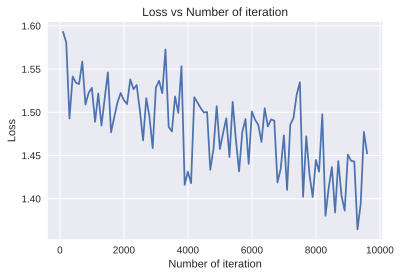

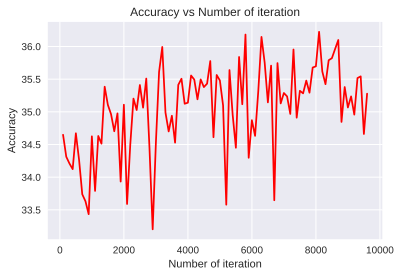

In [77]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [78]:
_ = load_checkpoint('./cnn_mpt_best_checkpoint', model_mtp, optimizer)

Loading checkpoint './cnn_mpt_best_checkpoint'
Loaded checkpoint './cnn_mpt_best_checkpoint' from iteration 8099


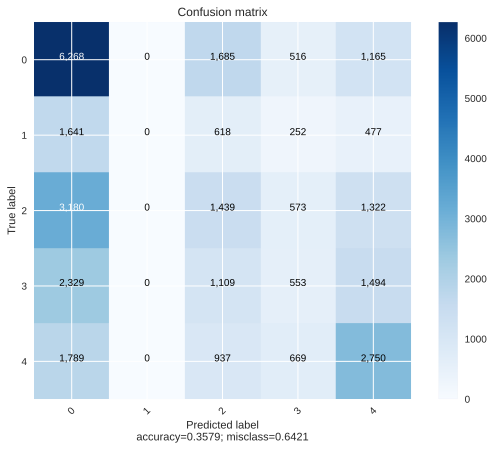

Accuracy: 0.35786 
Balanced accuracy: 0.28397 
Multiclass f1-score: 
    micro: 0.35786 
    macro: 0.25758 
    weighted: 0.31433


Classification report:

              precision    recall  f1-score   support

           0    0.41218   0.65061   0.50465      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.24862   0.22091   0.23395      6514
           3    0.21576   0.10082   0.13743      5485
           4    0.38152   0.44752   0.41189      6145

    accuracy                        0.35786     30766
   macro avg    0.25162   0.28397   0.25758     30766
weighted avg    0.29638   0.35786   0.31433     30766



In [79]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_mtp(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

### **среднее по временной компоненте (исключая PAD символы)**

In [49]:
class TimeAvgPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.mean(dim=self.dim)

In [50]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size*2, kernel_size=2),
            nn.LeakyReLU(),
            nn.Conv1d(hid_size*2, hid_size*2, kernel_size=3),
            nn.LeakyReLU(),
            nn.Conv1d(hid_size*2, hid_size, kernel_size=5),
            nn.LeakyReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),

            nn.Dropout(p=0.25),
            nn.LeakyReLU(),
            TimeAvgPooling()
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features = self.joke_encoder(joke_embeddings).squeeze()

        return self.final_predictor(joke_features).squeeze()

In [51]:
model_map = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_map.parameters(), lr=learning_rate)

In [52]:
iteration_list, loss_list, accuracy_list  = train(model_map, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_map_best_checkpoint_v2",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5791313648223877  Accuracy: 24.109416961669922 %
Saving model and optimizer state at iteration 99 to ./cnn_map_best_checkpoint_v2
Iteration: 199  Loss: 1.5809409618377686  Accuracy: 33.917518615722656 %
Saving model and optimizer state at iteration 199 to ./cnn_map_best_checkpoint_v2
Iteration: 299  Loss: 1.569912314414978  Accuracy: 33.605491638183594 %
Iteration: 399  Loss: 1.5771321058273315  Accuracy: 33.89931869506836 %
Iteration: 499  Loss: 1.5801976919174194  Accuracy: 34.146339416503906 %
Saving model and optimizer state at iteration 499 to ./cnn_map_best_checkpoint_v2
Iteration: 599  Loss: 1.5521060228347778  Accuracy: 34.304954528808594 %
Saving model and optimizer state at iteration 599 to ./cnn_map_best_checkpoint_v2
Iteration: 699  Loss: 1.5680694580078125  Accuracy: 34.33355712890625 %
Saving model and optimizer state at iteration 699 to ./cnn_map_best_checkpoint_v2
Iteration: 799  Loss: 1.5511804819107056  Accuracy: 34.42976760864258 %
Saving model

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.543652057647705  Accuracy: 34.48957061767578 %
Saving model and optimizer state at iteration 999 to ./cnn_map_best_checkpoint_v2
Iteration: 1099  Loss: 1.513948678970337  Accuracy: 21.19194984436035 %
Iteration: 1199  Loss: 1.5376050472259521  Accuracy: 33.92531967163086 %
Iteration: 1299  Loss: 1.5421085357666016  Accuracy: 34.5545768737793 %
Saving model and optimizer state at iteration 1299 to ./cnn_map_best_checkpoint_v2
Iteration: 1399  Loss: 1.4896318912506104  Accuracy: 34.63518524169922 %
Saving model and optimizer state at iteration 1399 to ./cnn_map_best_checkpoint_v2
Iteration: 1499  Loss: 1.507688283920288  Accuracy: 34.53117752075195 %
Iteration: 1599  Loss: 1.528917908668518  Accuracy: 34.56758117675781 %
Iteration: 1699  Loss: 1.5744274854660034  Accuracy: 34.650787353515625 %
Saving model and optimizer state at iteration 1699 to ./cnn_map_best_checkpoint_v2
Iteration: 1799  Loss: 1.5149047374725342  Accuracy: 34.17754364013672 %
Iteration: 1899  

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5209019184112549  Accuracy: 34.637786865234375 %
Iteration: 2099  Loss: 1.4761037826538086  Accuracy: 34.614383697509766 %
Iteration: 2199  Loss: 1.4806822538375854  Accuracy: 34.71579360961914 %
Saving model and optimizer state at iteration 2199 to ./cnn_map_best_checkpoint_v2
Iteration: 2299  Loss: 1.5381038188934326  Accuracy: 34.87700653076172 %
Saving model and optimizer state at iteration 2299 to ./cnn_map_best_checkpoint_v2
Iteration: 2399  Loss: 1.5271986722946167  Accuracy: 34.7781982421875 %
Iteration: 2499  Loss: 1.5217396020889282  Accuracy: 34.39336395263672 %
Iteration: 2599  Loss: 1.5507694482803345  Accuracy: 34.434967041015625 %
Iteration: 2699  Loss: 1.5179466009140015  Accuracy: 34.700191497802734 %
Iteration: 2799  Loss: 1.5296123027801514  Accuracy: 34.939414978027344 %
Saving model and optimizer state at iteration 2799 to ./cnn_map_best_checkpoint_v2
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5093802213668823  Accuracy: 34.830204010009766 %
Iteration: 2999  Loss: 1.5632425546646118  Accuracy: 34.7859992980957 %
Iteration: 3099  Loss: 1.4926598072052002  Accuracy: 34.952415466308594 %
Saving model and optimizer state at iteration 3099 to ./cnn_map_best_checkpoint_v2
Iteration: 3199  Loss: 1.500724196434021  Accuracy: 34.723594665527344 %
Iteration: 3299  Loss: 1.5497910976409912  Accuracy: 34.879608154296875 %
Iteration: 3399  Loss: 1.5091307163238525  Accuracy: 34.91861343383789 %
Iteration: 3499  Loss: 1.51357901096344  Accuracy: 34.916011810302734 %
Iteration: 3599  Loss: 1.5226213932037354  Accuracy: 34.75479507446289 %
Iteration: 3699  Loss: 1.551007866859436  Accuracy: 35.03042221069336 %
Saving model and optimizer state at iteration 3699 to ./cnn_map_best_checkpoint_v2
Iteration: 3799  Loss: 1.5380668640136719  Accuracy: 34.82500457763672 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.4982163906097412  Accuracy: 34.08133316040039 %
Iteration: 3999  Loss: 1.5305633544921875  Accuracy: 35.06682586669922 %
Saving model and optimizer state at iteration 3999 to ./cnn_map_best_checkpoint_v2
Iteration: 4099  Loss: 1.4843391180038452  Accuracy: 35.05122375488281 %
Iteration: 4199  Loss: 1.5143896341323853  Accuracy: 34.996620178222656 %
Iteration: 4299  Loss: 1.536738395690918  Accuracy: 35.06682586669922 %
Iteration: 4399  Loss: 1.5078998804092407  Accuracy: 34.98361587524414 %
Iteration: 4499  Loss: 1.5064911842346191  Accuracy: 35.06422424316406 %
Iteration: 4599  Loss: 1.5155723094940186  Accuracy: 34.87700653076172 %
Iteration: 4699  Loss: 1.4578962326049805  Accuracy: 35.15003204345703 %
Saving model and optimizer state at iteration 4699 to ./cnn_map_best_checkpoint_v2
Iteration: 4799  Loss: 1.4698333740234375  Accuracy: 34.830204010009766 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.4862533807754517  Accuracy: 34.88740921020508 %
Iteration: 4999  Loss: 1.5082234144210815  Accuracy: 35.072025299072266 %
Iteration: 5099  Loss: 1.5171180963516235  Accuracy: 35.08762741088867 %
Iteration: 5199  Loss: 1.5371732711791992  Accuracy: 35.069427490234375 %
Iteration: 5299  Loss: 1.499959945678711  Accuracy: 35.01482009887695 %
Iteration: 5399  Loss: 1.5737643241882324  Accuracy: 35.069427490234375 %
Iteration: 5499  Loss: 1.5211942195892334  Accuracy: 34.804203033447266 %
Iteration: 5599  Loss: 1.4818305969238281  Accuracy: 34.97061538696289 %
Iteration: 5699  Loss: 1.471913456916809  Accuracy: 35.18643569946289 %
Saving model and optimizer state at iteration 5699 to ./cnn_map_best_checkpoint_v2
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.5562891960144043  Accuracy: 35.085025787353516 %
Iteration: 5899  Loss: 1.4797945022583008  Accuracy: 28.57402801513672 %
Iteration: 5999  Loss: 1.5041502714157104  Accuracy: 35.144832611083984 %
Iteration: 6099  Loss: 1.5055346488952637  Accuracy: 35.144832611083984 %
Iteration: 6199  Loss: 1.5440477132797241  Accuracy: 35.25404357910156 %
Saving model and optimizer state at iteration 6199 to ./cnn_map_best_checkpoint_v2
Iteration: 6299  Loss: 1.4897377490997314  Accuracy: 35.157833099365234 %
Iteration: 6399  Loss: 1.4769960641860962  Accuracy: 35.108428955078125 %
Iteration: 6499  Loss: 1.5689283609390259  Accuracy: 34.929012298583984 %
Iteration: 6599  Loss: 1.506423830986023  Accuracy: 34.978416442871094 %
Iteration: 6699  Loss: 1.4973673820495605  Accuracy: 34.94981384277344 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.5188543796539307  Accuracy: 34.96281433105469 %
Iteration: 6899  Loss: 1.4867641925811768  Accuracy: 35.261844635009766 %
Saving model and optimizer state at iteration 6899 to ./cnn_map_best_checkpoint_v2
Iteration: 6999  Loss: 1.5016390085220337  Accuracy: 35.23064041137695 %
Iteration: 7099  Loss: 1.5708476305007935  Accuracy: 35.277442932128906 %
Saving model and optimizer state at iteration 7099 to ./cnn_map_best_checkpoint_v2
Iteration: 7199  Loss: 1.5466868877410889  Accuracy: 34.87440872192383 %
Iteration: 7299  Loss: 1.5211869478225708  Accuracy: 35.0018196105957 %
Iteration: 7399  Loss: 1.4981935024261475  Accuracy: 35.386653900146484 %
Saving model and optimizer state at iteration 7399 to ./cnn_map_best_checkpoint_v2
Iteration: 7499  Loss: 1.4466711282730103  Accuracy: 34.7703971862793 %
Iteration: 7599  Loss: 1.4851560592651367  Accuracy: 34.471370697021484 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.5311899185180664  Accuracy: 35.05642318725586 %
Iteration: 7799  Loss: 1.5234931707382202  Accuracy: 35.33205032348633 %
Iteration: 7899  Loss: 1.5392403602600098  Accuracy: 35.13703155517578 %
Iteration: 7999  Loss: 1.5096319913864136  Accuracy: 33.218055725097656 %
Iteration: 8099  Loss: 1.4919096231460571  Accuracy: 34.968017578125 %
Iteration: 8199  Loss: 1.5134174823760986  Accuracy: 35.069427490234375 %
Iteration: 8299  Loss: 1.4868179559707642  Accuracy: 35.16563415527344 %
Iteration: 8399  Loss: 1.5373666286468506  Accuracy: 35.23324203491211 %
Iteration: 8499  Loss: 1.4900479316711426  Accuracy: 34.76519775390625 %
Iteration: 8599  Loss: 1.4674357175827026  Accuracy: 35.49586486816406 %
Saving model and optimizer state at iteration 8599 to ./cnn_map_best_checkpoint_v2
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.4896111488342285  Accuracy: 34.674190521240234 %
Iteration: 8799  Loss: 1.526236653327942  Accuracy: 35.251441955566406 %
Iteration: 8899  Loss: 1.5360705852508545  Accuracy: 35.01482009887695 %
Iteration: 8999  Loss: 1.5000393390655518  Accuracy: 33.48847961425781 %
Iteration: 9099  Loss: 1.4746108055114746  Accuracy: 35.181236267089844 %
Iteration: 9199  Loss: 1.477059245109558  Accuracy: 35.264442443847656 %
Iteration: 9299  Loss: 1.4888792037963867  Accuracy: 34.819801330566406 %
Iteration: 9399  Loss: 1.487967848777771  Accuracy: 35.09282684326172 %
Iteration: 9499  Loss: 1.5198804140090942  Accuracy: 35.06422424316406 %
Iteration: 9599  Loss: 1.4761574268341064  Accuracy: 34.9940185546875 %


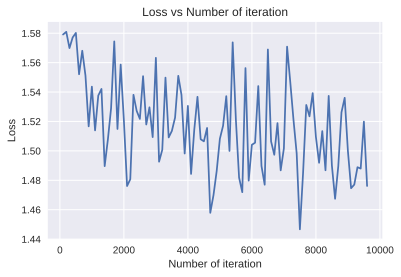

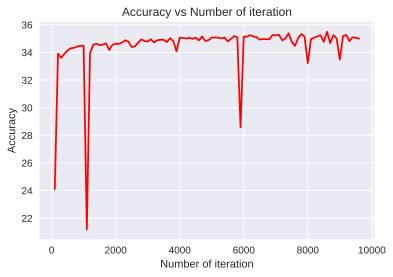

In [53]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [54]:
_ = load_checkpoint('./cnn_map_best_checkpoint_v2', model_map, optimizer)

Loading checkpoint './cnn_map_best_checkpoint_v2'
Loaded checkpoint './cnn_map_best_checkpoint_v2' from iteration 8599


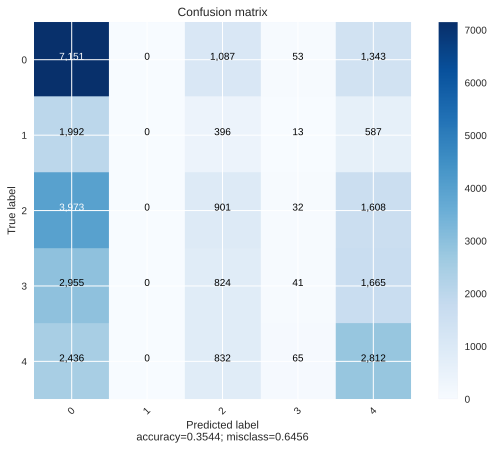

Accuracy: 0.35445 
Balanced accuracy: 0.26913 
Multiclass f1-score: 
    micro: 0.35445 
    macro: 0.21811 
    weighted: 0.27719


Classification report:

              precision    recall  f1-score   support

           0    0.38639   0.74227   0.50823      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.22302   0.13832   0.17074      6514
           3    0.20098   0.00747   0.01441      5485
           4    0.35084   0.45761   0.39718      6145

    accuracy                        0.35445     30766
   macro avg    0.23225   0.26913   0.21811     30766
weighted avg    0.27412   0.35445   0.27719     30766



In [55]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_map(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

**V 2**

In [56]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size*2, kernel_size=2),
            nn.Tanh(),
            nn.Conv1d(hid_size*2, hid_size*2, kernel_size=3),
            nn.Tanh(),
            nn.Conv1d(hid_size*2, hid_size, kernel_size=5),
            nn.ELU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=5),
            nn.ELU(),
            nn.MaxPool1d(2),

            nn.Dropout(p=0.25),
            nn.LeakyReLU(),
            TimeAvgPooling()
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.LeakyReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features = self.joke_encoder(joke_embeddings).squeeze()

        return self.final_predictor(joke_features).squeeze()

In [57]:
model_new_af = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_new_af.parameters(), lr=learning_rate)

In [58]:
iteration_list, loss_list, accuracy_list  = train(model_new_af, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_new_af_best_checkpoint",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.566261887550354  Accuracy: 34.037132263183594 %
Saving model and optimizer state at iteration 99 to ./cnn_new_af_best_checkpoint
Iteration: 199  Loss: 1.557130217552185  Accuracy: 34.18534469604492 %
Saving model and optimizer state at iteration 199 to ./cnn_new_af_best_checkpoint
Iteration: 299  Loss: 1.5545423030853271  Accuracy: 34.33095932006836 %
Saving model and optimizer state at iteration 299 to ./cnn_new_af_best_checkpoint
Iteration: 399  Loss: 1.5182744264602661  Accuracy: 34.375160217285156 %
Saving model and optimizer state at iteration 399 to ./cnn_new_af_best_checkpoint
Iteration: 499  Loss: 1.6140356063842773  Accuracy: 34.39076232910156 %
Saving model and optimizer state at iteration 499 to ./cnn_new_af_best_checkpoint
Iteration: 599  Loss: 1.5930399894714355  Accuracy: 34.34135818481445 %
Iteration: 699  Loss: 1.5460683107376099  Accuracy: 34.52597427368164 %
Saving model and optimizer state at iteration 699 to ./cnn_new_af_best_checkpoint
Iterat

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5385773181915283  Accuracy: 34.53117752075195 %
Iteration: 1099  Loss: 1.5885859727859497  Accuracy: 34.63258361816406 %
Saving model and optimizer state at iteration 1099 to ./cnn_new_af_best_checkpoint
Iteration: 1199  Loss: 1.5538643598556519  Accuracy: 34.676788330078125 %
Saving model and optimizer state at iteration 1199 to ./cnn_new_af_best_checkpoint
Iteration: 1299  Loss: 1.5332574844360352  Accuracy: 34.62998580932617 %
Iteration: 1399  Loss: 1.5503114461898804  Accuracy: 34.55978012084961 %
Iteration: 1499  Loss: 1.5422449111938477  Accuracy: 34.58058166503906 %
Iteration: 1599  Loss: 1.5824472904205322  Accuracy: 34.216548919677734 %
Iteration: 1699  Loss: 1.5272263288497925  Accuracy: 34.74699783325195 %
Saving model and optimizer state at iteration 1699 to ./cnn_new_af_best_checkpoint
Iteration: 1799  Loss: 1.5576701164245605  Accuracy: 34.77299880981445 %
Saving model and optimizer state at iteration 1799 to ./cnn_new_af_best_checkpoint
Iteration:

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5438838005065918  Accuracy: 34.77560043334961 %
Saving model and optimizer state at iteration 1999 to ./cnn_new_af_best_checkpoint
Iteration: 2099  Loss: 1.548921823501587  Accuracy: 34.36476135253906 %
Iteration: 2199  Loss: 1.5460470914840698  Accuracy: 19.722814559936523 %
Iteration: 2299  Loss: 1.562029480934143  Accuracy: 34.8120002746582 %
Saving model and optimizer state at iteration 2299 to ./cnn_new_af_best_checkpoint
Iteration: 2399  Loss: 1.5313470363616943  Accuracy: 20.46128273010254 %
Iteration: 2499  Loss: 1.5389325618743896  Accuracy: 34.69239044189453 %
Iteration: 2599  Loss: 1.597790241241455  Accuracy: 34.830204010009766 %
Saving model and optimizer state at iteration 2599 to ./cnn_new_af_best_checkpoint
Iteration: 2699  Loss: 1.5359933376312256  Accuracy: 34.39076232910156 %
Iteration: 2799  Loss: 1.5559570789337158  Accuracy: 34.676788330078125 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5628408193588257  Accuracy: 34.48697280883789 %
Iteration: 2999  Loss: 1.5421907901763916  Accuracy: 34.564979553222656 %
Iteration: 3099  Loss: 1.5063706636428833  Accuracy: 34.892608642578125 %
Saving model and optimizer state at iteration 3099 to ./cnn_new_af_best_checkpoint
Iteration: 3199  Loss: 1.551166296005249  Accuracy: 35.02522277832031 %
Saving model and optimizer state at iteration 3199 to ./cnn_new_af_best_checkpoint
Iteration: 3299  Loss: 1.5159149169921875  Accuracy: 34.89521026611328 %
Iteration: 3399  Loss: 1.5109552145004272  Accuracy: 34.84060287475586 %
Iteration: 3499  Loss: 1.4930342435836792  Accuracy: 34.96281433105469 %
Iteration: 3599  Loss: 1.5077608823776245  Accuracy: 34.9758186340332 %
Iteration: 3699  Loss: 1.5424754619598389  Accuracy: 34.99921798706055 %
Iteration: 3799  Loss: 1.5285720825195312  Accuracy: 34.955013275146484 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.5304553508758545  Accuracy: 34.736595153808594 %
Iteration: 3999  Loss: 1.523758888244629  Accuracy: 34.601383209228516 %
Iteration: 4099  Loss: 1.4986481666564941  Accuracy: 34.91861343383789 %
Iteration: 4199  Loss: 1.5270451307296753  Accuracy: 34.86400604248047 %
Iteration: 4299  Loss: 1.5222294330596924  Accuracy: 34.892608642578125 %
Iteration: 4399  Loss: 1.5250974893569946  Accuracy: 34.133338928222656 %
Iteration: 4499  Loss: 1.5147199630737305  Accuracy: 35.14223098754883 %
Saving model and optimizer state at iteration 4499 to ./cnn_new_af_best_checkpoint
Iteration: 4599  Loss: 1.5042262077331543  Accuracy: 34.905609130859375 %
Iteration: 4699  Loss: 1.5524327754974365  Accuracy: 35.082427978515625 %
Iteration: 4799  Loss: 1.5146580934524536  Accuracy: 35.12403106689453 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.4979909658432007  Accuracy: 34.90040969848633 %
Iteration: 4999  Loss: 1.5329190492630005  Accuracy: 34.98881912231445 %
Iteration: 5099  Loss: 1.5334829092025757  Accuracy: 35.251441955566406 %
Saving model and optimizer state at iteration 5099 to ./cnn_new_af_best_checkpoint
Iteration: 5199  Loss: 1.5570732355117798  Accuracy: 34.83280563354492 %
Iteration: 5299  Loss: 1.5378056764602661  Accuracy: 34.91341018676758 %
Iteration: 5399  Loss: 1.504070520401001  Accuracy: 34.91341018676758 %
Iteration: 5499  Loss: 1.4432495832443237  Accuracy: 35.046024322509766 %
Iteration: 5599  Loss: 1.4858680963516235  Accuracy: 34.68979263305664 %
Iteration: 5699  Loss: 1.5076146125793457  Accuracy: 20.151853561401367 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.5359553098678589  Accuracy: 34.67158889770508 %
Iteration: 5899  Loss: 1.5467830896377563  Accuracy: 28.594829559326172 %
Iteration: 5999  Loss: 1.4785515069961548  Accuracy: 35.022621154785156 %
Iteration: 6099  Loss: 1.5145273208618164  Accuracy: 35.23064041137695 %
Iteration: 6199  Loss: 1.5549428462982178  Accuracy: 35.10062789916992 %
Iteration: 6299  Loss: 1.5035020112991333  Accuracy: 35.09022903442383 %
Iteration: 6399  Loss: 1.4924886226654053  Accuracy: 34.69758987426758 %
Iteration: 6499  Loss: 1.5532073974609375  Accuracy: 34.93681335449219 %
Iteration: 6599  Loss: 1.4761240482330322  Accuracy: 34.5103759765625 %
Iteration: 6699  Loss: 1.5083556175231934  Accuracy: 34.793800354003906 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.5460416078567505  Accuracy: 35.059024810791016 %
Iteration: 6899  Loss: 1.5068316459655762  Accuracy: 34.942012786865234 %
Iteration: 6999  Loss: 1.484286904335022  Accuracy: 34.93161392211914 %
Iteration: 7099  Loss: 1.5322915315628052  Accuracy: 26.452232360839844 %
Iteration: 7199  Loss: 1.493364930152893  Accuracy: 34.890010833740234 %
Iteration: 7299  Loss: 1.5308047533035278  Accuracy: 35.251441955566406 %
Iteration: 7399  Loss: 1.507947325706482  Accuracy: 34.80160140991211 %
Iteration: 7499  Loss: 1.5210316181182861  Accuracy: 35.24884033203125 %
Iteration: 7599  Loss: 1.4560211896896362  Accuracy: 35.12403106689453 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.4675302505493164  Accuracy: 34.869205474853516 %
Iteration: 7799  Loss: 1.567499041557312  Accuracy: 34.817203521728516 %
Iteration: 7899  Loss: 1.4663150310516357  Accuracy: 35.00442123413086 %
Iteration: 7999  Loss: 1.4674222469329834  Accuracy: 34.82500457763672 %
Iteration: 8099  Loss: 1.459537148475647  Accuracy: 35.287845611572266 %
Saving model and optimizer state at iteration 8099 to ./cnn_new_af_best_checkpoint
Iteration: 8199  Loss: 1.4975087642669678  Accuracy: 35.11623001098633 %
Iteration: 8299  Loss: 1.5259523391723633  Accuracy: 35.033023834228516 %
Iteration: 8399  Loss: 1.5121731758117676  Accuracy: 34.59358215332031 %
Iteration: 8499  Loss: 1.5363380908966064  Accuracy: 35.14223098754883 %
Iteration: 8599  Loss: 1.4791100025177002  Accuracy: 34.65338897705078 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.5417356491088867  Accuracy: 35.07722473144531 %
Iteration: 8799  Loss: 1.5667749643325806  Accuracy: 35.17343521118164 %
Iteration: 8899  Loss: 1.501147747039795  Accuracy: 35.02522277832031 %
Iteration: 8999  Loss: 1.5030606985092163  Accuracy: 33.891517639160156 %
Iteration: 9099  Loss: 1.506314754486084  Accuracy: 34.77299880981445 %
Iteration: 9199  Loss: 1.4973100423812866  Accuracy: 35.2020378112793 %
Iteration: 9299  Loss: 1.5223664045333862  Accuracy: 35.07982635498047 %
Iteration: 9399  Loss: 1.5622406005859375  Accuracy: 35.01742172241211 %
Iteration: 9499  Loss: 1.516671061515808  Accuracy: 35.0018196105957 %
Iteration: 9599  Loss: 1.495261311531067  Accuracy: 34.93681335449219 %


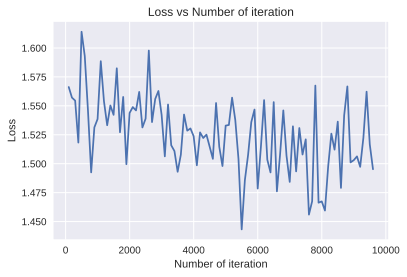

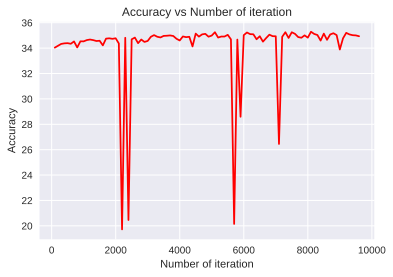

In [59]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [61]:
_ = load_checkpoint('./cnn_new_af_best_checkpoint', model_new_af, optimizer)

Loading checkpoint './cnn_new_af_best_checkpoint'
Loaded checkpoint './cnn_new_af_best_checkpoint' from iteration 8099


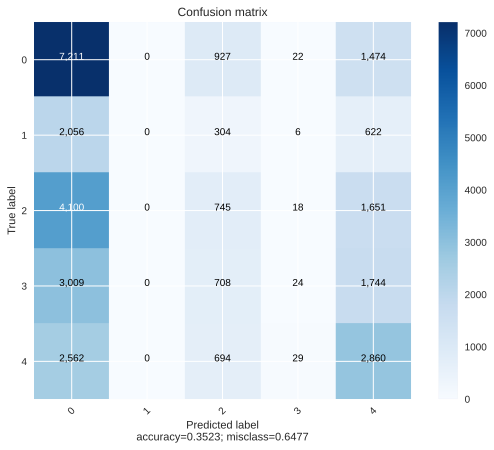

Accuracy: 0.35234 
Balanced accuracy: 0.26653 
Multiclass f1-score: 
    micro: 0.35234 
    macro: 0.21171 
    weighted: 0.2703


Classification report:

              precision    recall  f1-score   support

           0    0.38077   0.74849   0.50476      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.22054   0.11437   0.15063      6514
           3    0.24242   0.00438   0.00860      5485
           4    0.34247   0.46542   0.39459      6145

    accuracy                        0.35234     30766
   macro avg    0.23724   0.26653   0.21171     30766
weighted avg    0.27755   0.35234   0.27030     30766



In [62]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_new_af(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

## **рекуррентные**

### 1) GRU

In [86]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_gru = nn.GRU(hid_size,hid_size, batch_first=True)
        self.dr1 = nn.Dropout(p=0.25)
        self.af1 = nn.LeakyReLU()
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.LeakyReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke'])
        output, hidden_joke = self.joke_gru(joke_embeddings)     
        hidden_joke = torch.cat([hidden_joke[i,:, :] for i in range(hidden_joke.shape[0])], dim=1)
        out_joke = self.dr1(hidden_joke)
        out_joke = self.af1(out_joke)

        return self.final_predictor(out_joke).squeeze()

In [87]:
model_gru = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gru.parameters(), lr=learning_rate)

In [88]:
iteration_list, loss_list, accuracy_list  = train(model_gru, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./gru_best_checkpoint",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.54715096950531  Accuracy: 31.486295700073242 %
Saving model and optimizer state at iteration 99 to ./gru_best_checkpoint
Iteration: 199  Loss: 1.56052827835083  Accuracy: 31.57210350036621 %
Saving model and optimizer state at iteration 199 to ./gru_best_checkpoint
Iteration: 299  Loss: 1.5775822401046753  Accuracy: 23.42035484313965 %
Iteration: 399  Loss: 1.5114229917526245  Accuracy: 30.80503273010254 %
Iteration: 499  Loss: 1.5379019975662231  Accuracy: 33.470279693603516 %
Saving model and optimizer state at iteration 499 to ./gru_best_checkpoint
Iteration: 599  Loss: 1.5366908311843872  Accuracy: 32.437984466552734 %
Iteration: 699  Loss: 1.5338971614837646  Accuracy: 33.52488327026367 %
Saving model and optimizer state at iteration 699 to ./gru_best_checkpoint
Iteration: 799  Loss: 1.5327134132385254  Accuracy: 32.81501770019531 %
Iteration: 899  Loss: 1.5553947687149048  Accuracy: 34.408966064453125 %
Saving model and optimizer state at iteration 899 to .

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5335317850112915  Accuracy: 33.30646514892578 %
Iteration: 1099  Loss: 1.485551357269287  Accuracy: 34.92641067504883 %
Saving model and optimizer state at iteration 1099 to ./gru_best_checkpoint
Iteration: 1199  Loss: 1.4721043109893799  Accuracy: 33.582088470458984 %
Iteration: 1299  Loss: 1.4866933822631836  Accuracy: 34.713191986083984 %
Iteration: 1399  Loss: 1.5114572048187256  Accuracy: 30.36039161682129 %
Iteration: 1499  Loss: 1.5460608005523682  Accuracy: 35.42825698852539 %
Saving model and optimizer state at iteration 1499 to ./gru_best_checkpoint
Iteration: 1599  Loss: 1.5135098695755005  Accuracy: 35.14223098754883 %
Iteration: 1699  Loss: 1.5460423231124878  Accuracy: 35.638877868652344 %
Saving model and optimizer state at iteration 1699 to ./gru_best_checkpoint
Iteration: 1799  Loss: 1.5166264772415161  Accuracy: 35.696083068847656 %
Saving model and optimizer state at iteration 1799 to ./gru_best_checkpoint
Iteration: 1899  Loss: 1.598179817199

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.4904236793518066  Accuracy: 34.726192474365234 %
Iteration: 2099  Loss: 1.47374427318573  Accuracy: 33.76930618286133 %
Iteration: 2199  Loss: 1.5515674352645874  Accuracy: 35.854698181152344 %
Saving model and optimizer state at iteration 2199 to ./gru_best_checkpoint
Iteration: 2299  Loss: 1.5107178688049316  Accuracy: 31.137863159179688 %
Iteration: 2399  Loss: 1.5557148456573486  Accuracy: 33.098445892333984 %
Iteration: 2499  Loss: 1.509960412979126  Accuracy: 35.46206283569336 %
Iteration: 2599  Loss: 1.503857970237732  Accuracy: 35.04342269897461 %
Iteration: 2699  Loss: 1.4865968227386475  Accuracy: 35.74028778076172 %
Iteration: 2799  Loss: 1.5193631649017334  Accuracy: 36.3227424621582 %
Saving model and optimizer state at iteration 2799 to ./gru_best_checkpoint
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5300202369689941  Accuracy: 35.794891357421875 %
Iteration: 2999  Loss: 1.4742892980575562  Accuracy: 35.58687210083008 %
Iteration: 3099  Loss: 1.4516061544418335  Accuracy: 34.86140823364258 %
Iteration: 3199  Loss: 1.5257866382598877  Accuracy: 35.70388412475586 %
Iteration: 3299  Loss: 1.4601430892944336  Accuracy: 34.05533218383789 %
Iteration: 3399  Loss: 1.5118895769119263  Accuracy: 35.42045974731445 %
Iteration: 3499  Loss: 1.5530719757080078  Accuracy: 35.792293548583984 %
Iteration: 3599  Loss: 1.4859826564788818  Accuracy: 35.24884033203125 %
Iteration: 3699  Loss: 1.5193628072738647  Accuracy: 35.885902404785156 %
Iteration: 3799  Loss: 1.49099600315094  Accuracy: 35.441261291503906 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.4781897068023682  Accuracy: 34.955013275146484 %
Iteration: 3999  Loss: 1.4631314277648926  Accuracy: 34.955013275146484 %
Iteration: 4099  Loss: 1.491230845451355  Accuracy: 35.0018196105957 %
Iteration: 4199  Loss: 1.4992097616195679  Accuracy: 34.687191009521484 %
Iteration: 4299  Loss: 1.4671401977539062  Accuracy: 35.15263366699219 %
Iteration: 4399  Loss: 1.4187692403793335  Accuracy: 35.805294036865234 %
Iteration: 4499  Loss: 1.5252412557601929  Accuracy: 35.77149200439453 %
Iteration: 4599  Loss: 1.4351985454559326  Accuracy: 34.180145263671875 %
Iteration: 4699  Loss: 1.5146352052688599  Accuracy: 35.75068664550781 %
Iteration: 4799  Loss: 1.3810243606567383  Accuracy: 35.324249267578125 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.4924442768096924  Accuracy: 34.96281433105469 %
Iteration: 4999  Loss: 1.4024548530578613  Accuracy: 35.01482009887695 %
Iteration: 5099  Loss: 1.4841253757476807  Accuracy: 35.09022903442383 %
Iteration: 5199  Loss: 1.4106098413467407  Accuracy: 35.01482009887695 %
Iteration: 5299  Loss: 1.4419435262680054  Accuracy: 35.31904983520508 %
Iteration: 5399  Loss: 1.466860294342041  Accuracy: 34.91341018676758 %
Iteration: 5499  Loss: 1.4887945652008057  Accuracy: 35.612876892089844 %
Iteration: 5599  Loss: 1.415651559829712  Accuracy: 35.2436408996582 %
Iteration: 5699  Loss: 1.5013933181762695  Accuracy: 34.77299880981445 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.454260230064392  Accuracy: 35.13963317871094 %
Iteration: 5899  Loss: 1.4492731094360352  Accuracy: 35.78709030151367 %
Iteration: 5999  Loss: 1.4795801639556885  Accuracy: 34.73919677734375 %
Iteration: 6099  Loss: 1.4574425220489502  Accuracy: 34.752197265625 %
Iteration: 6199  Loss: 1.414331078529358  Accuracy: 35.48806381225586 %
Iteration: 6299  Loss: 1.4778332710266113  Accuracy: 35.566070556640625 %
Iteration: 6399  Loss: 1.4816293716430664  Accuracy: 34.9862174987793 %
Iteration: 6499  Loss: 1.493308663368225  Accuracy: 35.01482009887695 %
Iteration: 6599  Loss: 1.415246844291687  Accuracy: 35.53746795654297 %
Iteration: 6699  Loss: 1.4515492916107178  Accuracy: 34.57278060913086 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

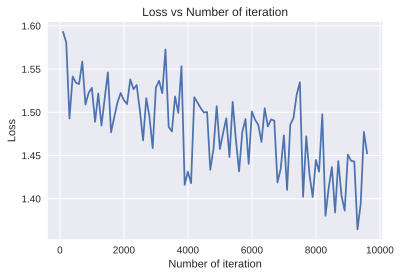

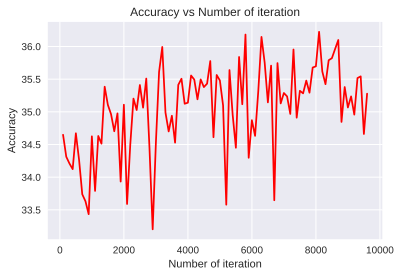

In [89]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [90]:
_ = load_checkpoint('./gru_best_checkpoint', model_gru, optimizer)

Loading checkpoint './gru_best_checkpoint'
Loaded checkpoint './gru_best_checkpoint' from iteration 2799


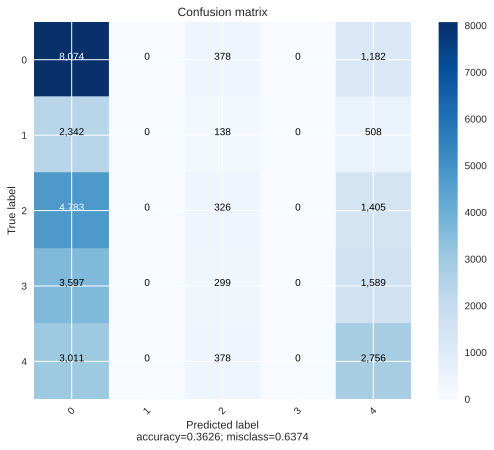

Accuracy: 0.36261 
Balanced accuracy: 0.26732 
Multiclass f1-score: 
    micro: 0.36261 
    macro: 0.2001 
    weighted: 0.25905


Classification report:

              precision    recall  f1-score   support

           0    0.37025   0.83807   0.51360      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.21461   0.05005   0.08117      6514
           3    0.00000   0.00000   0.00000      5485
           4    0.37043   0.44849   0.40574      6145

    accuracy                        0.36261     30766
   macro avg    0.19106   0.26732   0.20010     30766
weighted avg    0.23537   0.36261   0.25905     30766



In [91]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_gru(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

**V 2**

In [109]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_gru = nn.GRU(hid_size,hid_size,  num_layers=2, batch_first=True, dropout=0.2)
        self.dr1 = nn.Dropout(p=0.25)
        self.af1 = nn.LeakyReLU()
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size*2, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.LeakyReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke'])
        output, hidden_joke = self.joke_gru(joke_embeddings)     
        hidden_joke = torch.cat([hidden_joke[i,:, :] for i in range(hidden_joke.shape[0])], dim=1)
        out_joke = self.dr1(hidden_joke)
        out_joke = self.af1(out_joke)

        return self.final_predictor(out_joke).squeeze()

In [110]:
model_gru2 = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gru2.parameters(), lr=learning_rate)

In [111]:
iteration_list, loss_list, accuracy_list  = train(model_gru2, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./gru_best_checkpoint_v2",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5805118083953857  Accuracy: 31.592905044555664 %
Saving model and optimizer state at iteration 99 to ./gru_best_checkpoint_v2
Iteration: 199  Loss: 1.603576898574829  Accuracy: 31.624109268188477 %
Saving model and optimizer state at iteration 199 to ./gru_best_checkpoint_v2
Iteration: 299  Loss: 1.5909209251403809  Accuracy: 31.59550666809082 %
Iteration: 399  Loss: 1.5721232891082764  Accuracy: 32.47958755493164 %
Saving model and optimizer state at iteration 399 to ./gru_best_checkpoint_v2
Iteration: 499  Loss: 1.5667052268981934  Accuracy: 32.042747497558594 %
Iteration: 599  Loss: 1.5461591482162476  Accuracy: 33.07244110107422 %
Saving model and optimizer state at iteration 599 to ./gru_best_checkpoint_v2
Iteration: 699  Loss: 1.5363277196884155  Accuracy: 31.41609001159668 %
Iteration: 799  Loss: 1.5274431705474854  Accuracy: 33.55088424682617 %
Saving model and optimizer state at iteration 799 to ./gru_best_checkpoint_v2
Iteration: 899  Loss: 1.5532194375

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.532888650894165  Accuracy: 34.32575607299805 %
Saving model and optimizer state at iteration 999 to ./gru_best_checkpoint_v2
Iteration: 1099  Loss: 1.548783779144287  Accuracy: 34.38036346435547 %
Saving model and optimizer state at iteration 1099 to ./gru_best_checkpoint_v2
Iteration: 1199  Loss: 1.5181126594543457  Accuracy: 33.74070358276367 %
Iteration: 1299  Loss: 1.4877492189407349  Accuracy: 35.00442123413086 %
Saving model and optimizer state at iteration 1299 to ./gru_best_checkpoint_v2
Iteration: 1399  Loss: 1.5629228353500366  Accuracy: 35.022621154785156 %
Saving model and optimizer state at iteration 1399 to ./gru_best_checkpoint_v2
Iteration: 1499  Loss: 1.510974645614624  Accuracy: 35.20463943481445 %
Saving model and optimizer state at iteration 1499 to ./gru_best_checkpoint_v2
Iteration: 1599  Loss: 1.4882802963256836  Accuracy: 34.49217224121094 %
Iteration: 1699  Loss: 1.512011170387268  Accuracy: 35.035621643066406 %
Iteration: 1799  Loss: 1.

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5099714994430542  Accuracy: 35.12923049926758 %
Iteration: 2099  Loss: 1.489155888557434  Accuracy: 35.33985137939453 %
Iteration: 2199  Loss: 1.5009088516235352  Accuracy: 35.55046844482422 %
Saving model and optimizer state at iteration 2199 to ./gru_best_checkpoint_v2
Iteration: 2299  Loss: 1.5203639268875122  Accuracy: 35.77669143676758 %
Saving model and optimizer state at iteration 2299 to ./gru_best_checkpoint_v2
Iteration: 2399  Loss: 1.533286452293396  Accuracy: 32.271568298339844 %
Iteration: 2499  Loss: 1.4832853078842163  Accuracy: 35.72728729248047 %
Iteration: 2599  Loss: 1.5453542470932007  Accuracy: 36.114723205566406 %
Saving model and optimizer state at iteration 2599 to ./gru_best_checkpoint_v2
Iteration: 2699  Loss: 1.5060491561889648  Accuracy: 35.6414794921875 %
Iteration: 2799  Loss: 1.4662199020385742  Accuracy: 35.97690963745117 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5397796630859375  Accuracy: 35.53487014770508 %
Iteration: 2999  Loss: 1.490946888923645  Accuracy: 35.6934814453125 %
Iteration: 3099  Loss: 1.5392636060714722  Accuracy: 35.696083068847656 %
Iteration: 3199  Loss: 1.4967981576919556  Accuracy: 32.5497932434082 %
Iteration: 3299  Loss: 1.4683527946472168  Accuracy: 33.71730041503906 %
Iteration: 3399  Loss: 1.5466705560684204  Accuracy: 35.97690963745117 %
Iteration: 3499  Loss: 1.5368176698684692  Accuracy: 35.8494987487793 %
Iteration: 3599  Loss: 1.463010549545288  Accuracy: 35.44646072387695 %
Iteration: 3699  Loss: 1.4837008714675903  Accuracy: 35.898902893066406 %
Iteration: 3799  Loss: 1.5187402963638306  Accuracy: 35.44906234741211 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.4136309623718262  Accuracy: 35.91450500488281 %
Iteration: 3999  Loss: 1.480896234512329  Accuracy: 34.76519775390625 %
Iteration: 4099  Loss: 1.4436326026916504  Accuracy: 35.207237243652344 %
Iteration: 4199  Loss: 1.475113868713379  Accuracy: 35.1760368347168 %
Iteration: 4299  Loss: 1.5189118385314941  Accuracy: 35.467262268066406 %
Iteration: 4399  Loss: 1.510072946548462  Accuracy: 35.46986389160156 %
Iteration: 4499  Loss: 1.463387131690979  Accuracy: 35.29564666748047 %
Iteration: 4599  Loss: 1.4810243844985962  Accuracy: 34.91341018676758 %
Iteration: 4699  Loss: 1.4658536911010742  Accuracy: 35.709083557128906 %
Iteration: 4799  Loss: 1.4646896123886108  Accuracy: 35.755889892578125 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.4396567344665527  Accuracy: 33.27526092529297 %
Iteration: 4999  Loss: 1.4155879020690918  Accuracy: 34.843204498291016 %
Iteration: 5099  Loss: 1.386832356452942  Accuracy: 33.99552536010742 %
Iteration: 5199  Loss: 1.4894236326217651  Accuracy: 35.118831634521484 %
Iteration: 5299  Loss: 1.4816335439682007  Accuracy: 34.92381286621094 %
Iteration: 5399  Loss: 1.487357258796692  Accuracy: 35.6934814453125 %
Iteration: 5499  Loss: 1.4223499298095703  Accuracy: 35.24104309082031 %
Iteration: 5599  Loss: 1.433114767074585  Accuracy: 34.3023567199707 %
Iteration: 5699  Loss: 1.5347187519073486  Accuracy: 35.183837890625 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.4711246490478516  Accuracy: 34.819801330566406 %
Iteration: 5899  Loss: 1.4448963403701782  Accuracy: 34.36996078491211 %
Iteration: 5999  Loss: 1.4712320566177368  Accuracy: 34.67158889770508 %
Iteration: 6099  Loss: 1.415196180343628  Accuracy: 34.8120002746582 %
Iteration: 6199  Loss: 1.4182766675949097  Accuracy: 34.67158889770508 %
Iteration: 6299  Loss: 1.5054196119308472  Accuracy: 34.564979553222656 %
Iteration: 6399  Loss: 1.4674830436706543  Accuracy: 34.92641067504883 %
Iteration: 6499  Loss: 1.4674153327941895  Accuracy: 34.182743072509766 %
Iteration: 6599  Loss: 1.4500391483306885  Accuracy: 34.35176086425781 %
Iteration: 6699  Loss: 1.5029596090316772  Accuracy: 35.324249267578125 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.4947295188903809  Accuracy: 35.32685089111328 %
Iteration: 6899  Loss: 1.4044334888458252  Accuracy: 34.53117752075195 %
Iteration: 6999  Loss: 1.5153474807739258  Accuracy: 35.048622131347656 %
Iteration: 7099  Loss: 1.3906946182250977  Accuracy: 34.18794631958008 %
Iteration: 7199  Loss: 1.4061007499694824  Accuracy: 34.43756866455078 %
Iteration: 7299  Loss: 1.4209305047988892  Accuracy: 34.94721603393555 %
Iteration: 7399  Loss: 1.4489431381225586  Accuracy: 35.40485763549805 %
Iteration: 7499  Loss: 1.4990782737731934  Accuracy: 34.916011810302734 %
Iteration: 7599  Loss: 1.4714374542236328  Accuracy: 34.63258361816406 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.482162594795227  Accuracy: 34.98881912231445 %
Iteration: 7799  Loss: 1.4032891988754272  Accuracy: 34.59878158569336 %
Iteration: 7899  Loss: 1.4544860124588013  Accuracy: 34.72879409790039 %
Iteration: 7999  Loss: 1.462235689163208  Accuracy: 34.04753112792969 %
Iteration: 8099  Loss: 1.4695922136306763  Accuracy: 34.75739669799805 %
Iteration: 8199  Loss: 1.453032374382019  Accuracy: 34.879608154296875 %
Iteration: 8299  Loss: 1.4282183647155762  Accuracy: 34.73919677734375 %
Iteration: 8399  Loss: 1.3837960958480835  Accuracy: 35.298248291015625 %
Iteration: 8499  Loss: 1.3645656108856201  Accuracy: 34.762596130371094 %
Iteration: 8599  Loss: 1.4829177856445312  Accuracy: 34.447967529296875 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.4278712272644043  Accuracy: 34.72099304199219 %
Iteration: 8799  Loss: 1.3746540546417236  Accuracy: 34.229549407958984 %
Iteration: 8899  Loss: 1.3665120601654053  Accuracy: 34.81460189819336 %
Iteration: 8999  Loss: 1.482547402381897  Accuracy: 34.70279312133789 %
Iteration: 9099  Loss: 1.4242051839828491  Accuracy: 34.53117752075195 %
Iteration: 9199  Loss: 1.4452219009399414  Accuracy: 35.08762741088867 %
Iteration: 9299  Loss: 1.47587251663208  Accuracy: 34.817203521728516 %
Iteration: 9399  Loss: 1.3561573028564453  Accuracy: 34.60658264160156 %
Iteration: 9499  Loss: 1.447618007659912  Accuracy: 34.375160217285156 %
Iteration: 9599  Loss: 1.3239061832427979  Accuracy: 34.68458938598633 %


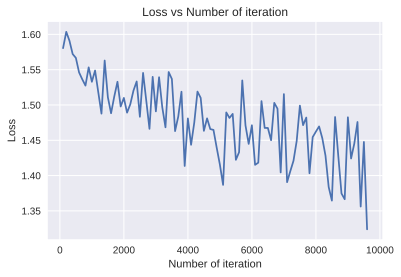

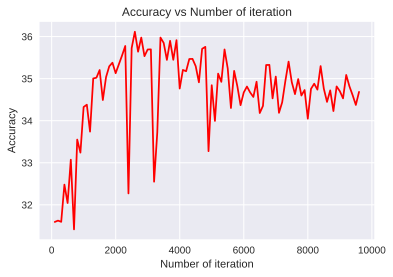

In [112]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [113]:
_ = load_checkpoint('./gru_best_checkpoint_v2', model_gru2, optimizer)

Loading checkpoint './gru_best_checkpoint_v2'
Loaded checkpoint './gru_best_checkpoint_v2' from iteration 2599


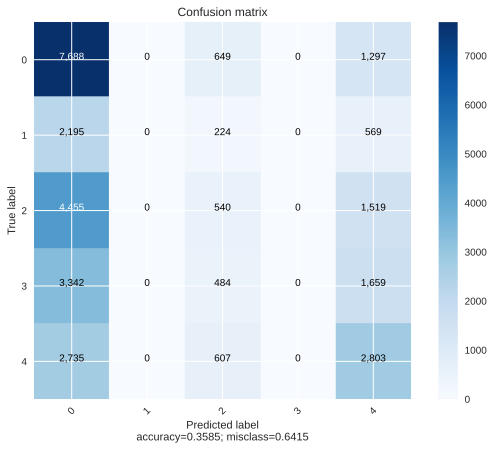

Accuracy: 0.35855 
Balanced accuracy: 0.26741 
Multiclass f1-score: 
    micro: 0.35855 
    macro: 0.20642 
    weighted: 0.26561


Classification report:

              precision    recall  f1-score   support

           0    0.37659   0.79801   0.51170      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.21565   0.08290   0.11976      6514
           3    0.00000   0.00000   0.00000      5485
           4    0.35721   0.45614   0.40066      6145

    accuracy                        0.35855     30766
   macro avg    0.18989   0.26741   0.20642     30766
weighted avg    0.23493   0.35855   0.26561     30766



In [114]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_gru2(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

### **LSTM**

In [136]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_lstm = nn.LSTM(
                                hid_size,
                                hid_size, 
                                dropout=0.2,
                                batch_first=True)
        
        self.dr1 = nn.Dropout(p=0.25)
        self.af1 = nn.LeakyReLU()
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.LeakyReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke'])
        output, (h_n_joke, c_n_joke) = self.joke_lstm(joke_embeddings)     
        h_n_joke = torch.squeeze(h_n_joke, 0)
        out_joke = self.dr1(h_n_joke)
        out_joke = self.af1(out_joke)
        return self.final_predictor(out_joke).squeeze()

In [137]:
model_lstm = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

In [138]:
iteration_list, loss_list, accuracy_list  = train(model_lstm, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./lstm_best_checkpoint",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.6062350273132324  Accuracy: 31.475894927978516 %
Saving model and optimizer state at iteration 99 to ./lstm_best_checkpoint
Iteration: 199  Loss: 1.5729807615280151  Accuracy: 31.551301956176758 %
Saving model and optimizer state at iteration 199 to ./lstm_best_checkpoint
Iteration: 299  Loss: 1.5455455780029297  Accuracy: 31.598106384277344 %
Saving model and optimizer state at iteration 299 to ./lstm_best_checkpoint
Iteration: 399  Loss: 1.5404311418533325  Accuracy: 31.57210350036621 %
Iteration: 499  Loss: 1.5699790716171265  Accuracy: 31.582504272460938 %
Iteration: 599  Loss: 1.5452677011489868  Accuracy: 31.600706100463867 %
Saving model and optimizer state at iteration 599 to ./lstm_best_checkpoint
Iteration: 699  Loss: 1.6021116971969604  Accuracy: 31.566904067993164 %
Iteration: 799  Loss: 1.554613709449768  Accuracy: 31.579904556274414 %
Iteration: 899  Loss: 1.5563448667526245  Accuracy: 31.598106384277344 %
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5484116077423096  Accuracy: 31.605907440185547 %
Saving model and optimizer state at iteration 999 to ./lstm_best_checkpoint
Iteration: 1099  Loss: 1.55630624294281  Accuracy: 31.582504272460938 %
Iteration: 1199  Loss: 1.5889936685562134  Accuracy: 31.603307723999023 %
Iteration: 1299  Loss: 1.6195002794265747  Accuracy: 31.582504272460938 %
Iteration: 1399  Loss: 1.573984980583191  Accuracy: 31.574705123901367 %
Iteration: 1499  Loss: 1.555212378501892  Accuracy: 31.62150764465332 %
Saving model and optimizer state at iteration 1499 to ./lstm_best_checkpoint
Iteration: 1599  Loss: 1.5789016485214233  Accuracy: 31.63970947265625 %
Saving model and optimizer state at iteration 1599 to ./lstm_best_checkpoint
Iteration: 1699  Loss: 1.580807089805603  Accuracy: 29.712932586669922 %
Iteration: 1799  Loss: 1.5906070470809937  Accuracy: 33.08024215698242 %
Saving model and optimizer state at iteration 1799 to ./lstm_best_checkpoint
Iteration: 1899  Loss: 1.55578613281

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.514653205871582  Accuracy: 33.27526092529297 %
Iteration: 2099  Loss: 1.510283350944519  Accuracy: 33.76670455932617 %
Saving model and optimizer state at iteration 2099 to ./lstm_best_checkpoint
Iteration: 2199  Loss: 1.5562407970428467  Accuracy: 33.68349838256836 %
Iteration: 2299  Loss: 1.5852174758911133  Accuracy: 31.2808780670166 %
Iteration: 2399  Loss: 1.5495685338974  Accuracy: 33.39227294921875 %
Iteration: 2499  Loss: 1.551132082939148  Accuracy: 33.90711975097656 %
Saving model and optimizer state at iteration 2499 to ./lstm_best_checkpoint
Iteration: 2599  Loss: 1.5005260705947876  Accuracy: 34.64818572998047 %
Saving model and optimizer state at iteration 2599 to ./lstm_best_checkpoint
Iteration: 2699  Loss: 1.549881935119629  Accuracy: 34.5701789855957 %
Iteration: 2799  Loss: 1.4913225173950195  Accuracy: 34.991416931152344 %
Saving model and optimizer state at iteration 2799 to ./lstm_best_checkpoint
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.51724112033844  Accuracy: 34.61958312988281 %
Iteration: 2999  Loss: 1.491796851158142  Accuracy: 35.09282684326172 %
Saving model and optimizer state at iteration 2999 to ./lstm_best_checkpoint
Iteration: 3099  Loss: 1.4953685998916626  Accuracy: 34.804203033447266 %
Iteration: 3199  Loss: 1.491955280303955  Accuracy: 35.25924301147461 %
Saving model and optimizer state at iteration 3199 to ./lstm_best_checkpoint
Iteration: 3299  Loss: 1.517574429512024  Accuracy: 35.2436408996582 %
Iteration: 3399  Loss: 1.5219210386276245  Accuracy: 34.674190521240234 %
Iteration: 3499  Loss: 1.5333112478256226  Accuracy: 33.712100982666016 %
Iteration: 3599  Loss: 1.5471692085266113  Accuracy: 35.287845611572266 %
Saving model and optimizer state at iteration 3599 to ./lstm_best_checkpoint
Iteration: 3699  Loss: 1.5310709476470947  Accuracy: 35.264442443847656 %
Iteration: 3799  Loss: 1.5194841623306274  Accuracy: 35.09282684326172 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.506432056427002  Accuracy: 35.20463943481445 %
Iteration: 3999  Loss: 1.5412237644195557  Accuracy: 35.49586486816406 %
Saving model and optimizer state at iteration 3999 to ./lstm_best_checkpoint
Iteration: 4099  Loss: 1.448381781578064  Accuracy: 35.28524398803711 %
Iteration: 4199  Loss: 1.5601418018341064  Accuracy: 35.40745544433594 %
Iteration: 4299  Loss: 1.4869743585586548  Accuracy: 35.386653900146484 %
Iteration: 4399  Loss: 1.5396020412445068  Accuracy: 35.35285186767578 %
Iteration: 4499  Loss: 1.4903497695922852  Accuracy: 34.5025749206543 %
Iteration: 4599  Loss: 1.5121073722839355  Accuracy: 35.670082092285156 %
Saving model and optimizer state at iteration 4599 to ./lstm_best_checkpoint
Iteration: 4699  Loss: 1.4661505222320557  Accuracy: 35.23324203491211 %
Iteration: 4799  Loss: 1.5167540311813354  Accuracy: 35.563472747802734 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.470820665359497  Accuracy: 35.38925552368164 %
Iteration: 4999  Loss: 1.4698753356933594  Accuracy: 35.553070068359375 %
Iteration: 5099  Loss: 1.545462727546692  Accuracy: 35.386653900146484 %
Iteration: 5199  Loss: 1.4429374933242798  Accuracy: 35.50106430053711 %
Iteration: 5299  Loss: 1.4927480220794678  Accuracy: 35.13703155517578 %
Iteration: 5399  Loss: 1.5350561141967773  Accuracy: 35.52446746826172 %
Iteration: 5499  Loss: 1.4888923168182373  Accuracy: 35.467262268066406 %
Iteration: 5599  Loss: 1.471696376800537  Accuracy: 35.25664138793945 %
Iteration: 5699  Loss: 1.5251606702804565  Accuracy: 34.603981018066406 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.4663934707641602  Accuracy: 35.490665435791016 %
Iteration: 5899  Loss: 1.495944619178772  Accuracy: 35.0018196105957 %
Iteration: 5999  Loss: 1.492587924003601  Accuracy: 33.28565979003906 %
Iteration: 6099  Loss: 1.4456186294555664  Accuracy: 34.03192901611328 %
Iteration: 6199  Loss: 1.5034507513046265  Accuracy: 33.17645263671875 %
Iteration: 6299  Loss: 1.539991855621338  Accuracy: 35.02001953125 %
Iteration: 6399  Loss: 1.5108299255371094  Accuracy: 34.804203033447266 %
Iteration: 6499  Loss: 1.4543296098709106  Accuracy: 34.546775817871094 %
Iteration: 6599  Loss: 1.5241954326629639  Accuracy: 35.02522277832031 %
Iteration: 6699  Loss: 1.4815512895584106  Accuracy: 35.01742172241211 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.4921241998672485  Accuracy: 34.47397232055664 %
Iteration: 6899  Loss: 1.5490354299545288  Accuracy: 34.195743560791016 %
Iteration: 6999  Loss: 1.4609768390655518  Accuracy: 34.46356964111328 %
Iteration: 7099  Loss: 1.5128350257873535  Accuracy: 35.035621643066406 %
Iteration: 7199  Loss: 1.489224910736084  Accuracy: 34.3127555847168 %
Iteration: 7299  Loss: 1.5150587558746338  Accuracy: 34.90040969848633 %
Iteration: 7399  Loss: 1.4166699647903442  Accuracy: 34.676788330078125 %
Iteration: 7499  Loss: 1.4632887840270996  Accuracy: 35.022621154785156 %
Iteration: 7599  Loss: 1.4241448640823364  Accuracy: 34.90040969848633 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.5288734436035156  Accuracy: 33.940921783447266 %
Iteration: 7799  Loss: 1.43532395362854  Accuracy: 34.03192901611328 %
Iteration: 7899  Loss: 1.5217170715332031  Accuracy: 34.90040969848633 %
Iteration: 7999  Loss: 1.480599045753479  Accuracy: 34.06053161621094 %
Iteration: 8099  Loss: 1.4638831615447998  Accuracy: 34.35176086425781 %
Iteration: 8199  Loss: 1.4241254329681396  Accuracy: 34.30755615234375 %
Iteration: 8299  Loss: 1.4541548490524292  Accuracy: 34.38296127319336 %
Iteration: 8399  Loss: 1.4755725860595703  Accuracy: 34.61178207397461 %
Iteration: 8499  Loss: 1.5323364734649658  Accuracy: 34.291954040527344 %
Iteration: 8599  Loss: 1.4790253639221191  Accuracy: 34.83540344238281 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

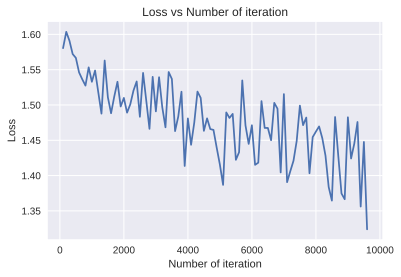

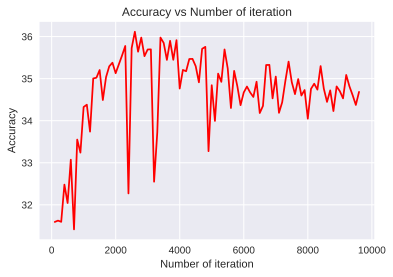

In [141]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [140]:
_ = load_checkpoint('./lstm_best_checkpoint', model_lstm, optimizer)

Loading checkpoint './lstm_best_checkpoint'
Loaded checkpoint './lstm_best_checkpoint' from iteration 4599


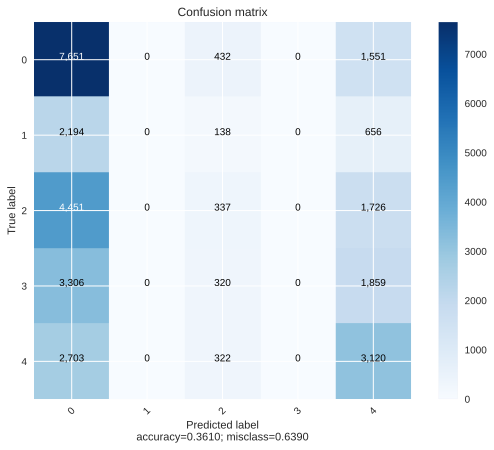

Accuracy: 0.36105 
Balanced accuracy: 0.27073 
Multiclass f1-score: 
    micro: 0.36105 
    macro: 0.20182 
    weighted: 0.26052


Classification report:

              precision    recall  f1-score   support

           0    0.37680   0.79417   0.51111      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.21756   0.05173   0.08359      6514
           3    0.00000   0.00000   0.00000      5485
           4    0.35009   0.50773   0.41443      6145

    accuracy                        0.36105     30766
   macro avg    0.18889   0.27073   0.20182     30766
weighted avg    0.23398   0.36105   0.26052     30766



In [142]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_lstm(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

**V 2**

In [149]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=128):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_lstm = nn.LSTM(
                                hid_size,
                                hid_size, 
                                dropout=0.2,
                                batch_first=True)
        
        self.dr1 = nn.Dropout(p=0.25)
        self.af1 = nn.Tanh()
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.LeakyReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke'])
        output, (h_n_joke, c_n_joke) = self.joke_lstm(joke_embeddings)     
        h_n_joke = torch.squeeze(h_n_joke, 0)
        out_joke = self.dr1(h_n_joke)
        out_joke = self.af1(out_joke)
        return self.final_predictor(out_joke).squeeze()

In [152]:
model_lstm_v2 = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm_v2.parameters(), lr=learning_rate)

In [153]:
iteration_list, loss_list, accuracy_list  = train(model_lstm_v2, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./lstm_best_checkpoint_v2",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5613315105438232  Accuracy: 31.569503784179688 %
Saving model and optimizer state at iteration 99 to ./lstm_best_checkpoint_v2
Iteration: 199  Loss: 1.5666999816894531  Accuracy: 31.582504272460938 %
Saving model and optimizer state at iteration 199 to ./lstm_best_checkpoint_v2
Iteration: 299  Loss: 1.5530506372451782  Accuracy: 31.55390167236328 %
Iteration: 399  Loss: 1.5709882974624634  Accuracy: 31.582504272460938 %
Iteration: 499  Loss: 1.5400450229644775  Accuracy: 31.616308212280273 %
Saving model and optimizer state at iteration 499 to ./lstm_best_checkpoint_v2
Iteration: 599  Loss: 1.590937852859497  Accuracy: 31.603307723999023 %
Iteration: 699  Loss: 1.5768671035766602  Accuracy: 31.611106872558594 %
Iteration: 799  Loss: 1.555399775505066  Accuracy: 31.587705612182617 %
Iteration: 899  Loss: 1.5619922876358032  Accuracy: 31.587705612182617 %
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5320860147476196  Accuracy: 32.9736328125 %
Saving model and optimizer state at iteration 999 to ./lstm_best_checkpoint_v2
Iteration: 1099  Loss: 1.5354009866714478  Accuracy: 32.49778747558594 %
Iteration: 1199  Loss: 1.582021713256836  Accuracy: 33.509281158447266 %
Saving model and optimizer state at iteration 1199 to ./lstm_best_checkpoint_v2
Iteration: 1299  Loss: 1.543871521949768  Accuracy: 33.6808967590332 %
Saving model and optimizer state at iteration 1299 to ./lstm_best_checkpoint_v2
Iteration: 1399  Loss: 1.547357439994812  Accuracy: 33.41827392578125 %
Iteration: 1499  Loss: 1.5805915594100952  Accuracy: 33.98772430419922 %
Saving model and optimizer state at iteration 1499 to ./lstm_best_checkpoint_v2
Iteration: 1599  Loss: 1.5440765619277954  Accuracy: 34.24774932861328 %
Saving model and optimizer state at iteration 1599 to ./lstm_best_checkpoint_v2
Iteration: 1699  Loss: 1.5655564069747925  Accuracy: 34.66898727416992 %
Saving model and optimize

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5268795490264893  Accuracy: 34.35696029663086 %
Iteration: 2099  Loss: 1.4906388521194458  Accuracy: 34.47917175292969 %
Iteration: 2199  Loss: 1.5587782859802246  Accuracy: 34.5025749206543 %
Iteration: 2299  Loss: 1.5144420862197876  Accuracy: 33.50148010253906 %
Iteration: 2399  Loss: 1.5341565608978271  Accuracy: 34.5701789855957 %
Iteration: 2499  Loss: 1.5291792154312134  Accuracy: 35.27224349975586 %
Saving model and optimizer state at iteration 2499 to ./lstm_best_checkpoint_v2
Iteration: 2599  Loss: 1.5193371772766113  Accuracy: 35.40485763549805 %
Saving model and optimizer state at iteration 2599 to ./lstm_best_checkpoint_v2
Iteration: 2699  Loss: 1.523000717163086  Accuracy: 35.480262756347656 %
Saving model and optimizer state at iteration 2699 to ./lstm_best_checkpoint_v2
Iteration: 2799  Loss: 1.479217529296875  Accuracy: 34.663787841796875 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.4838571548461914  Accuracy: 34.46356964111328 %
Iteration: 2999  Loss: 1.4869623184204102  Accuracy: 35.4438591003418 %
Iteration: 3099  Loss: 1.510486364364624  Accuracy: 35.612876892089844 %
Saving model and optimizer state at iteration 3099 to ./lstm_best_checkpoint_v2
Iteration: 3199  Loss: 1.4806526899337769  Accuracy: 34.650787353515625 %
Iteration: 3299  Loss: 1.4966799020767212  Accuracy: 34.70799255371094 %
Iteration: 3399  Loss: 1.5415998697280884  Accuracy: 35.69868469238281 %
Saving model and optimizer state at iteration 3399 to ./lstm_best_checkpoint_v2
Iteration: 3499  Loss: 1.5103142261505127  Accuracy: 33.97992706298828 %
Iteration: 3599  Loss: 1.4788403511047363  Accuracy: 35.220237731933594 %
Iteration: 3699  Loss: 1.4514552354812622  Accuracy: 33.93832015991211 %
Iteration: 3799  Loss: 1.4991934299468994  Accuracy: 35.009620666503906 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.4963760375976562  Accuracy: 35.337249755859375 %
Iteration: 3999  Loss: 1.507683277130127  Accuracy: 35.50106430053711 %
Iteration: 4099  Loss: 1.4671627283096313  Accuracy: 35.59467315673828 %
Iteration: 4199  Loss: 1.4835858345031738  Accuracy: 35.04342269897461 %
Iteration: 4299  Loss: 1.5481327772140503  Accuracy: 35.61027526855469 %
Iteration: 4399  Loss: 1.503670573234558  Accuracy: 34.40636444091797 %
Iteration: 4499  Loss: 1.4487100839614868  Accuracy: 35.76108932495117 %
Saving model and optimizer state at iteration 4499 to ./lstm_best_checkpoint_v2
Iteration: 4599  Loss: 1.4868217706680298  Accuracy: 35.22283935546875 %
Iteration: 4699  Loss: 1.5198575258255005  Accuracy: 34.349159240722656 %
Iteration: 4799  Loss: 1.4903655052185059  Accuracy: 35.251441955566406 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.4485960006713867  Accuracy: 34.991416931152344 %
Iteration: 4999  Loss: 1.5397708415985107  Accuracy: 35.4334602355957 %
Iteration: 5099  Loss: 1.5107877254486084  Accuracy: 35.63107681274414 %
Iteration: 5199  Loss: 1.5098061561584473  Accuracy: 35.59987258911133 %
Iteration: 5299  Loss: 1.45360267162323  Accuracy: 34.79899978637695 %
Iteration: 5399  Loss: 1.4982467889785767  Accuracy: 35.085025787353516 %
Iteration: 5499  Loss: 1.5013575553894043  Accuracy: 35.118831634521484 %
Iteration: 5599  Loss: 1.4815808534622192  Accuracy: 35.274845123291016 %
Iteration: 5699  Loss: 1.46587073802948  Accuracy: 35.454261779785156 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.4319045543670654  Accuracy: 35.35545349121094 %
Iteration: 5899  Loss: 1.4572852849960327  Accuracy: 34.359561920166016 %
Iteration: 5999  Loss: 1.4134773015975952  Accuracy: 35.131832122802734 %
Iteration: 6099  Loss: 1.4299683570861816  Accuracy: 34.903011322021484 %
Iteration: 6199  Loss: 1.4617459774017334  Accuracy: 35.30344772338867 %
Iteration: 6299  Loss: 1.476668357849121  Accuracy: 34.35696029663086 %
Iteration: 6399  Loss: 1.4649035930633545  Accuracy: 34.86140823364258 %
Iteration: 6499  Loss: 1.5210332870483398  Accuracy: 34.104736328125 %
Iteration: 6599  Loss: 1.4937777519226074  Accuracy: 34.9758186340332 %
Iteration: 6699  Loss: 1.4810045957565308  Accuracy: 34.991416931152344 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.4519023895263672  Accuracy: 33.81351089477539 %
Iteration: 6899  Loss: 1.4441277980804443  Accuracy: 34.52597427368164 %
Iteration: 6999  Loss: 1.470115065574646  Accuracy: 35.43865966796875 %
Iteration: 7099  Loss: 1.4966648817062378  Accuracy: 34.91081237792969 %
Iteration: 7199  Loss: 1.515974521636963  Accuracy: 34.70279312133789 %
Iteration: 7299  Loss: 1.459839105606079  Accuracy: 34.3387565612793 %
Iteration: 7399  Loss: 1.529923915863037  Accuracy: 35.0278205871582 %
Iteration: 7499  Loss: 1.4845244884490967  Accuracy: 35.18903732299805 %
Iteration: 7599  Loss: 1.5305472612380981  Accuracy: 34.98361587524414 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.4254469871520996  Accuracy: 35.0018196105957 %
Iteration: 7799  Loss: 1.4894553422927856  Accuracy: 34.736595153808594 %
Iteration: 7899  Loss: 1.5214914083480835  Accuracy: 34.83800506591797 %
Iteration: 7999  Loss: 1.5067416429519653  Accuracy: 35.048622131347656 %
Iteration: 8099  Loss: 1.4229758977890015  Accuracy: 34.676788330078125 %
Iteration: 8199  Loss: 1.4316082000732422  Accuracy: 34.37776184082031 %
Iteration: 8299  Loss: 1.433012843132019  Accuracy: 35.144832611083984 %
Iteration: 8399  Loss: 1.5118987560272217  Accuracy: 35.022621154785156 %
Iteration: 8499  Loss: 1.519359827041626  Accuracy: 34.23994827270508 %
Iteration: 8599  Loss: 1.4350019693374634  Accuracy: 34.68458938598633 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.4555104970932007  Accuracy: 34.26074981689453 %
Iteration: 8799  Loss: 1.4515489339828491  Accuracy: 34.411563873291016 %
Iteration: 8899  Loss: 1.4258853197097778  Accuracy: 34.54937744140625 %
Iteration: 8999  Loss: 1.4366445541381836  Accuracy: 33.592491149902344 %
Iteration: 9099  Loss: 1.4296380281448364  Accuracy: 34.349159240722656 %
Iteration: 9199  Loss: 1.4526113271713257  Accuracy: 34.45317077636719 %
Iteration: 9299  Loss: 1.4217396974563599  Accuracy: 34.551979064941406 %
Iteration: 9399  Loss: 1.4419080018997192  Accuracy: 34.79640197753906 %
Iteration: 9499  Loss: 1.4189170598983765  Accuracy: 34.663787841796875 %
Iteration: 9599  Loss: 1.4322586059570312  Accuracy: 34.73919677734375 %


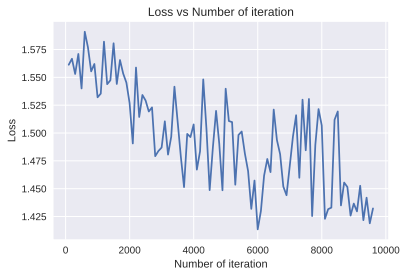

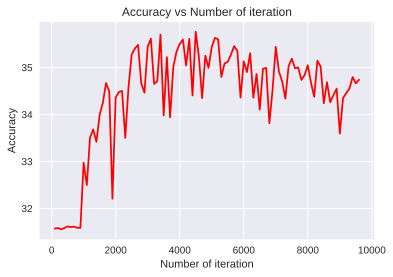

In [154]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [155]:
_ = load_checkpoint('./lstm_best_checkpoint_v2', model_lstm_v2, optimizer)

Loading checkpoint './lstm_best_checkpoint_v2'
Loaded checkpoint './lstm_best_checkpoint_v2' from iteration 4499


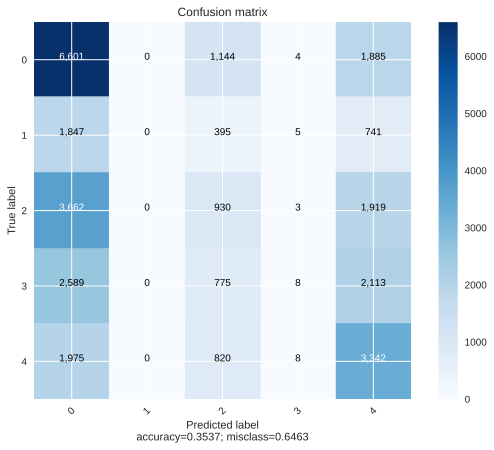

Accuracy: 0.35367 
Balanced accuracy: 0.27465 
Multiclass f1-score: 
    micro: 0.35367 
    macro: 0.21891 
    weighted: 0.27758


Classification report:

              precision    recall  f1-score   support

           0    0.39589   0.68518   0.50182      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.22884   0.14277   0.17584      6514
           3    0.28571   0.00146   0.00290      5485
           4    0.33420   0.54386   0.41400      6145

    accuracy                        0.35367     30766
   macro avg    0.24893   0.27465   0.21891     30766
weighted avg    0.29011   0.35367   0.27758     30766



In [156]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_lstm_v2(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

**V 3**

In [196]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=32):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_lstm = nn.LSTM(
                                hid_size,
                                hid_size, 
                                 num_layers=3,
                                dropout=0.2,
                                batch_first=True)
        
        self.dr1 = nn.Dropout(p=0.25)
        self.af1 = nn.LeakyReLU()
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size*3, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.LeakyReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke'])
        output, (h_n_joke, c_n_joke) = self.joke_lstm(joke_embeddings)     
        h_n_joke = torch.cat([h_n_joke[i,:, :] for i in range(h_n_joke.shape[0])], dim=1)
        

        out_joke = self.dr1(h_n_joke)
        out_joke = self.af1(out_joke)
        return self.final_predictor(out_joke).squeeze()

In [197]:
model_lstm_v3 = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm_v3.parameters(), lr=learning_rate)

In [198]:
iteration_list, loss_list, accuracy_list  = train(model_lstm_v3, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./lstm_best_checkpoint_v3",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5324580669403076  Accuracy: 31.473295211791992 %
Saving model and optimizer state at iteration 99 to ./lstm_best_checkpoint_v3
Iteration: 199  Loss: 1.549966812133789  Accuracy: 31.473295211791992 %
Iteration: 299  Loss: 1.5819637775421143  Accuracy: 31.525299072265625 %
Saving model and optimizer state at iteration 299 to ./lstm_best_checkpoint_v3
Iteration: 399  Loss: 1.6046428680419922  Accuracy: 31.59550666809082 %
Saving model and optimizer state at iteration 399 to ./lstm_best_checkpoint_v3
Iteration: 499  Loss: 1.5317591428756714  Accuracy: 31.564302444458008 %
Iteration: 599  Loss: 1.5811773538589478  Accuracy: 31.57210350036621 %
Iteration: 699  Loss: 1.5319141149520874  Accuracy: 31.61370849609375 %
Saving model and optimizer state at iteration 699 to ./lstm_best_checkpoint_v3
Iteration: 799  Loss: 1.546391248703003  Accuracy: 31.585105895996094 %
Iteration: 899  Loss: 1.555885910987854  Accuracy: 31.57730484008789 %
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5873241424560547  Accuracy: 31.543500900268555 %
Iteration: 1099  Loss: 1.578312873840332  Accuracy: 31.592905044555664 %
Iteration: 1199  Loss: 1.5532212257385254  Accuracy: 31.582504272460938 %
Iteration: 1299  Loss: 1.5949066877365112  Accuracy: 31.579904556274414 %
Iteration: 1399  Loss: 1.5675567388534546  Accuracy: 31.57730484008789 %
Iteration: 1499  Loss: 1.5622243881225586  Accuracy: 31.59030532836914 %
Iteration: 1599  Loss: 1.5469069480895996  Accuracy: 31.57210350036621 %
Iteration: 1699  Loss: 1.578004240989685  Accuracy: 31.616308212280273 %
Saving model and optimizer state at iteration 1699 to ./lstm_best_checkpoint_v3
Iteration: 1799  Loss: 1.5772790908813477  Accuracy: 31.624109268188477 %
Saving model and optimizer state at iteration 1799 to ./lstm_best_checkpoint_v3
Iteration: 1899  Loss: 1.5889984369277954  Accuracy: 31.618907928466797 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.575277328491211  Accuracy: 31.579904556274414 %
Iteration: 2099  Loss: 1.5885473489761353  Accuracy: 31.629308700561523 %
Saving model and optimizer state at iteration 2099 to ./lstm_best_checkpoint_v3
Iteration: 2199  Loss: 1.6290662288665771  Accuracy: 31.574705123901367 %
Iteration: 2299  Loss: 1.5691784620285034  Accuracy: 31.59030532836914 %
Iteration: 2399  Loss: 1.5757057666778564  Accuracy: 31.618907928466797 %
Iteration: 2499  Loss: 1.5536129474639893  Accuracy: 31.585105895996094 %
Iteration: 2599  Loss: 1.5586422681808472  Accuracy: 31.655311584472656 %
Saving model and optimizer state at iteration 2599 to ./lstm_best_checkpoint_v3
Iteration: 2699  Loss: 1.5525448322296143  Accuracy: 31.642311096191406 %
Iteration: 2799  Loss: 1.5679633617401123  Accuracy: 31.579904556274414 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5682955980300903  Accuracy: 31.611106872558594 %
Iteration: 2999  Loss: 1.5664628744125366  Accuracy: 31.63191032409668 %
Iteration: 3099  Loss: 1.5835248231887817  Accuracy: 31.587705612182617 %
Iteration: 3199  Loss: 1.5429240465164185  Accuracy: 31.600706100463867 %
Iteration: 3299  Loss: 1.535994052886963  Accuracy: 31.561702728271484 %


KeyboardInterrupt: ignored

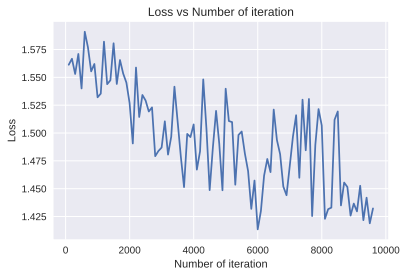

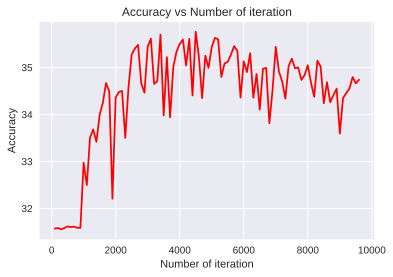

In [199]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [200]:
_ = load_checkpoint('./lstm_best_checkpoint_v3', model_lstm_v3, optimizer)

Loading checkpoint './lstm_best_checkpoint_v3'
Loaded checkpoint './lstm_best_checkpoint_v3' from iteration 2599


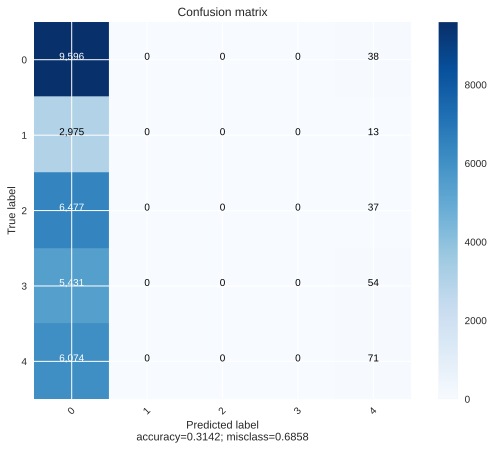

Accuracy: 0.31421 
Balanced accuracy: 0.20152 
Multiclass f1-score: 
    micro: 0.31421 
    macro: 0.09998 
    weighted: 0.15401


Classification report:

              precision    recall  f1-score   support

           0    0.31408   0.99606   0.47757      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.00000   0.00000   0.00000      6514
           3    0.00000   0.00000   0.00000      5485
           4    0.33333   0.01155   0.02233      6145

    accuracy                        0.31421     30766
   macro avg    0.12948   0.20152   0.09998     30766
weighted avg    0.16493   0.31421   0.15401     30766



In [201]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_lstm_v3(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

### **BiLSTM**

In [209]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=32):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_lstm = nn.LSTM(
                                hid_size,
                                hid_size, 
                                num_layers=2,
                                dropout=0.2,
                                bidirectional=True,
                                batch_first=True)
        
        self.dr1 = nn.Dropout(p=0.25)
        self.af1 = nn.LeakyReLU()
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size*2*2, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.LeakyReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke'])
        output, (h_n_joke, c_n_joke) = self.joke_lstm(joke_embeddings)     
        h_n_joke = torch.cat([h_n_joke[i,:, :] for i in range(h_n_joke.shape[0])], dim=1)
        

        out_joke = self.dr1(h_n_joke)
        out_joke = self.af1(out_joke)
        return self.final_predictor(out_joke).squeeze()

In [210]:
model_blstm = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_blstm.parameters(), lr=learning_rate)

In [ ]:
iteration_list, loss_list, accuracy_list  = train(model_blstm, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./bilstm_best_checkpoint",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5636969804763794  Accuracy: 32.15715789794922 %
Saving model and optimizer state at iteration 99 to ./bilstm_best_checkpoint
Iteration: 199  Loss: 1.558190107345581  Accuracy: 32.5159912109375 %
Saving model and optimizer state at iteration 199 to ./bilstm_best_checkpoint
Iteration: 299  Loss: 1.5259391069412231  Accuracy: 32.44318389892578 %
Iteration: 399  Loss: 1.5243308544158936  Accuracy: 34.42976760864258 %
Saving model and optimizer state at iteration 399 to ./bilstm_best_checkpoint
Iteration: 499  Loss: 1.56075119972229  Accuracy: 31.499298095703125 %
Iteration: 599  Loss: 1.5294079780578613  Accuracy: 33.30126190185547 %
Iteration: 699  Loss: 1.5720728635787964  Accuracy: 31.847728729248047 %
Iteration: 799  Loss: 1.575236439704895  Accuracy: 34.75739669799805 %
Saving model and optimizer state at iteration 799 to ./bilstm_best_checkpoint
Iteration: 899  Loss: 1.5136725902557373  Accuracy: 34.82240295410156 %
Saving model and optimizer state at iteration

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.556341528892517  Accuracy: 33.56648635864258 %
Iteration: 1099  Loss: 1.5429831743240356  Accuracy: 34.03453063964844 %
Iteration: 1199  Loss: 1.47687566280365  Accuracy: 33.8551139831543 %
Iteration: 1299  Loss: 1.5074872970581055  Accuracy: 34.65858840942383 %
Iteration: 1399  Loss: 1.5219063758850098  Accuracy: 35.01222229003906 %
Saving model and optimizer state at iteration 1399 to ./bilstm_best_checkpoint
Iteration: 1499  Loss: 1.5252236127853394  Accuracy: 34.98881912231445 %
Iteration: 1599  Loss: 1.5575920343399048  Accuracy: 34.11773681640625 %
Iteration: 1699  Loss: 1.5268269777297974  Accuracy: 35.072025299072266 %
Saving model and optimizer state at iteration 1699 to ./bilstm_best_checkpoint
Iteration: 1799  Loss: 1.5227640867233276  Accuracy: 35.181236267089844 %
Saving model and optimizer state at iteration 1799 to ./bilstm_best_checkpoint
Iteration: 1899  Loss: 1.5206894874572754  Accuracy: 35.23583984375 %
Saving model and optimizer state at ite

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.535274863243103  Accuracy: 35.181236267089844 %
Iteration: 2099  Loss: 1.5454479455947876  Accuracy: 34.726192474365234 %
Iteration: 2199  Loss: 1.5646096467971802  Accuracy: 35.2436408996582 %
Saving model and optimizer state at iteration 2199 to ./bilstm_best_checkpoint
Iteration: 2299  Loss: 1.5057331323623657  Accuracy: 34.710594177246094 %
Iteration: 2399  Loss: 1.5326673984527588  Accuracy: 35.08762741088867 %
Iteration: 2499  Loss: 1.5203131437301636  Accuracy: 35.251441955566406 %
Saving model and optimizer state at iteration 2499 to ./bilstm_best_checkpoint
Iteration: 2599  Loss: 1.5296525955200195  Accuracy: 35.65447998046875 %
Saving model and optimizer state at iteration 2599 to ./bilstm_best_checkpoint
Iteration: 2699  Loss: 1.5556367635726929  Accuracy: 35.46986389160156 %
Iteration: 2799  Loss: 1.5135434865951538  Accuracy: 35.170833587646484 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5440878868103027  Accuracy: 35.755889892578125 %
Saving model and optimizer state at iteration 2899 to ./bilstm_best_checkpoint
Iteration: 2999  Loss: 1.504867672920227  Accuracy: 35.09282684326172 %
Iteration: 3099  Loss: 1.5061525106430054  Accuracy: 35.68048095703125 %
Iteration: 3199  Loss: 1.5107903480529785  Accuracy: 35.50106430053711 %
Iteration: 3299  Loss: 1.5158569812774658  Accuracy: 34.79640197753906 %
Iteration: 3399  Loss: 1.5850168466567993  Accuracy: 35.29044723510742 %
Iteration: 3499  Loss: 1.4732128381729126  Accuracy: 35.8494987487793 %
Saving model and optimizer state at iteration 3499 to ./bilstm_best_checkpoint
Iteration: 3599  Loss: 1.4663234949111938  Accuracy: 35.085025787353516 %
Iteration: 3699  Loss: 1.4925193786621094  Accuracy: 36.04451370239258 %
Saving model and optimizer state at iteration 3699 to ./bilstm_best_checkpoint
Iteration: 3799  Loss: 1.491735816001892  Accuracy: 35.06162643432617 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.535322904586792  Accuracy: 35.98991012573242 %
Iteration: 3999  Loss: 1.4796228408813477  Accuracy: 36.023712158203125 %
Iteration: 4099  Loss: 1.5215359926223755  Accuracy: 35.961307525634766 %
Iteration: 4199  Loss: 1.535382866859436  Accuracy: 35.60767364501953 %
Iteration: 4299  Loss: 1.5086932182312012  Accuracy: 35.638877868652344 %
Iteration: 4399  Loss: 1.51308274269104  Accuracy: 35.82089614868164 %
Iteration: 4499  Loss: 1.4563751220703125  Accuracy: 36.023712158203125 %
Iteration: 4599  Loss: 1.5012134313583374  Accuracy: 36.43455123901367 %
Saving model and optimizer state at iteration 4599 to ./bilstm_best_checkpoint
Iteration: 4699  Loss: 1.5053247213363647  Accuracy: 36.03671646118164 %
Iteration: 4799  Loss: 1.4847110509872437  Accuracy: 36.3331413269043 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.5051391124725342  Accuracy: 35.6752815246582 %
Iteration: 4999  Loss: 1.495928168296814  Accuracy: 36.04971694946289 %
Iteration: 5099  Loss: 1.4337091445922852  Accuracy: 35.755889892578125 %
Iteration: 5199  Loss: 1.5952073335647583  Accuracy: 35.23064041137695 %
Iteration: 5299  Loss: 1.5344566106796265  Accuracy: 36.01331329345703 %
Iteration: 5399  Loss: 1.5204792022705078  Accuracy: 35.79749298095703 %
Iteration: 5499  Loss: 1.5047142505645752  Accuracy: 35.67788314819336 %
Iteration: 5599  Loss: 1.477927327156067  Accuracy: 35.75068664550781 %
Iteration: 5699  Loss: 1.4418491125106812  Accuracy: 34.69239044189453 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.4980281591415405  Accuracy: 35.94050598144531 %
Iteration: 5899  Loss: 1.4812777042388916  Accuracy: 35.893699645996094 %
Iteration: 5999  Loss: 1.5232739448547363  Accuracy: 35.12663269042969 %
Iteration: 6099  Loss: 1.451200008392334  Accuracy: 35.2436408996582 %
Iteration: 6199  Loss: 1.469361662864685  Accuracy: 36.151126861572266 %
Iteration: 6299  Loss: 1.4467636346817017  Accuracy: 36.262935638427734 %
Iteration: 6399  Loss: 1.4883848428726196  Accuracy: 35.722084045410156 %
Iteration: 6499  Loss: 1.5705171823501587  Accuracy: 35.82609558105469 %


In [ ]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [ ]:
_ = load_checkpoint('./bilstm_best_checkpoint', model_blstm, optimizer)

In [ ]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_blstm(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

**V 2**

In [ ]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=32):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_lstm = nn.LSTM(
                                hid_size,
                                hid_size, 
                                num_layers=3,
                                dropout=0.2,
                                bidirectional=True,
                                batch_first=True)
        
        self.dr1 = nn.Dropout(p=0.25)
        self.af1 = nn.Tanh()
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size*3*2, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ELU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke'])
        output, (h_n_joke, c_n_joke) = self.joke_lstm(joke_embeddings)     
        h_n_joke = torch.cat([h_n_joke[i,:, :] for i in range(h_n_joke.shape[0])], dim=1)
        

        out_joke = self.dr1(h_n_joke)
        out_joke = self.af1(out_joke)
        return self.final_predictor(out_joke).squeeze()

In [ ]:
model_bilstm_v2 = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_bilstm_v2.parameters(), lr=learning_rate)

In [ ]:
iteration_list, loss_list, accuracy_list  = train(model_bilstm_v2, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./bilstm_best_checkpoint_v2",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5724533796310425  Accuracy: 28.446617126464844 %
Saving model and optimizer state at iteration 99 to ./bilstm_best_checkpoint_v2
Iteration: 199  Loss: 1.5232006311416626  Accuracy: 32.9554328918457 %
Saving model and optimizer state at iteration 199 to ./bilstm_best_checkpoint_v2
Iteration: 299  Loss: 1.589290976524353  Accuracy: 33.21025466918945 %
Saving model and optimizer state at iteration 299 to ./bilstm_best_checkpoint_v2
Iteration: 399  Loss: 1.5483207702636719  Accuracy: 33.904518127441406 %
Saving model and optimizer state at iteration 399 to ./bilstm_best_checkpoint_v2
Iteration: 499  Loss: 1.4952611923217773  Accuracy: 32.945030212402344 %
Iteration: 599  Loss: 1.5292539596557617  Accuracy: 31.930936813354492 %
Iteration: 699  Loss: 1.5522301197052002  Accuracy: 34.19834518432617 %
Saving model and optimizer state at iteration 699 to ./bilstm_best_checkpoint_v2
Iteration: 799  Loss: 1.5436433553695679  Accuracy: 34.640384674072266 %
Saving model and o

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5482707023620605  Accuracy: 34.61698532104492 %
Iteration: 1099  Loss: 1.5407315492630005  Accuracy: 34.40636444091797 %
Iteration: 1199  Loss: 1.4865392446517944  Accuracy: 34.68979263305664 %
Saving model and optimizer state at iteration 1199 to ./bilstm_best_checkpoint_v2
Iteration: 1299  Loss: 1.5742818117141724  Accuracy: 34.5623779296875 %
Iteration: 1399  Loss: 1.5459084510803223  Accuracy: 34.819801330566406 %
Saving model and optimizer state at iteration 1399 to ./bilstm_best_checkpoint_v2
Iteration: 1499  Loss: 1.5579783916473389  Accuracy: 34.9940185546875 %
Saving model and optimizer state at iteration 1499 to ./bilstm_best_checkpoint_v2
Iteration: 1599  Loss: 1.5420751571655273  Accuracy: 34.25294876098633 %
Iteration: 1699  Loss: 1.529725193977356  Accuracy: 34.817203521728516 %
Iteration: 1799  Loss: 1.550469994544983  Accuracy: 34.82760238647461 %
Iteration: 1899  Loss: 1.5323259830474854  Accuracy: 34.856204986572266 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.558904767036438  Accuracy: 34.9940185546875 %
Iteration: 2099  Loss: 1.5599539279937744  Accuracy: 35.2176399230957 %
Saving model and optimizer state at iteration 2099 to ./bilstm_best_checkpoint_v2
Iteration: 2199  Loss: 1.5602537393569946  Accuracy: 35.0278205871582 %
Iteration: 2299  Loss: 1.581920862197876  Accuracy: 34.9602165222168 %
Iteration: 2399  Loss: 1.511279582977295  Accuracy: 34.11773681640625 %
Iteration: 2499  Loss: 1.5325701236724854  Accuracy: 34.97321701049805 %
Iteration: 2599  Loss: 1.5261785984039307  Accuracy: 33.85771560668945 %
Iteration: 2699  Loss: 1.542557954788208  Accuracy: 35.423057556152344 %
Saving model and optimizer state at iteration 2699 to ./bilstm_best_checkpoint_v2
Iteration: 2799  Loss: 1.5644174814224243  Accuracy: 35.207237243652344 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5022907257080078  Accuracy: 35.277442932128906 %
Iteration: 2999  Loss: 1.5376524925231934  Accuracy: 34.076133728027344 %
Iteration: 3099  Loss: 1.4812320470809937  Accuracy: 35.19683837890625 %
Iteration: 3199  Loss: 1.4918659925460815  Accuracy: 35.441261291503906 %
Saving model and optimizer state at iteration 3199 to ./bilstm_best_checkpoint_v2
Iteration: 3299  Loss: 1.4229718446731567  Accuracy: 34.95761489868164 %
Iteration: 3399  Loss: 1.5128917694091797  Accuracy: 35.628475189208984 %
Saving model and optimizer state at iteration 3399 to ./bilstm_best_checkpoint_v2
Iteration: 3499  Loss: 1.5540492534637451  Accuracy: 34.7781982421875 %
Iteration: 3599  Loss: 1.533298134803772  Accuracy: 35.625877380371094 %
Iteration: 3699  Loss: 1.469686508178711  Accuracy: 34.22434616088867 %
Iteration: 3799  Loss: 1.4777448177337646  Accuracy: 35.59467315673828 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.511636734008789  Accuracy: 35.261844635009766 %
Iteration: 3999  Loss: 1.5583475828170776  Accuracy: 35.950904846191406 %
Saving model and optimizer state at iteration 3999 to ./bilstm_best_checkpoint_v2
Iteration: 4099  Loss: 1.4304081201553345  Accuracy: 35.85989761352539 %
Iteration: 4199  Loss: 1.507562518119812  Accuracy: 35.83909606933594 %
Iteration: 4299  Loss: 1.4968854188919067  Accuracy: 35.67788314819336 %


KeyboardInterrupt: ignored

In [ ]:
draw_visualization(iteration_list, loss_list, accuracy_list)

NameError: ignored

In [ ]:
_ = load_checkpoint('./bilstm_best_checkpoint_v2', model_bilstm_v2, optimizer)

Loading checkpoint './bilstm_best_checkpoint_v2'
Loaded checkpoint './bilstm_best_checkpoint_v2' from iteration 3999


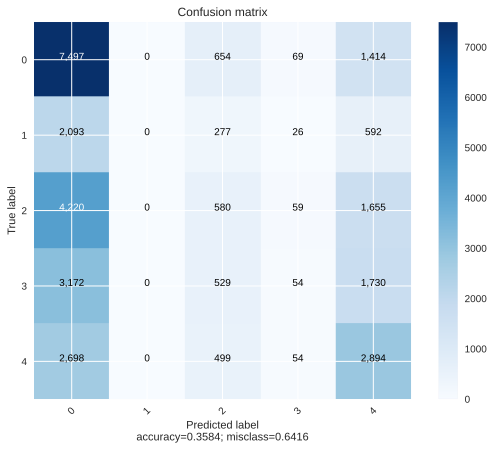

Accuracy: 0.35835 
Balanced accuracy: 0.2696 
Multiclass f1-score: 
    micro: 0.35835 
    macro: 0.21191 
    weighted: 0.27076


Classification report:

              precision    recall  f1-score   support

           0    0.38095   0.77818   0.51150      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.22844   0.08904   0.12813      6514
           3    0.20611   0.00985   0.01879      5485
           4    0.34931   0.47095   0.40111      6145

    accuracy                        0.35835     30766
   macro avg    0.23296   0.26960   0.21191     30766
weighted avg    0.27417   0.35835   0.27076     30766



In [ ]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_bilstm_v2(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

### **микс рекуррентных и сверточных слоев**

In [ ]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.conv1 = nn.Conv1d(hid_size, hid_size, kernel_size=5)
        self.af11 = nn.LeakyReLU()
        self.joke_lstm = nn.LSTM(
                                hid_size,
                                hid_size, 
                                num_layers=2,
                                dropout=0.2,
                                # bidirectional=True,
                                batch_first=True)
        
        self.dr1 = nn.Dropout(p=0.25)
        self.af1 = nn.LeakyReLU()
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size*2, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ELU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        out1 = self.conv1(joke_embeddings)
        out1 = self.af11(out1).permute(0, 2, 1)

        output, (h_n_joke, c_n_joke) = self.joke_lstm(out1)     
        h_n_joke = torch.cat([h_n_joke[i,:, :] for i in range(h_n_joke.shape[0])], dim=1)
        
        out_joke = self.dr1(h_n_joke)
        out_joke = self.af1(out_joke)
        return self.final_predictor(out_joke).squeeze()

In [ ]:
model_c_rnn = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_c_rnn.parameters(), lr=learning_rate)

In [ ]:
iteration_list, loss_list, accuracy_list  = train(model_c_rnn, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_rnn_best_checkpoint",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5665760040283203  Accuracy: 31.587705612182617 %
Saving model and optimizer state at iteration 99 to ./cnn_rnn_best_checkpoint
Iteration: 199  Loss: 1.5756144523620605  Accuracy: 31.57730484008789 %
Iteration: 299  Loss: 1.5627214908599854  Accuracy: 31.63191032409668 %
Saving model and optimizer state at iteration 299 to ./cnn_rnn_best_checkpoint
Iteration: 399  Loss: 1.5595587491989136  Accuracy: 31.59550666809082 %
Iteration: 499  Loss: 1.5447845458984375  Accuracy: 31.603307723999023 %
Iteration: 599  Loss: 1.568886637687683  Accuracy: 31.507097244262695 %
Iteration: 699  Loss: 1.588631272315979  Accuracy: 31.491497039794922 %
Iteration: 799  Loss: 1.5772838592529297  Accuracy: 31.598106384277344 %
Iteration: 899  Loss: 1.570806860923767  Accuracy: 31.61370849609375 %
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5384023189544678  Accuracy: 31.889333724975586 %
Saving model and optimizer state at iteration 999 to ./cnn_rnn_best_checkpoint
Iteration: 1099  Loss: 1.5749826431274414  Accuracy: 32.64080047607422 %
Saving model and optimizer state at iteration 1099 to ./cnn_rnn_best_checkpoint
Iteration: 1199  Loss: 1.5752280950546265  Accuracy: 32.86442184448242 %
Saving model and optimizer state at iteration 1199 to ./cnn_rnn_best_checkpoint
Iteration: 1299  Loss: 1.57830011844635  Accuracy: 33.257057189941406 %
Saving model and optimizer state at iteration 1299 to ./cnn_rnn_best_checkpoint
Iteration: 1399  Loss: 1.5669423341751099  Accuracy: 32.58619689941406 %
Iteration: 1499  Loss: 1.523573875427246  Accuracy: 32.518592834472656 %
Iteration: 1599  Loss: 1.5413596630096436  Accuracy: 32.55499267578125 %
Iteration: 1699  Loss: 1.586975336074829  Accuracy: 32.90082550048828 %
Iteration: 1799  Loss: 1.5442125797271729  Accuracy: 19.58500099182129 %
Iteration: 1899  Loss: 1.5

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5811280012130737  Accuracy: 31.92833709716797 %
Iteration: 2099  Loss: 1.5433313846588135  Accuracy: 31.780122756958008 %
Iteration: 2199  Loss: 1.56208074092865  Accuracy: 32.580997467041016 %
Iteration: 2299  Loss: 1.5542017221450806  Accuracy: 32.583595275878906 %
Iteration: 2399  Loss: 1.5656131505966187  Accuracy: 31.616308212280273 %
Iteration: 2499  Loss: 1.6129268407821655  Accuracy: 31.582504272460938 %
Iteration: 2599  Loss: 1.5336581468582153  Accuracy: 31.587705612182617 %
Iteration: 2699  Loss: 1.5227935314178467  Accuracy: 31.585105895996094 %
Iteration: 2799  Loss: 1.5655544996261597  Accuracy: 31.59030532836914 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5835884809494019  Accuracy: 19.720212936401367 %
Iteration: 2999  Loss: 1.5775221586227417  Accuracy: 34.07353591918945 %
Saving model and optimizer state at iteration 2999 to ./cnn_rnn_best_checkpoint
Iteration: 3099  Loss: 1.5897605419158936  Accuracy: 34.30755615234375 %
Saving model and optimizer state at iteration 3099 to ./cnn_rnn_best_checkpoint
Iteration: 3199  Loss: 1.5543904304504395  Accuracy: 34.64558792114258 %
Saving model and optimizer state at iteration 3199 to ./cnn_rnn_best_checkpoint
Iteration: 3299  Loss: 1.5585578680038452  Accuracy: 33.82651138305664 %
Iteration: 3399  Loss: 1.5363487005233765  Accuracy: 35.0018196105957 %
Saving model and optimizer state at iteration 3399 to ./cnn_rnn_best_checkpoint
Iteration: 3499  Loss: 1.5408895015716553  Accuracy: 34.45576858520508 %
Iteration: 3599  Loss: 1.4877594709396362  Accuracy: 34.590980529785156 %
Iteration: 3699  Loss: 1.539082407951355  Accuracy: 35.16043472290039 %
Saving model and optimi

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.585898756980896  Accuracy: 34.70279312133789 %
Iteration: 3999  Loss: 1.5099177360534668  Accuracy: 34.59358215332031 %
Iteration: 4099  Loss: 1.4796563386917114  Accuracy: 35.09022903442383 %
Iteration: 4199  Loss: 1.5723333358764648  Accuracy: 35.25664138793945 %
Saving model and optimizer state at iteration 4199 to ./cnn_rnn_best_checkpoint
Iteration: 4299  Loss: 1.5411043167114258  Accuracy: 35.24884033203125 %
Iteration: 4399  Loss: 1.5635393857955933  Accuracy: 35.261844635009766 %
Saving model and optimizer state at iteration 4399 to ./cnn_rnn_best_checkpoint
Iteration: 4499  Loss: 1.518736720085144  Accuracy: 35.52446746826172 %
Saving model and optimizer state at iteration 4499 to ./cnn_rnn_best_checkpoint
Iteration: 4599  Loss: 1.498294711112976  Accuracy: 35.579071044921875 %
Saving model and optimizer state at iteration 4599 to ./cnn_rnn_best_checkpoint
Iteration: 4699  Loss: 1.5344442129135132  Accuracy: 35.58687210083008 %
Saving model and optimiz

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.5169336795806885  Accuracy: 34.69758987426758 %
Iteration: 4999  Loss: 1.5210679769515991  Accuracy: 34.723594665527344 %
Iteration: 5099  Loss: 1.5212417840957642  Accuracy: 34.533775329589844 %
Iteration: 5199  Loss: 1.5178120136260986  Accuracy: 34.916011810302734 %
Iteration: 5299  Loss: 1.4959126710891724  Accuracy: 35.4256591796875 %
Iteration: 5399  Loss: 1.4984067678451538  Accuracy: 35.781890869140625 %
Saving model and optimizer state at iteration 5399 to ./cnn_rnn_best_checkpoint
Iteration: 5499  Loss: 1.475454568862915  Accuracy: 35.4256591796875 %
Iteration: 5599  Loss: 1.5264564752578735  Accuracy: 35.35545349121094 %
Iteration: 5699  Loss: 1.4649497270584106  Accuracy: 35.6414794921875 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.481444001197815  Accuracy: 35.80269241333008 %
Saving model and optimizer state at iteration 5799 to ./cnn_rnn_best_checkpoint
Iteration: 5899  Loss: 1.5005950927734375  Accuracy: 35.06162643432617 %
Iteration: 5999  Loss: 1.516980528831482  Accuracy: 35.16303253173828 %
Iteration: 6099  Loss: 1.495679259300232  Accuracy: 34.903011322021484 %
Iteration: 6199  Loss: 1.5016824007034302  Accuracy: 35.170833587646484 %
Iteration: 6299  Loss: 1.5015138387680054  Accuracy: 34.53117752075195 %
Iteration: 6399  Loss: 1.523669958114624  Accuracy: 35.48806381225586 %
Iteration: 6499  Loss: 1.4752063751220703  Accuracy: 35.134429931640625 %
Iteration: 6599  Loss: 1.534034013748169  Accuracy: 34.69758987426758 %
Iteration: 6699  Loss: 1.5004117488861084  Accuracy: 34.242549896240234 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.5589488744735718  Accuracy: 34.905609130859375 %
Iteration: 6899  Loss: 1.4623613357543945  Accuracy: 34.85100555419922 %
Iteration: 6999  Loss: 1.4423803091049194  Accuracy: 34.929012298583984 %
Iteration: 7099  Loss: 1.5326873064041138  Accuracy: 35.108428955078125 %
Iteration: 7199  Loss: 1.5067371129989624  Accuracy: 34.866607666015625 %
Iteration: 7299  Loss: 1.448660969734192  Accuracy: 34.93161392211914 %
Iteration: 7399  Loss: 1.4635024070739746  Accuracy: 35.25664138793945 %
Iteration: 7499  Loss: 1.4545015096664429  Accuracy: 35.212440490722656 %
Iteration: 7599  Loss: 1.514123558998108  Accuracy: 35.55567169189453 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.4648851156234741  Accuracy: 35.25924301147461 %
Iteration: 7799  Loss: 1.4515336751937866  Accuracy: 34.411563873291016 %
Iteration: 7899  Loss: 1.433616280555725  Accuracy: 34.5103759765625 %
Iteration: 7999  Loss: 1.4316198825836182  Accuracy: 34.5025749206543 %
Iteration: 8099  Loss: 1.4567394256591797  Accuracy: 34.35176086425781 %
Iteration: 8199  Loss: 1.4378907680511475  Accuracy: 34.942012786865234 %
Iteration: 8299  Loss: 1.442171335220337  Accuracy: 35.05642318725586 %
Iteration: 8399  Loss: 1.4978740215301514  Accuracy: 35.09282684326172 %
Iteration: 8499  Loss: 1.5390006303787231  Accuracy: 34.929012298583984 %


KeyboardInterrupt: ignored

**I stopped training**

In [ ]:
_ = load_checkpoint('./cnn_rnn_best_checkpoint', model_c_rnn, optimizer)

Loading checkpoint './cnn_rnn_best_checkpoint'
Loaded checkpoint './cnn_rnn_best_checkpoint' from iteration 5799


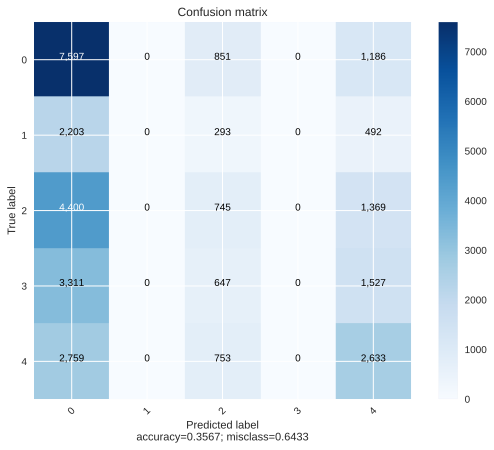

Accuracy: 0.35672 
Balanced accuracy: 0.26628 
Multiclass f1-score: 
    micro: 0.35672 
    macro: 0.2109 
    weighted: 0.27006


Classification report:

              precision    recall  f1-score   support

           0    0.37479   0.78856   0.50809      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.22651   0.11437   0.15199      6514
           3    0.00000   0.00000   0.00000      5485
           4    0.36534   0.42848   0.39440      6145

    accuracy                        0.35672     30766
   macro avg    0.19333   0.26628   0.21090     30766
weighted avg    0.23829   0.35672   0.27006     30766



In [ ]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_c_rnn(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

**V 2**

In [ ]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=32):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.conv1 = nn.Conv1d(hid_size, hid_size, kernel_size=5)
        self.af11 = nn.LeakyReLU()
        self.joke_lstm = nn.LSTM(
                                hid_size,
                                hid_size, 
                                num_layers=2,
                                dropout=0.2,
                                bidirectional=True,
                                batch_first=True)
        
        self.dr1 = nn.Dropout(p=0.25)
        self.af1 = nn.LeakyReLU()
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size*2*2, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ELU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        out1 = self.conv1(joke_embeddings)
        out1 = self.af11(out1).permute(0, 2, 1)

        output, (h_n_joke, c_n_joke) = self.joke_lstm(out1)     
        h_n_joke = torch.cat([h_n_joke[i,:, :] for i in range(h_n_joke.shape[0])], dim=1)
        
        out_joke = self.dr1(h_n_joke)
        out_joke = self.af1(out_joke)
        return self.final_predictor(out_joke).squeeze()

In [ ]:
model_c_rnn_v2 = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_c_rnn_v2.parameters(), lr=learning_rate)

In [ ]:
iteration_list, loss_list, accuracy_list  = train(model_c_rnn_v2, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_rnn_best_checkpoint_v2",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.6134264469146729  Accuracy: 24.920692443847656 %
Saving model and optimizer state at iteration 99 to ./cnn_rnn_best_checkpoint_v2
Iteration: 199  Loss: 1.5928595066070557  Accuracy: 26.811065673828125 %
Saving model and optimizer state at iteration 199 to ./cnn_rnn_best_checkpoint_v2
Iteration: 299  Loss: 1.606005311012268  Accuracy: 28.74044418334961 %
Saving model and optimizer state at iteration 299 to ./cnn_rnn_best_checkpoint_v2
Iteration: 399  Loss: 1.601971983909607  Accuracy: 28.893857955932617 %
Saving model and optimizer state at iteration 399 to ./cnn_rnn_best_checkpoint_v2
Iteration: 499  Loss: 1.6152901649475098  Accuracy: 29.671329498291016 %
Saving model and optimizer state at iteration 499 to ./cnn_rnn_best_checkpoint_v2
Iteration: 599  Loss: 1.5735950469970703  Accuracy: 30.26678466796875 %
Saving model and optimizer state at iteration 599 to ./cnn_rnn_best_checkpoint_v2
Iteration: 699  Loss: 1.5731393098831177  Accuracy: 30.26158332824707 %
Iter

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5522706508636475  Accuracy: 31.975141525268555 %
Saving model and optimizer state at iteration 999 to ./cnn_rnn_best_checkpoint_v2
Iteration: 1099  Loss: 1.5881528854370117  Accuracy: 32.56279373168945 %
Saving model and optimizer state at iteration 1099 to ./cnn_rnn_best_checkpoint_v2
Iteration: 1199  Loss: 1.5557620525360107  Accuracy: 33.90191650390625 %
Saving model and optimizer state at iteration 1199 to ./cnn_rnn_best_checkpoint_v2
Iteration: 1299  Loss: 1.5584919452667236  Accuracy: 32.209163665771484 %
Iteration: 1399  Loss: 1.5910282135009766  Accuracy: 33.81351089477539 %
Iteration: 1499  Loss: 1.5612879991531372  Accuracy: 34.16194152832031 %
Saving model and optimizer state at iteration 1499 to ./cnn_rnn_best_checkpoint_v2
Iteration: 1599  Loss: 1.5527552366256714  Accuracy: 32.49258804321289 %
Iteration: 1699  Loss: 1.565435767173767  Accuracy: 32.388580322265625 %
Iteration: 1799  Loss: 1.567692756652832  Accuracy: 32.62779998779297 %
Iteration: 1

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5668818950653076  Accuracy: 33.75110626220703 %
Iteration: 2099  Loss: 1.6012626886367798  Accuracy: 33.569087982177734 %
Iteration: 2199  Loss: 1.6036237478256226  Accuracy: 34.22434616088867 %
Saving model and optimizer state at iteration 2199 to ./cnn_rnn_best_checkpoint_v2
Iteration: 2299  Loss: 1.5661463737487793  Accuracy: 33.111446380615234 %
Iteration: 2399  Loss: 1.5591530799865723  Accuracy: 34.20354461669922 %
Iteration: 2499  Loss: 1.540981650352478  Accuracy: 34.19054412841797 %
Iteration: 2599  Loss: 1.5767561197280884  Accuracy: 34.20874786376953 %
Iteration: 2699  Loss: 1.5610873699188232  Accuracy: 33.08284378051758 %
Iteration: 2799  Loss: 1.5621415376663208  Accuracy: 34.02933120727539 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5763579607009888  Accuracy: 34.130741119384766 %
Iteration: 2999  Loss: 1.5649335384368896  Accuracy: 34.538978576660156 %
Saving model and optimizer state at iteration 2999 to ./cnn_rnn_best_checkpoint_v2


KeyboardInterrupt: ignored

In [ ]:
_ = load_checkpoint('./cnn_rnn_best_checkpoint_v2', model_c_rnn_v2, optimizer)

Loading checkpoint './cnn_rnn_best_checkpoint_v2'
Loaded checkpoint './cnn_rnn_best_checkpoint_v2' from iteration 2999


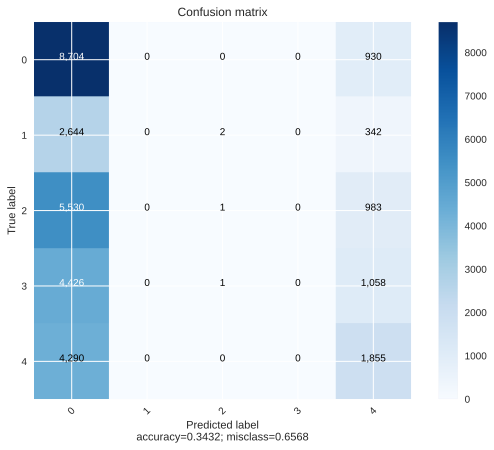

Accuracy: 0.34324 
Balanced accuracy: 0.2411 
Multiclass f1-score: 
    micro: 0.34324 
    macro: 0.16448 
    weighted: 0.2203


Classification report:

              precision    recall  f1-score   support

           0    0.34008   0.90347   0.49415      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.25000   0.00015   0.00031      6514
           3    0.00000   0.00000   0.00000      5485
           4    0.35894   0.30187   0.32794      6145

    accuracy                        0.34324     30766
   macro avg    0.18980   0.24110   0.16448     30766
weighted avg    0.23112   0.34324   0.22030     30766



In [ ]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_c_rnn_v2(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

**V 3**

In [ ]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.conv1 = nn.Conv1d(hid_size, hid_size*2, kernel_size=2)
        self.af1 = nn.Tanh()
        self.conv2 = nn.Conv1d(hid_size*2, hid_size*2, kernel_size=3)
        self.af2 = nn.LeakyReLU()
        self.conv3 = nn.Conv1d(hid_size*2, hid_size, kernel_size=5)
        self.af3 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(2)
        self.do1 = nn.Dropout(p=0.25)
        self.af4 = nn.LeakyReLU()

        self.joke_lstm = nn.LSTM(
                                hid_size,
                                hid_size, 
                                dropout=0.2,
                                bidirectional=True,
                                batch_first=True)
        
        self.dr2 = nn.Dropout(p=0.25)
        self.af5 = nn.LeakyReLU()
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size*2, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        out = self.conv1(joke_embeddings)
        out = self.af1(out)
        out = self.conv2(out)
        out = self.af2(out)
        out = self.conv3(out)
        out = self.af3(out)
        out = self.pool1(out)
        out = self.do1(out)
        out = self.af4(out).permute(0, 2, 1)

        output, (h_n_joke, c_n_joke) = self.joke_lstm(out)     
        h_n_joke = torch.cat([h_n_joke[i,:, :] for i in range(h_n_joke.shape[0])], dim=1)
        
        out_joke = self.dr2(h_n_joke)
        out_joke = self.af5(out_joke)
        return self.final_predictor(out_joke).squeeze()

In [ ]:
model_c_rnn_v3 = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_c_rnn_v3.parameters(), lr=learning_rate)

In [ ]:
iteration_list, loss_list, accuracy_list  = train(model_c_rnn_v3, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_rnn_best_checkpoint_v3",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5898661613464355  Accuracy: 20.292266845703125 %
Saving model and optimizer state at iteration 99 to ./cnn_rnn_best_checkpoint_v3
Iteration: 199  Loss: 1.590922474861145  Accuracy: 31.09626007080078 %
Saving model and optimizer state at iteration 199 to ./cnn_rnn_best_checkpoint_v3
Iteration: 299  Loss: 1.5494481325149536  Accuracy: 31.592905044555664 %
Saving model and optimizer state at iteration 299 to ./cnn_rnn_best_checkpoint_v3
Iteration: 399  Loss: 1.5728166103363037  Accuracy: 34.46617126464844 %
Saving model and optimizer state at iteration 399 to ./cnn_rnn_best_checkpoint_v3
Iteration: 499  Loss: 1.587306022644043  Accuracy: 34.54937744140625 %
Saving model and optimizer state at iteration 499 to ./cnn_rnn_best_checkpoint_v3
Iteration: 599  Loss: 1.55422842502594  Accuracy: 34.20094680786133 %
Iteration: 699  Loss: 1.504589319229126  Accuracy: 34.206146240234375 %
Iteration: 799  Loss: 1.5425267219543457  Accuracy: 34.63518524169922 %
Saving model and o

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5755691528320312  Accuracy: 34.78339767456055 %
Saving model and optimizer state at iteration 999 to ./cnn_rnn_best_checkpoint_v3
Iteration: 1099  Loss: 1.5255706310272217  Accuracy: 34.767799377441406 %
Iteration: 1199  Loss: 1.5229512453079224  Accuracy: 34.336158752441406 %
Iteration: 1299  Loss: 1.5060415267944336  Accuracy: 34.84840393066406 %
Saving model and optimizer state at iteration 1299 to ./cnn_rnn_best_checkpoint_v3
Iteration: 1399  Loss: 1.5219361782073975  Accuracy: 34.74699783325195 %
Iteration: 1499  Loss: 1.5559985637664795  Accuracy: 34.793800354003906 %
Iteration: 1599  Loss: 1.5250567197799683  Accuracy: 34.7859992980957 %
Iteration: 1699  Loss: 1.5092703104019165  Accuracy: 34.83280563354492 %
Iteration: 1799  Loss: 1.5376492738723755  Accuracy: 34.85100555419922 %
Saving model and optimizer state at iteration 1799 to ./cnn_rnn_best_checkpoint_v3
Iteration: 1899  Loss: 1.5597214698791504  Accuracy: 34.84840393066406 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5389028787612915  Accuracy: 34.88220977783203 %
Saving model and optimizer state at iteration 1999 to ./cnn_rnn_best_checkpoint_v3
Iteration: 2099  Loss: 1.5651805400848389  Accuracy: 34.16714096069336 %
Iteration: 2199  Loss: 1.5014889240264893  Accuracy: 34.66638946533203 %
Iteration: 2299  Loss: 1.5264025926589966  Accuracy: 34.723594665527344 %
Iteration: 2399  Loss: 1.5744127035140991  Accuracy: 34.60918426513672 %
Iteration: 2499  Loss: 1.5166049003601074  Accuracy: 34.69239044189453 %
Iteration: 2599  Loss: 1.545262098312378  Accuracy: 33.878517150878906 %
Iteration: 2699  Loss: 1.524525761604309  Accuracy: 34.69758987426758 %
Iteration: 2799  Loss: 1.558835506439209  Accuracy: 34.65858840942383 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5228641033172607  Accuracy: 34.68458938598633 %
Iteration: 2999  Loss: 1.53764808177948  Accuracy: 34.7443962097168 %
Iteration: 3099  Loss: 1.5575488805770874  Accuracy: 34.793800354003906 %
Iteration: 3199  Loss: 1.528260588645935  Accuracy: 34.83800506591797 %
Iteration: 3299  Loss: 1.529715895652771  Accuracy: 34.52337646484375 %


KeyboardInterrupt: ignored

In [ ]:
_ = load_checkpoint('./cnn_rnn_best_checkpoint_v3', model_c_rnn_v3, optimizer)

Loading checkpoint './cnn_rnn_best_checkpoint_v3'
Loaded checkpoint './cnn_rnn_best_checkpoint_v3' from iteration 1999


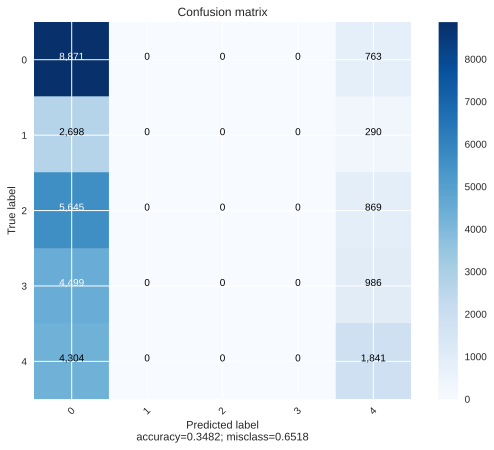

Accuracy: 0.34818 
Balanced accuracy: 0.24408 
Multiclass f1-score: 
    micro: 0.34818 
    macro: 0.16713 
    weighted: 0.22334


Classification report:

              precision    recall  f1-score   support

           0    0.34097   0.92080   0.49766      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.00000   0.00000   0.00000      6514
           3    0.00000   0.00000   0.00000      5485
           4    0.38766   0.29959   0.33798      6145

    accuracy                        0.34818     30766
   macro avg    0.14573   0.24408   0.16713     30766
weighted avg    0.18420   0.34818   0.22334     30766



In [ ]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_c_rnn_v3(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

# **Pooling слои продвинутые**

### **Softmax Pooling**

In [ ]:
class SoftmaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return (x * x.softmax(dim=self.dim)).sum(dim=self.dim)

In [ ]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size*2, kernel_size=2),
            nn.Tanh(),
            nn.Conv1d(hid_size*2, hid_size*2, kernel_size=3),
            nn.LeakyReLU(),
            nn.Conv1d(hid_size*2, hid_size, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),

            nn.Dropout(p=0.25),
            nn.LeakyReLU(),
            SoftmaxPooling()
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features = self.joke_encoder(joke_embeddings).squeeze()

        return self.final_predictor(joke_features).squeeze()

In [ ]:
model_sp = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_sp.parameters(), lr=learning_rate)

In [ ]:
iteration_list, loss_list, accuracy_list  = train(model_sp, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_sp_best_checkpoint",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5013595819473267  Accuracy: 34.02933120727539 %
Saving model and optimizer state at iteration 99 to ./cnn_sp_best_checkpoint
Iteration: 199  Loss: 1.5182338953018188  Accuracy: 34.24515151977539 %
Saving model and optimizer state at iteration 199 to ./cnn_sp_best_checkpoint
Iteration: 299  Loss: 1.5208511352539062  Accuracy: 31.816526412963867 %
Iteration: 399  Loss: 1.5395416021347046  Accuracy: 32.125953674316406 %
Iteration: 499  Loss: 1.559714913368225  Accuracy: 34.5701789855957 %
Saving model and optimizer state at iteration 499 to ./cnn_sp_best_checkpoint
Iteration: 599  Loss: 1.5896106958389282  Accuracy: 33.70690155029297 %
Iteration: 699  Loss: 1.5534114837646484  Accuracy: 33.459877014160156 %
Iteration: 799  Loss: 1.547414779663086  Accuracy: 34.564979553222656 %
Iteration: 899  Loss: 1.5422736406326294  Accuracy: 34.229549407958984 %
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.533403754234314  Accuracy: 34.281551361083984 %
Iteration: 1099  Loss: 1.4988336563110352  Accuracy: 33.101043701171875 %
Iteration: 1199  Loss: 1.5374563932418823  Accuracy: 33.07764434814453 %
Iteration: 1299  Loss: 1.475944995880127  Accuracy: 33.22585678100586 %
Iteration: 1399  Loss: 1.4790176153182983  Accuracy: 33.81610870361328 %
Iteration: 1499  Loss: 1.5172641277313232  Accuracy: 33.99812698364258 %
Iteration: 1599  Loss: 1.5247058868408203  Accuracy: 34.076133728027344 %
Iteration: 1699  Loss: 1.5380070209503174  Accuracy: 32.97883224487305 %
Iteration: 1799  Loss: 1.4431709051132202  Accuracy: 34.107337951660156 %
Iteration: 1899  Loss: 1.5155153274536133  Accuracy: 34.68979263305664 %
Saving model and optimizer state at iteration 1899 to ./cnn_sp_best_checkpoint
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.4899464845657349  Accuracy: 34.39336395263672 %
Iteration: 2099  Loss: 1.502126932144165  Accuracy: 34.193145751953125 %
Iteration: 2199  Loss: 1.5122766494750977  Accuracy: 34.47657012939453 %
Iteration: 2299  Loss: 1.5577493906021118  Accuracy: 35.01742172241211 %
Saving model and optimizer state at iteration 2299 to ./cnn_sp_best_checkpoint
Iteration: 2399  Loss: 1.4784824848175049  Accuracy: 34.08133316040039 %
Iteration: 2499  Loss: 1.5646988153457642  Accuracy: 34.09953689575195 %
Iteration: 2599  Loss: 1.4960744380950928  Accuracy: 34.36476135253906 %
Iteration: 2699  Loss: 1.5403484106063843  Accuracy: 34.90821075439453 %
Iteration: 2799  Loss: 1.4928678274154663  Accuracy: 34.94981384277344 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5068410634994507  Accuracy: 34.33095932006836 %
Iteration: 2999  Loss: 1.4796929359436035  Accuracy: 35.16043472290039 %
Saving model and optimizer state at iteration 2999 to ./cnn_sp_best_checkpoint
Iteration: 3099  Loss: 1.504129409790039  Accuracy: 34.22694778442383 %
Iteration: 3199  Loss: 1.5096875429153442  Accuracy: 34.41416549682617 %
Iteration: 3299  Loss: 1.526734709739685  Accuracy: 34.291954040527344 %
Iteration: 3399  Loss: 1.4817253351211548  Accuracy: 34.51297378540039 %
Iteration: 3499  Loss: 1.510671615600586  Accuracy: 33.1816520690918 %
Iteration: 3599  Loss: 1.5316107273101807  Accuracy: 34.11513900756836 %
Iteration: 3699  Loss: 1.5207037925720215  Accuracy: 33.74590301513672 %
Iteration: 3799  Loss: 1.5325688123703003  Accuracy: 35.06422424316406 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.5175457000732422  Accuracy: 34.968017578125 %
Iteration: 3999  Loss: 1.4574592113494873  Accuracy: 34.22694778442383 %
Iteration: 4099  Loss: 1.4466429948806763  Accuracy: 34.63258361816406 %
Iteration: 4199  Loss: 1.4825807809829712  Accuracy: 34.3127555847168 %
Iteration: 4299  Loss: 1.5475338697433472  Accuracy: 33.88371658325195 %
Iteration: 4399  Loss: 1.5043364763259888  Accuracy: 34.3127555847168 %
Iteration: 4499  Loss: 1.4011218547821045  Accuracy: 34.952415466308594 %
Iteration: 4599  Loss: 1.4550039768218994  Accuracy: 34.60658264160156 %
Iteration: 4699  Loss: 1.4651850461959839  Accuracy: 34.46876907348633 %
Iteration: 4799  Loss: 1.469749093055725  Accuracy: 34.93421173095703 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.4816402196884155  Accuracy: 34.1385383605957 %
Iteration: 4999  Loss: 1.453351378440857  Accuracy: 34.80160140991211 %
Iteration: 5099  Loss: 1.4315887689590454  Accuracy: 34.83540344238281 %
Iteration: 5199  Loss: 1.4582223892211914  Accuracy: 34.7183952331543 %
Iteration: 5299  Loss: 1.4726498126983643  Accuracy: 34.447967529296875 %
Iteration: 5399  Loss: 1.5041955709457397  Accuracy: 34.23994827270508 %
Iteration: 5499  Loss: 1.478606939315796  Accuracy: 34.61698532104492 %
Iteration: 5599  Loss: 1.480135440826416  Accuracy: 35.37625503540039 %
Saving model and optimizer state at iteration 5599 to ./cnn_sp_best_checkpoint
Iteration: 5699  Loss: 1.496064305305481  Accuracy: 34.64558792114258 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.4334027767181396  Accuracy: 34.48697280883789 %
Iteration: 5899  Loss: 1.4266453981399536  Accuracy: 34.52337646484375 %
Iteration: 5999  Loss: 1.4784857034683228  Accuracy: 34.03453063964844 %
Iteration: 6099  Loss: 1.4586848020553589  Accuracy: 34.54937744140625 %
Iteration: 6199  Loss: 1.4247143268585205  Accuracy: 33.774505615234375 %
Iteration: 6299  Loss: 1.4915351867675781  Accuracy: 35.706485748291016 %
Saving model and optimizer state at iteration 6299 to ./cnn_sp_best_checkpoint
Iteration: 6399  Loss: 1.492353081703186  Accuracy: 34.7599983215332 %
Iteration: 6499  Loss: 1.5256483554840088  Accuracy: 34.713191986083984 %
Iteration: 6599  Loss: 1.478660225868225  Accuracy: 34.48697280883789 %
Iteration: 6699  Loss: 1.4882134199142456  Accuracy: 35.046024322509766 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.4315682649612427  Accuracy: 34.3543586730957 %
Iteration: 6899  Loss: 1.547221064567566  Accuracy: 34.843204498291016 %
Iteration: 6999  Loss: 1.3919382095336914  Accuracy: 33.70690155029297 %
Iteration: 7099  Loss: 1.453260898590088  Accuracy: 34.05533218383789 %
Iteration: 7199  Loss: 1.3810908794403076  Accuracy: 35.022621154785156 %
Iteration: 7299  Loss: 1.5088303089141846  Accuracy: 34.21134567260742 %
Iteration: 7399  Loss: 1.470444679260254  Accuracy: 34.40376281738281 %
Iteration: 7499  Loss: 1.4558415412902832  Accuracy: 34.687191009521484 %
Iteration: 7599  Loss: 1.4619615077972412  Accuracy: 33.808311462402344 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.4948683977127075  Accuracy: 33.96172332763672 %
Iteration: 7799  Loss: 1.3446094989776611  Accuracy: 34.7183952331543 %
Iteration: 7899  Loss: 1.4172253608703613  Accuracy: 34.5623779296875 %
Iteration: 7999  Loss: 1.421133279800415  Accuracy: 34.47657012939453 %
Iteration: 8099  Loss: 1.479859709739685  Accuracy: 34.650787353515625 %
Iteration: 8199  Loss: 1.406001329421997  Accuracy: 33.98512649536133 %
Iteration: 8299  Loss: 1.460726022720337  Accuracy: 34.3465576171875 %
Iteration: 8399  Loss: 1.4539083242416382  Accuracy: 35.2098388671875 %
Iteration: 8499  Loss: 1.4172892570495605  Accuracy: 34.853607177734375 %
Iteration: 8599  Loss: 1.4423326253890991  Accuracy: 34.37776184082031 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.3658504486083984  Accuracy: 34.411563873291016 %
Iteration: 8799  Loss: 1.4867585897445679  Accuracy: 34.70279312133789 %
Iteration: 8899  Loss: 1.3553134202957153  Accuracy: 33.98512649536133 %
Iteration: 8999  Loss: 1.441258430480957  Accuracy: 34.63258361816406 %
Iteration: 9099  Loss: 1.4459114074707031  Accuracy: 34.64558792114258 %
Iteration: 9199  Loss: 1.3919899463653564  Accuracy: 34.996620178222656 %
Iteration: 9299  Loss: 1.4711600542068481  Accuracy: 35.118831634521484 %
Iteration: 9399  Loss: 1.4464963674545288  Accuracy: 34.17494201660156 %
Iteration: 9499  Loss: 1.4523847103118896  Accuracy: 34.7183952331543 %
Iteration: 9599  Loss: 1.4611507654190063  Accuracy: 33.92012023925781 %


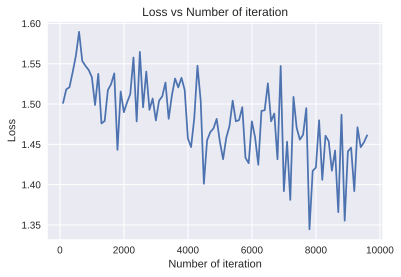

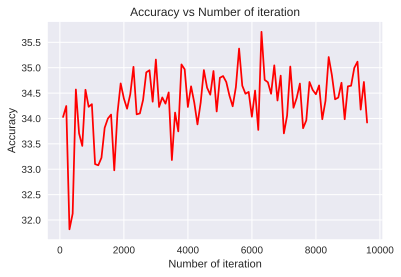

In [ ]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [ ]:
_ = load_checkpoint('./cnn_sp_best_checkpoint', model_sp, optimizer)

Loading checkpoint './cnn_sp_best_checkpoint'
Loaded checkpoint './cnn_sp_best_checkpoint' from iteration 6299


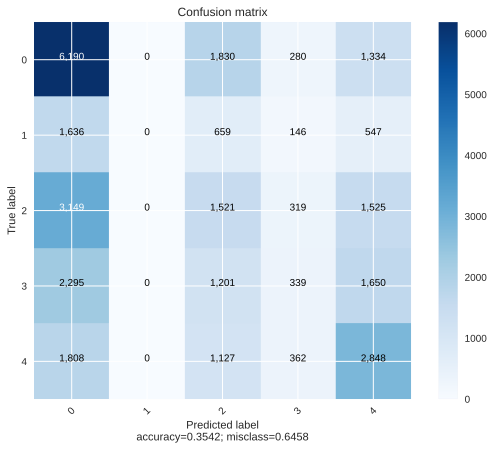

Accuracy: 0.35422 
Balanced accuracy: 0.28026 
Multiclass f1-score: 
    micro: 0.35422 
    macro: 0.24819 
    weighted: 0.30541


Classification report:

              precision    recall  f1-score   support

           0    0.41053   0.64252   0.50097      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.23998   0.23350   0.23669      6514
           3    0.23444   0.06180   0.09782      5485
           4    0.36032   0.46347   0.40544      6145

    accuracy                        0.35422     30766
   macro avg    0.24906   0.28026   0.24819     30766
weighted avg    0.29313   0.35422   0.30541     30766



In [ ]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_sp(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

### **AttentivePooling**

In [30]:
class AttentivePooling(nn.Module):
    def __init__(self, dim=-1, input_size=64, hidden_size=128):
        super(self.__class__, self).__init__()
        self.dim = dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.nn_attn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
    def forward(self, x):
        return (x * torch.transpose(self.nn_attn(torch.transpose(x, 2, 1)), 1, 2).softmax(dim=self.dim)).sum(dim=self.dim)
    

In [31]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size*2, kernel_size=2),
            nn.Tanh(),
            nn.Conv1d(hid_size*2, hid_size*2, kernel_size=3),
            nn.LeakyReLU(),
            nn.Conv1d(hid_size*2, hid_size, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),

            nn.Dropout(p=0.25),
            nn.LeakyReLU(),
            AttentivePooling()
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features = self.joke_encoder(joke_embeddings).squeeze()

        return self.final_predictor(joke_features).squeeze()

In [32]:
model_ap = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_ap.parameters(), lr=learning_rate)

In [33]:
iteration_list, loss_list, accuracy_list  = train(model_ap, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_ap_best_checkpoint",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5176382064819336  Accuracy: 33.966922760009766 %
Saving model and optimizer state at iteration 99 to ./cnn_ap_best_checkpoint
Iteration: 199  Loss: 1.5406218767166138  Accuracy: 34.59878158569336 %
Saving model and optimizer state at iteration 199 to ./cnn_ap_best_checkpoint
Iteration: 299  Loss: 1.5311819314956665  Accuracy: 34.229549407958984 %
Iteration: 399  Loss: 1.5725263357162476  Accuracy: 34.84580612182617 %
Saving model and optimizer state at iteration 399 to ./cnn_ap_best_checkpoint
Iteration: 499  Loss: 1.5327153205871582  Accuracy: 34.601383209228516 %
Iteration: 599  Loss: 1.4887943267822266  Accuracy: 34.87700653076172 %
Saving model and optimizer state at iteration 599 to ./cnn_ap_best_checkpoint
Iteration: 699  Loss: 1.547722578048706  Accuracy: 34.687191009521484 %
Iteration: 799  Loss: 1.4833853244781494  Accuracy: 34.9758186340332 %
Saving model and optimizer state at iteration 799 to ./cnn_ap_best_checkpoint
Iteration: 899  Loss: 1.5579096078

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5101948976516724  Accuracy: 34.564979553222656 %
Iteration: 1099  Loss: 1.5534613132476807  Accuracy: 35.07462692260742 %
Saving model and optimizer state at iteration 1099 to ./cnn_ap_best_checkpoint
Iteration: 1199  Loss: 1.549070119857788  Accuracy: 35.194236755371094 %
Saving model and optimizer state at iteration 1199 to ./cnn_ap_best_checkpoint
Iteration: 1299  Loss: 1.5306378602981567  Accuracy: 35.06162643432617 %
Iteration: 1399  Loss: 1.5364720821380615  Accuracy: 34.85100555419922 %
Iteration: 1499  Loss: 1.5106955766677856  Accuracy: 35.21503829956055 %
Saving model and optimizer state at iteration 1499 to ./cnn_ap_best_checkpoint
Iteration: 1599  Loss: 1.468506097793579  Accuracy: 33.79010772705078 %
Iteration: 1699  Loss: 1.5903021097183228  Accuracy: 35.43085861206055 %
Saving model and optimizer state at iteration 1699 to ./cnn_ap_best_checkpoint
Iteration: 1799  Loss: 1.5832972526550293  Accuracy: 34.687191009521484 %
Iteration: 1899  Loss: 1.57

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5138769149780273  Accuracy: 35.29304504394531 %
Iteration: 2099  Loss: 1.4689513444900513  Accuracy: 35.35805130004883 %
Iteration: 2199  Loss: 1.4684643745422363  Accuracy: 35.24624252319336 %
Iteration: 2299  Loss: 1.4843610525131226  Accuracy: 34.02933120727539 %
Iteration: 2399  Loss: 1.5419762134552002  Accuracy: 35.05642318725586 %
Iteration: 2499  Loss: 1.4585044384002686  Accuracy: 34.88220977783203 %
Iteration: 2599  Loss: 1.507144808769226  Accuracy: 35.34244918823242 %
Iteration: 2699  Loss: 1.4807075262069702  Accuracy: 35.67788314819336 %
Saving model and optimizer state at iteration 2699 to ./cnn_ap_best_checkpoint
Iteration: 2799  Loss: 1.4497236013412476  Accuracy: 34.36476135253906 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.4819717407226562  Accuracy: 35.095428466796875 %
Iteration: 2999  Loss: 1.5088213682174683  Accuracy: 35.6336784362793 %
Iteration: 3099  Loss: 1.4477568864822388  Accuracy: 35.32944869995117 %
Iteration: 3199  Loss: 1.4355719089508057  Accuracy: 35.298248291015625 %
Iteration: 3299  Loss: 1.5461527109146118  Accuracy: 34.3127555847168 %
Iteration: 3399  Loss: 1.5068597793579102  Accuracy: 35.503665924072266 %
Iteration: 3499  Loss: 1.5237071514129639  Accuracy: 35.118831634521484 %
Iteration: 3599  Loss: 1.489576816558838  Accuracy: 35.28524398803711 %
Iteration: 3699  Loss: 1.4903186559677124  Accuracy: 35.0018196105957 %
Iteration: 3799  Loss: 1.5186772346496582  Accuracy: 35.51926803588867 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.4920542240142822  Accuracy: 35.24884033203125 %
Iteration: 3999  Loss: 1.4955618381500244  Accuracy: 35.26704406738281 %
Iteration: 4099  Loss: 1.4817852973937988  Accuracy: 35.05122375488281 %
Iteration: 4199  Loss: 1.4415758848190308  Accuracy: 35.37625503540039 %
Iteration: 4299  Loss: 1.4920779466629028  Accuracy: 35.3918571472168 %
Iteration: 4399  Loss: 1.4003512859344482  Accuracy: 35.01222229003906 %
Iteration: 4499  Loss: 1.4781134128570557  Accuracy: 34.94461441040039 %
Iteration: 4599  Loss: 1.5204261541366577  Accuracy: 34.996620178222656 %
Iteration: 4699  Loss: 1.4787991046905518  Accuracy: 35.25404357910156 %
Iteration: 4799  Loss: 1.474204659461975  Accuracy: 35.20463943481445 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.4827420711517334  Accuracy: 34.9758186340332 %
Iteration: 4999  Loss: 1.4434984922409058  Accuracy: 33.631492614746094 %
Iteration: 5099  Loss: 1.4578981399536133  Accuracy: 35.4334602355957 %
Iteration: 5199  Loss: 1.485182762145996  Accuracy: 35.25924301147461 %
Iteration: 5299  Loss: 1.4842257499694824  Accuracy: 35.69868469238281 %
Saving model and optimizer state at iteration 5299 to ./cnn_ap_best_checkpoint
Iteration: 5399  Loss: 1.411446213722229  Accuracy: 35.51926803588867 %
Iteration: 5499  Loss: 1.5074800252914429  Accuracy: 35.05122375488281 %
Iteration: 5599  Loss: 1.4316997528076172  Accuracy: 35.40225601196289 %
Iteration: 5699  Loss: 1.4326499700546265  Accuracy: 35.0018196105957 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.4633606672286987  Accuracy: 34.51817321777344 %
Iteration: 5899  Loss: 1.4811007976531982  Accuracy: 35.350250244140625 %
Iteration: 5999  Loss: 1.4739346504211426  Accuracy: 35.16563415527344 %
Iteration: 6099  Loss: 1.4333347082138062  Accuracy: 35.251441955566406 %
Iteration: 6199  Loss: 1.4239200353622437  Accuracy: 35.38925552368164 %
Iteration: 6299  Loss: 1.4229401350021362  Accuracy: 34.90040969848633 %
Iteration: 6399  Loss: 1.3863507509231567  Accuracy: 34.94461441040039 %
Iteration: 6499  Loss: 1.4260075092315674  Accuracy: 34.905609130859375 %
Iteration: 6599  Loss: 1.4657458066940308  Accuracy: 35.55567169189453 %
Iteration: 6699  Loss: 1.4714796543121338  Accuracy: 35.072025299072266 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.4436991214752197  Accuracy: 35.719486236572266 %
Saving model and optimizer state at iteration 6799 to ./cnn_ap_best_checkpoint
Iteration: 6899  Loss: 1.4581727981567383  Accuracy: 34.93681335449219 %
Iteration: 6999  Loss: 1.4544364213943481  Accuracy: 34.7443962097168 %
Iteration: 7099  Loss: 1.4661844968795776  Accuracy: 35.31904983520508 %
Iteration: 7199  Loss: 1.4597821235656738  Accuracy: 35.65447998046875 %
Iteration: 7299  Loss: 1.3629908561706543  Accuracy: 35.8494987487793 %
Saving model and optimizer state at iteration 7299 to ./cnn_ap_best_checkpoint
Iteration: 7399  Loss: 1.4419915676116943  Accuracy: 35.046024322509766 %
Iteration: 7499  Loss: 1.3962123394012451  Accuracy: 35.35285186767578 %
Iteration: 7599  Loss: 1.4493658542633057  Accuracy: 35.16303253173828 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.3761149644851685  Accuracy: 35.493263244628906 %
Iteration: 7799  Loss: 1.4607985019683838  Accuracy: 35.12403106689453 %
Iteration: 7899  Loss: 1.4981985092163086  Accuracy: 34.939414978027344 %
Iteration: 7999  Loss: 1.4699169397354126  Accuracy: 35.26704406738281 %
Iteration: 8099  Loss: 1.4234790802001953  Accuracy: 34.5545768737793 %
Iteration: 8199  Loss: 1.4740818738937378  Accuracy: 35.373653411865234 %
Iteration: 8299  Loss: 1.3667304515838623  Accuracy: 34.87180709838867 %
Iteration: 8399  Loss: 1.4782005548477173  Accuracy: 35.45166015625 %
Iteration: 8499  Loss: 1.365179419517517  Accuracy: 35.194236755371094 %
Iteration: 8599  Loss: 1.3967567682266235  Accuracy: 35.2098388671875 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.4176019430160522  Accuracy: 35.25924301147461 %
Iteration: 8799  Loss: 1.472704291343689  Accuracy: 35.35285186767578 %
Iteration: 8899  Loss: 1.4293662309646606  Accuracy: 35.08762741088867 %
Iteration: 8999  Loss: 1.4432826042175293  Accuracy: 35.072025299072266 %
Iteration: 9099  Loss: 1.3300707340240479  Accuracy: 35.06162643432617 %
Iteration: 9199  Loss: 1.372087001800537  Accuracy: 35.10582733154297 %
Iteration: 9299  Loss: 1.4663482904434204  Accuracy: 35.298248291015625 %
Iteration: 9399  Loss: 1.3963394165039062  Accuracy: 34.63258361816406 %
Iteration: 9499  Loss: 1.4520419836044312  Accuracy: 34.57537841796875 %
Iteration: 9599  Loss: 1.3192167282104492  Accuracy: 34.73919677734375 %


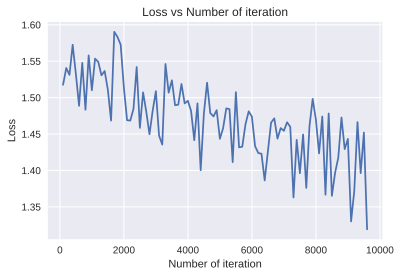

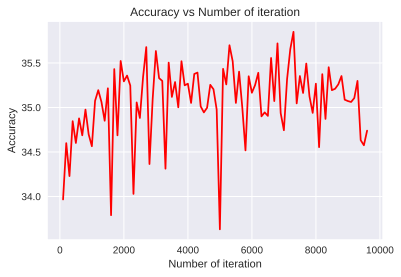

In [34]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [35]:
_ = load_checkpoint('./cnn_ap_best_checkpoint', model_ap, optimizer)

Loading checkpoint './cnn_ap_best_checkpoint'
Loaded checkpoint './cnn_ap_best_checkpoint' from iteration 7299


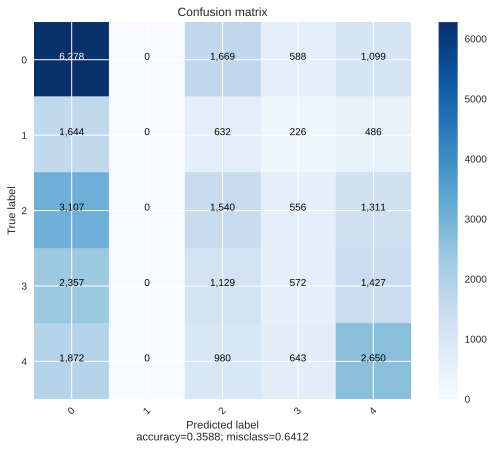

Accuracy: 0.35884 
Balanced accuracy: 0.28472 
Multiclass f1-score: 
    micro: 0.35884 
    macro: 0.25946 
    weighted: 0.31624


Classification report:

              precision    recall  f1-score   support

           0    0.41146   0.65165   0.50442      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.25882   0.23641   0.24711      6514
           3    0.22128   0.10428   0.14176      5485
           4    0.38004   0.43124   0.40403      6145

    accuracy                        0.35884     30766
   macro avg    0.25432   0.28472   0.25946     30766
weighted avg    0.29900   0.35884   0.31624     30766



In [36]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_ap(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

# **предобученные эмбеддинги**

In [37]:
import gensim.downloader as api

In [38]:
corpus_glove = api.load('glove-twitter-200')

[==================================================] 100.0% 758.5/758.5MB downloaded


In [39]:
len(corpus_glove.vocab)

1193514

In [40]:
def set_weights(corpus, dim):
    weights_matrix = np.zeros((len(tokens), dim))
    for i, word in enumerate(tokens):
        try:
            weights_matrix[i] = corpus.wv[word]
        except KeyError:
            weights_matrix[i] = np.random.normal(size=dim)
    weights_matrix = torch.FloatTensor(weights_matrix)

    return weights_matrix

In [41]:
weights_matrix = set_weights(corpus_glove, 200)

**Model**

In [52]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64, freezed=True):
        super().__init__()
        self.embedder = nn.Embedding.from_pretrained(weights_matrix, freeze=freezed)

        self.joke_encoder = nn.Sequential(
          nn.Conv1d(200, hid_size*2, kernel_size=2),
          nn.Tanh(),
          nn.Conv1d(hid_size*2, hid_size*2, kernel_size=3),
          nn.LeakyReLU(),
          nn.Conv1d(hid_size*2, hid_size, kernel_size=5),
          nn.LeakyReLU(),
          nn.MaxPool1d(2),

          nn.Dropout(p=0.25),
          nn.LeakyReLU(),
          AttentivePooling()
       )
      
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features = self.joke_encoder(joke_embeddings).squeeze()

        return self.final_predictor(joke_features).squeeze()

**Freeze**

In [53]:
model_glove_freeze = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_glove_freeze.parameters(), lr=learning_rate)

In [54]:
iteration_list, loss_list, accuracy_list  = train(model_glove_freeze, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./glove_freeze_best_checkpoint",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.566624402999878  Accuracy: 33.97212600708008 %
Saving model and optimizer state at iteration 99 to ./glove_freeze_best_checkpoint
Iteration: 199  Loss: 1.5113316774368286  Accuracy: 34.55978012084961 %
Saving model and optimizer state at iteration 199 to ./glove_freeze_best_checkpoint
Iteration: 299  Loss: 1.5970202684402466  Accuracy: 34.40636444091797 %
Iteration: 399  Loss: 1.5037038326263428  Accuracy: 34.69758987426758 %
Saving model and optimizer state at iteration 399 to ./glove_freeze_best_checkpoint
Iteration: 499  Loss: 1.5223289728164673  Accuracy: 31.83732795715332 %
Iteration: 599  Loss: 1.491044521331787  Accuracy: 35.085025787353516 %
Saving model and optimizer state at iteration 599 to ./glove_freeze_best_checkpoint
Iteration: 699  Loss: 1.5103638172149658  Accuracy: 34.52597427368164 %
Iteration: 799  Loss: 1.5754050016403198  Accuracy: 34.78860092163086 %
Iteration: 899  Loss: 1.5280295610427856  Accuracy: 34.9940185546875 %
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5479227304458618  Accuracy: 35.06162643432617 %
Iteration: 1099  Loss: 1.5768249034881592  Accuracy: 34.67938995361328 %
Iteration: 1199  Loss: 1.5017790794372559  Accuracy: 34.965415954589844 %
Iteration: 1299  Loss: 1.460054636001587  Accuracy: 35.32685089111328 %
Saving model and optimizer state at iteration 1299 to ./glove_freeze_best_checkpoint
Iteration: 1399  Loss: 1.5403918027877808  Accuracy: 34.830204010009766 %
Iteration: 1499  Loss: 1.5150959491729736  Accuracy: 35.2020378112793 %
Iteration: 1599  Loss: 1.474579095840454  Accuracy: 34.46617126464844 %
Iteration: 1699  Loss: 1.4720783233642578  Accuracy: 34.79899978637695 %
Iteration: 1799  Loss: 1.5219905376434326  Accuracy: 35.480262756347656 %
Saving model and optimizer state at iteration 1799 to ./glove_freeze_best_checkpoint
Iteration: 1899  Loss: 1.5116652250289917  Accuracy: 34.9940185546875 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5211166143417358  Accuracy: 34.3127555847168 %
Iteration: 2099  Loss: 1.5205886363983154  Accuracy: 35.12663269042969 %
Iteration: 2199  Loss: 1.5330911874771118  Accuracy: 35.1760368347168 %
Iteration: 2299  Loss: 1.4852403402328491  Accuracy: 35.298248291015625 %
Iteration: 2399  Loss: 1.4975436925888062  Accuracy: 35.15003204345703 %
Iteration: 2499  Loss: 1.5379548072814941  Accuracy: 35.831295013427734 %
Saving model and optimizer state at iteration 2499 to ./glove_freeze_best_checkpoint
Iteration: 2599  Loss: 1.50910222530365  Accuracy: 35.17343521118164 %
Iteration: 2699  Loss: 1.5463628768920898  Accuracy: 35.880699157714844 %
Saving model and optimizer state at iteration 2699 to ./glove_freeze_best_checkpoint
Iteration: 2799  Loss: 1.5269917249679565  Accuracy: 35.77669143676758 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5598596334457397  Accuracy: 35.46466064453125 %
Iteration: 2999  Loss: 1.4435229301452637  Accuracy: 34.49217224121094 %
Iteration: 3099  Loss: 1.5049574375152588  Accuracy: 35.18903732299805 %
Iteration: 3199  Loss: 1.5381180047988892  Accuracy: 35.65447998046875 %
Iteration: 3299  Loss: 1.5146780014038086  Accuracy: 35.386653900146484 %
Iteration: 3399  Loss: 1.4991164207458496  Accuracy: 35.35285186767578 %
Iteration: 3499  Loss: 1.4755779504776  Accuracy: 35.950904846191406 %
Saving model and optimizer state at iteration 3499 to ./glove_freeze_best_checkpoint
Iteration: 3599  Loss: 1.5059528350830078  Accuracy: 35.88330078125 %
Iteration: 3699  Loss: 1.5041600465774536  Accuracy: 33.41047286987305 %
Iteration: 3799  Loss: 1.4536311626434326  Accuracy: 35.85989761352539 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.471987247467041  Accuracy: 35.9093017578125 %
Iteration: 3999  Loss: 1.5297831296920776  Accuracy: 35.540069580078125 %
Iteration: 4099  Loss: 1.5151891708374023  Accuracy: 35.25404357910156 %
Iteration: 4199  Loss: 1.5025429725646973  Accuracy: 34.359561920166016 %
Iteration: 4299  Loss: 1.5454827547073364  Accuracy: 35.0018196105957 %
Iteration: 4399  Loss: 1.4529712200164795  Accuracy: 35.52186584472656 %
Iteration: 4499  Loss: 1.5512267351150513  Accuracy: 35.76108932495117 %
Iteration: 4599  Loss: 1.5441622734069824  Accuracy: 36.00031280517578 %
Saving model and optimizer state at iteration 4599 to ./glove_freeze_best_checkpoint
Iteration: 4699  Loss: 1.5343483686447144  Accuracy: 35.706485748291016 %
Iteration: 4799  Loss: 1.5610250234603882  Accuracy: 35.67267990112305 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.524448037147522  Accuracy: 36.18492889404297 %
Saving model and optimizer state at iteration 4899 to ./glove_freeze_best_checkpoint
Iteration: 4999  Loss: 1.4712120294570923  Accuracy: 34.320556640625 %
Iteration: 5099  Loss: 1.5504063367843628  Accuracy: 35.602474212646484 %
Iteration: 5199  Loss: 1.4943269491195679  Accuracy: 35.745487213134766 %
Iteration: 5299  Loss: 1.4943839311599731  Accuracy: 35.59467315673828 %
Iteration: 5399  Loss: 1.5024338960647583  Accuracy: 35.51406478881836 %
Iteration: 5499  Loss: 1.4536455869674683  Accuracy: 35.880699157714844 %
Iteration: 5599  Loss: 1.487975001335144  Accuracy: 35.360652923583984 %
Iteration: 5699  Loss: 1.4547111988067627  Accuracy: 35.8494987487793 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.4450762271881104  Accuracy: 35.722084045410156 %
Iteration: 5899  Loss: 1.5041075944900513  Accuracy: 35.984710693359375 %
Iteration: 5999  Loss: 1.468083143234253  Accuracy: 34.050132751464844 %
Iteration: 6099  Loss: 1.483048915863037  Accuracy: 36.04971694946289 %
Iteration: 6199  Loss: 1.4540646076202393  Accuracy: 36.06791687011719 %
Iteration: 6299  Loss: 1.458742618560791  Accuracy: 35.987308502197266 %
Iteration: 6399  Loss: 1.4788898229599  Accuracy: 36.239532470703125 %
Saving model and optimizer state at iteration 6399 to ./glove_freeze_best_checkpoint
Iteration: 6499  Loss: 1.503988265991211  Accuracy: 36.17972946166992 %
Iteration: 6599  Loss: 1.4389429092407227  Accuracy: 36.00551223754883 %
Iteration: 6699  Loss: 1.47529935836792  Accuracy: 36.083518981933594 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.492072582244873  Accuracy: 35.86249923706055 %
Iteration: 6899  Loss: 1.4260356426239014  Accuracy: 35.28004455566406 %
Iteration: 6999  Loss: 1.5212125778198242  Accuracy: 36.13812255859375 %
Iteration: 7099  Loss: 1.4963586330413818  Accuracy: 36.060115814208984 %
Iteration: 7199  Loss: 1.522740364074707  Accuracy: 35.732486724853516 %
Iteration: 7299  Loss: 1.5254697799682617  Accuracy: 35.86509704589844 %
Iteration: 7399  Loss: 1.458137035369873  Accuracy: 35.792293548583984 %
Iteration: 7499  Loss: 1.4691914319992065  Accuracy: 35.92230224609375 %
Iteration: 7599  Loss: 1.5418055057525635  Accuracy: 35.98210906982422 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.4659065008163452  Accuracy: 35.831295013427734 %
Iteration: 7799  Loss: 1.4893909692764282  Accuracy: 35.37625503540039 %
Iteration: 7899  Loss: 1.4785947799682617  Accuracy: 34.916011810302734 %
Iteration: 7999  Loss: 1.4697439670562744  Accuracy: 36.08871841430664 %
Iteration: 8099  Loss: 1.4826674461364746  Accuracy: 35.63627624511719 %
Iteration: 8199  Loss: 1.4632108211517334  Accuracy: 35.410057067871094 %
Iteration: 8299  Loss: 1.4908367395401  Accuracy: 35.23583984375 %
Iteration: 8399  Loss: 1.4768284559249878  Accuracy: 35.14743423461914 %
Iteration: 8499  Loss: 1.5485965013504028  Accuracy: 35.373653411865234 %
Iteration: 8599  Loss: 1.5604653358459473  Accuracy: 35.78709030151367 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.4760572910308838  Accuracy: 35.92750549316406 %
Iteration: 8799  Loss: 1.4905601739883423  Accuracy: 35.57387161254883 %
Iteration: 8899  Loss: 1.4857021570205688  Accuracy: 35.95350646972656 %
Iteration: 8999  Loss: 1.492114782333374  Accuracy: 35.76369094848633 %
Iteration: 9099  Loss: 1.4850114583969116  Accuracy: 35.47506332397461 %
Iteration: 9199  Loss: 1.4960813522338867  Accuracy: 36.478755950927734 %
Saving model and optimizer state at iteration 9199 to ./glove_freeze_best_checkpoint
Iteration: 9299  Loss: 1.4852123260498047  Accuracy: 35.95870590209961 %
Iteration: 9399  Loss: 1.4589570760726929  Accuracy: 35.854698181152344 %
Iteration: 9499  Loss: 1.4890979528427124  Accuracy: 35.63107681274414 %
Iteration: 9599  Loss: 1.4959396123886108  Accuracy: 35.51146697998047 %


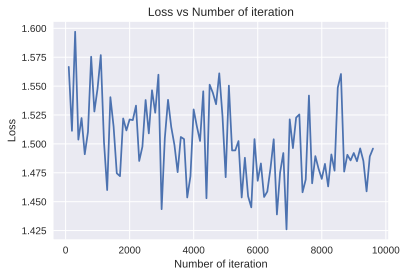

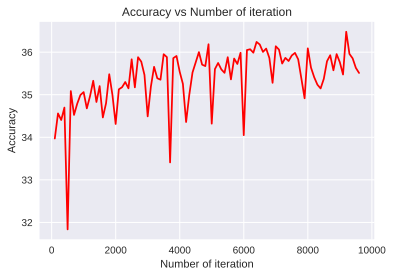

In [55]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [56]:
_ = load_checkpoint('./glove_freeze_best_checkpoint', model_glove_freeze, optimizer)

Loading checkpoint './glove_freeze_best_checkpoint'
Loaded checkpoint './glove_freeze_best_checkpoint' from iteration 9199


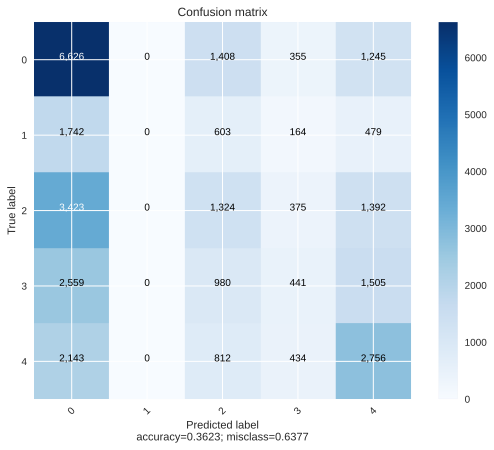

Accuracy: 0.36232 
Balanced accuracy: 0.28398 
Multiclass f1-score: 
    micro: 0.36232 
    macro: 0.25278 
    weighted: 0.31008


Classification report:

              precision    recall  f1-score   support

           0    0.40175   0.68777   0.50721      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.25824   0.20325   0.22747      6514
           3    0.24929   0.08040   0.12159      5485
           4    0.37359   0.44849   0.40763      6145

    accuracy                        0.36232     30766
   macro avg    0.25657   0.28398   0.25278     30766
weighted avg    0.29954   0.36232   0.31008     30766



In [57]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_glove_freeze(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

**Do not freeze**

In [58]:
model_glove_no_freeze = JokeRankPredictor(freezed=False).to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_glove_no_freeze.parameters(), lr=learning_rate)

In [59]:
iteration_list, loss_list, accuracy_list  = train(model_glove_no_freeze, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./glove_no_freeze_best_checkpoint",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5571212768554688  Accuracy: 34.089134216308594 %
Saving model and optimizer state at iteration 99 to ./glove_no_freeze_best_checkpoint
Iteration: 199  Loss: 1.5705902576446533  Accuracy: 34.892608642578125 %
Saving model and optimizer state at iteration 199 to ./glove_no_freeze_best_checkpoint
Iteration: 299  Loss: 1.5051687955856323  Accuracy: 34.46876907348633 %
Iteration: 399  Loss: 1.5735005140304565  Accuracy: 34.71579360961914 %
Iteration: 499  Loss: 1.5248198509216309  Accuracy: 35.09803009033203 %
Saving model and optimizer state at iteration 499 to ./glove_no_freeze_best_checkpoint
Iteration: 599  Loss: 1.5238065719604492  Accuracy: 34.052730560302734 %
Iteration: 699  Loss: 1.5356664657592773  Accuracy: 35.350250244140625 %
Saving model and optimizer state at iteration 699 to ./glove_no_freeze_best_checkpoint
Iteration: 799  Loss: 1.5567232370376587  Accuracy: 35.58167266845703 %
Saving model and optimizer state at iteration 799 to ./glove_no_freeze_bes

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5063302516937256  Accuracy: 35.56087112426758 %
Iteration: 1099  Loss: 1.45821213722229  Accuracy: 35.26964569091797 %
Iteration: 1199  Loss: 1.5011982917785645  Accuracy: 35.26704406738281 %
Iteration: 1299  Loss: 1.5490866899490356  Accuracy: 35.56867218017578 %
Iteration: 1399  Loss: 1.5478310585021973  Accuracy: 34.34135818481445 %
Iteration: 1499  Loss: 1.5014936923980713  Accuracy: 35.893699645996094 %
Saving model and optimizer state at iteration 1499 to ./glove_no_freeze_best_checkpoint
Iteration: 1599  Loss: 1.5300812721252441  Accuracy: 35.181236267089844 %
Iteration: 1699  Loss: 1.5493173599243164  Accuracy: 36.070518493652344 %
Saving model and optimizer state at iteration 1699 to ./glove_no_freeze_best_checkpoint
Iteration: 1799  Loss: 1.5455076694488525  Accuracy: 34.66898727416992 %
Iteration: 1899  Loss: 1.552040696144104  Accuracy: 35.4594612121582 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5274014472961426  Accuracy: 35.27224349975586 %
Iteration: 2099  Loss: 1.4614969491958618  Accuracy: 35.911903381347656 %
Iteration: 2199  Loss: 1.4707075357437134  Accuracy: 35.46206283569336 %
Iteration: 2299  Loss: 1.4798386096954346  Accuracy: 35.40745544433594 %
Iteration: 2399  Loss: 1.4992420673370361  Accuracy: 35.55046844482422 %
Iteration: 2499  Loss: 1.4733939170837402  Accuracy: 34.996620178222656 %
Iteration: 2599  Loss: 1.4855482578277588  Accuracy: 35.24884033203125 %
Iteration: 2699  Loss: 1.5028069019317627  Accuracy: 35.76628875732422 %
Iteration: 2799  Loss: 1.4980937242507935  Accuracy: 34.916011810302734 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.4915456771850586  Accuracy: 35.696083068847656 %
Iteration: 2999  Loss: 1.4406437873840332  Accuracy: 36.07571792602539 %
Saving model and optimizer state at iteration 2999 to ./glove_no_freeze_best_checkpoint
Iteration: 3099  Loss: 1.4004307985305786  Accuracy: 35.24884033203125 %
Iteration: 3199  Loss: 1.472793698310852  Accuracy: 34.42456817626953 %
Iteration: 3299  Loss: 1.4189597368240356  Accuracy: 35.311248779296875 %
Iteration: 3399  Loss: 1.4709059000015259  Accuracy: 35.05122375488281 %
Iteration: 3499  Loss: 1.469010591506958  Accuracy: 34.3465576171875 %
Iteration: 3599  Loss: 1.509458303451538  Accuracy: 35.477664947509766 %
Iteration: 3699  Loss: 1.5028706789016724  Accuracy: 34.278953552246094 %
Iteration: 3799  Loss: 1.4498757123947144  Accuracy: 35.55826950073242 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.455246925354004  Accuracy: 34.98881912231445 %
Iteration: 3999  Loss: 1.4759751558303833  Accuracy: 33.990325927734375 %
Iteration: 4099  Loss: 1.426157832145691  Accuracy: 34.42716598510742 %
Iteration: 4199  Loss: 1.4238009452819824  Accuracy: 35.181236267089844 %
Iteration: 4299  Loss: 1.3845033645629883  Accuracy: 35.68828201293945 %
Iteration: 4399  Loss: 1.4235066175460815  Accuracy: 34.26074981689453 %
Iteration: 4499  Loss: 1.4184883832931519  Accuracy: 35.56867218017578 %
Iteration: 4599  Loss: 1.3856278657913208  Accuracy: 35.74808883666992 %
Iteration: 4699  Loss: 1.454303503036499  Accuracy: 34.42976760864258 %
Iteration: 4799  Loss: 1.394455909729004  Accuracy: 36.0653190612793 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.3996145725250244  Accuracy: 34.726192474365234 %
Iteration: 4999  Loss: 1.4167662858963013  Accuracy: 34.94461441040039 %
Iteration: 5099  Loss: 1.4125655889511108  Accuracy: 35.56087112426758 %
Iteration: 5199  Loss: 1.4048635959625244  Accuracy: 35.6934814453125 %
Iteration: 5299  Loss: 1.4606564044952393  Accuracy: 35.893699645996094 %
Iteration: 5399  Loss: 1.4851676225662231  Accuracy: 36.36434555053711 %
Saving model and optimizer state at iteration 5399 to ./glove_no_freeze_best_checkpoint
Iteration: 5499  Loss: 1.3685098886489868  Accuracy: 35.441261291503906 %
Iteration: 5599  Loss: 1.386884093284607  Accuracy: 35.477664947509766 %
Iteration: 5699  Loss: 1.4036188125610352  Accuracy: 36.18752670288086 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.3544156551361084  Accuracy: 35.095428466796875 %
Iteration: 5899  Loss: 1.3602261543273926  Accuracy: 35.59987258911133 %
Iteration: 5999  Loss: 1.375837802886963  Accuracy: 34.942012786865234 %
Iteration: 6099  Loss: 1.3324183225631714  Accuracy: 35.77149200439453 %
Iteration: 6199  Loss: 1.4331204891204834  Accuracy: 35.397056579589844 %
Iteration: 6299  Loss: 1.4391851425170898  Accuracy: 35.893699645996094 %
Iteration: 6399  Loss: 1.48690664768219  Accuracy: 35.313846588134766 %
Iteration: 6499  Loss: 1.3670326471328735  Accuracy: 35.46986389160156 %
Iteration: 6599  Loss: 1.4206562042236328  Accuracy: 35.23583984375 %
Iteration: 6699  Loss: 1.4010016918182373  Accuracy: 35.61807632446289 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.38600492477417  Accuracy: 35.722084045410156 %
Iteration: 6899  Loss: 1.4534523487091064  Accuracy: 35.25404357910156 %
Iteration: 6999  Loss: 1.4366694688796997  Accuracy: 35.62067794799805 %
Iteration: 7099  Loss: 1.3695980310440063  Accuracy: 35.47246170043945 %
Iteration: 7199  Loss: 1.3371652364730835  Accuracy: 35.64407730102539 %
Iteration: 7299  Loss: 1.4227217435836792  Accuracy: 35.313846588134766 %
Iteration: 7399  Loss: 1.4033337831497192  Accuracy: 35.54787063598633 %
Iteration: 7499  Loss: 1.3496983051300049  Accuracy: 35.477664947509766 %
Iteration: 7599  Loss: 1.4390745162963867  Accuracy: 34.736595153808594 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.4179706573486328  Accuracy: 35.4334602355957 %
Iteration: 7799  Loss: 1.3797438144683838  Accuracy: 35.04342269897461 %
Iteration: 7899  Loss: 1.3106772899627686  Accuracy: 34.762596130371094 %
Iteration: 7999  Loss: 1.368323564529419  Accuracy: 34.749595642089844 %
Iteration: 8099  Loss: 1.3295648097991943  Accuracy: 34.929012298583984 %
Iteration: 8199  Loss: 1.4053295850753784  Accuracy: 35.022621154785156 %
Iteration: 8299  Loss: 1.4109781980514526  Accuracy: 35.23324203491211 %
Iteration: 8399  Loss: 1.3706518411636353  Accuracy: 35.2020378112793 %
Iteration: 8499  Loss: 1.4169762134552002  Accuracy: 35.09282684326172 %
Iteration: 8599  Loss: 1.3643321990966797  Accuracy: 35.683082580566406 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.360409140586853  Accuracy: 35.34244918823242 %
Iteration: 8799  Loss: 1.3625800609588623  Accuracy: 35.212440490722656 %
Iteration: 8899  Loss: 1.2950921058654785  Accuracy: 35.745487213134766 %
Iteration: 8999  Loss: 1.2933961153030396  Accuracy: 34.5025749206543 %
Iteration: 9099  Loss: 1.3935837745666504  Accuracy: 35.046024322509766 %
Iteration: 9199  Loss: 1.340001106262207  Accuracy: 34.61958312988281 %
Iteration: 9299  Loss: 1.3673197031021118  Accuracy: 35.39445495605469 %
Iteration: 9399  Loss: 1.3908013105392456  Accuracy: 35.2098388671875 %
Iteration: 9499  Loss: 1.41656494140625  Accuracy: 35.12663269042969 %
Iteration: 9599  Loss: 1.4258315563201904  Accuracy: 35.207237243652344 %


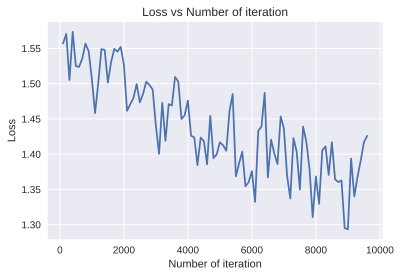

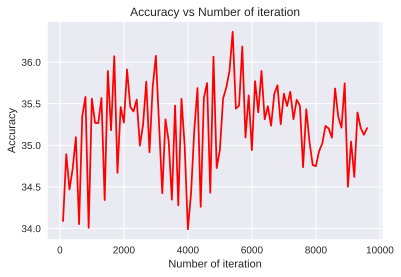

In [60]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [61]:
_ = load_checkpoint('./glove_no_freeze_best_checkpoint', model_glove_no_freeze, optimizer)

Loading checkpoint './glove_no_freeze_best_checkpoint'
Loaded checkpoint './glove_no_freeze_best_checkpoint' from iteration 5399


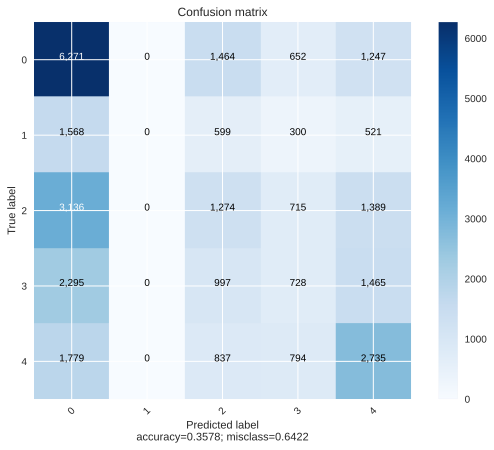

Accuracy: 0.3578 
Balanced accuracy: 0.28486 
Multiclass f1-score: 
    micro: 0.3578 
    macro: 0.25983 
    weighted: 0.31612


Classification report:

              precision    recall  f1-score   support

           0    0.41671   0.65092   0.50812      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.24637   0.19558   0.21806      6514
           3    0.22828   0.13273   0.16786      5485
           4    0.37175   0.44508   0.40513      6145

    accuracy                        0.35780     30766
   macro avg    0.25262   0.28486   0.25983     30766
weighted avg    0.29760   0.35780   0.31612     30766



In [62]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_glove_no_freeze(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

### **Glove+BiLSTM _ freeze**

In [93]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8, freezed=True):
        super().__init__()
        self.embedder = nn.Embedding.from_pretrained(weights_matrix, freeze=freezed)

        self.joke_lstm = nn.LSTM(
                                200,
                                hid_size, 
                                # num_layers=2,
                                dropout=0.5,
                                bidirectional=True,
                                batch_first=True)
        
        self.dr1 = nn.Dropout(p=0.25)
        self.af1 = nn.Tanh()
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size*2, 50),
            nn.BatchNorm1d(50),
            nn.ELU(),
            nn.Linear(50, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke'])
        output, (h_n_joke, c_n_joke) = self.joke_lstm(joke_embeddings)     
        h_n_joke = torch.cat([h_n_joke[i,:, :] for i in range(h_n_joke.shape[0])], dim=1)
        
        out_joke = self.dr1(h_n_joke)
        out_joke = self.af1(out_joke)
        return self.final_predictor(out_joke).squeeze()

In [92]:
# import gc

# gc.collect()

# torch.cuda.empty_cache()

In [94]:
model_lstm_glove_freeze = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm_glove_freeze.parameters(), lr=learning_rate)


In [95]:
iteration_list, loss_list, accuracy_list  = train(model_lstm_glove_freeze, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./glove_lstm_freeze_best_checkpoint",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5918790102005005  Accuracy: 30.074365615844727 %
Saving model and optimizer state at iteration 99 to ./glove_lstm_freeze_best_checkpoint
Iteration: 199  Loss: 1.59418785572052  Accuracy: 32.92942810058594 %
Saving model and optimizer state at iteration 199 to ./glove_lstm_freeze_best_checkpoint
Iteration: 299  Loss: 1.5506502389907837  Accuracy: 33.09064483642578 %
Saving model and optimizer state at iteration 299 to ./glove_lstm_freeze_best_checkpoint
Iteration: 399  Loss: 1.5700058937072754  Accuracy: 33.4650764465332 %
Saving model and optimizer state at iteration 399 to ./glove_lstm_freeze_best_checkpoint
Iteration: 499  Loss: 1.5323655605316162  Accuracy: 34.1385383605957 %
Saving model and optimizer state at iteration 499 to ./glove_lstm_freeze_best_checkpoint
Iteration: 599  Loss: 1.5039117336273193  Accuracy: 34.278953552246094 %
Saving model and optimizer state at iteration 599 to ./glove_lstm_freeze_best_checkpoint
Iteration: 699  Loss: 1.58110618591308

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5414255857467651  Accuracy: 35.05642318725586 %
Saving model and optimizer state at iteration 999 to ./glove_lstm_freeze_best_checkpoint
Iteration: 1099  Loss: 1.521968126296997  Accuracy: 35.16303253173828 %
Saving model and optimizer state at iteration 1099 to ./glove_lstm_freeze_best_checkpoint
Iteration: 1199  Loss: 1.553098201751709  Accuracy: 35.2176399230957 %
Saving model and optimizer state at iteration 1199 to ./glove_lstm_freeze_best_checkpoint
Iteration: 1299  Loss: 1.5156009197235107  Accuracy: 35.33205032348633 %
Saving model and optimizer state at iteration 1299 to ./glove_lstm_freeze_best_checkpoint
Iteration: 1399  Loss: 1.5441999435424805  Accuracy: 35.30604553222656 %
Iteration: 1499  Loss: 1.5105260610580444  Accuracy: 35.311248779296875 %
Iteration: 1599  Loss: 1.5314600467681885  Accuracy: 35.324249267578125 %
Iteration: 1699  Loss: 1.5607764720916748  Accuracy: 35.25664138793945 %
Iteration: 1799  Loss: 1.572183609008789  Accuracy: 35.4802

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5163872241973877  Accuracy: 35.563472747802734 %
Saving model and optimizer state at iteration 1999 to ./glove_lstm_freeze_best_checkpoint
Iteration: 2099  Loss: 1.503881812095642  Accuracy: 35.63107681274414 %
Saving model and optimizer state at iteration 2099 to ./glove_lstm_freeze_best_checkpoint
Iteration: 2199  Loss: 1.5366848707199097  Accuracy: 35.589473724365234 %
Iteration: 2299  Loss: 1.5656598806381226  Accuracy: 35.480262756347656 %
Iteration: 2399  Loss: 1.539075493812561  Accuracy: 35.33205032348633 %
Iteration: 2499  Loss: 1.5530890226364136  Accuracy: 35.503665924072266 %
Iteration: 2599  Loss: 1.4913737773895264  Accuracy: 35.57126998901367 %
Iteration: 2699  Loss: 1.5358166694641113  Accuracy: 35.72468566894531 %
Saving model and optimizer state at iteration 2699 to ./glove_lstm_freeze_best_checkpoint
Iteration: 2799  Loss: 1.5127543210983276  Accuracy: 35.77928924560547 %
Saving model and optimizer state at iteration 2799 to ./glove_lstm_free

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5739972591400146  Accuracy: 35.81049346923828 %
Saving model and optimizer state at iteration 2899 to ./glove_lstm_freeze_best_checkpoint
Iteration: 2999  Loss: 1.552858829498291  Accuracy: 35.54526901245117 %
Iteration: 3099  Loss: 1.466065526008606  Accuracy: 35.612876892089844 %
Iteration: 3199  Loss: 1.4940096139907837  Accuracy: 35.529666900634766 %
Iteration: 3299  Loss: 1.5326019525527954  Accuracy: 35.670082092285156 %
Iteration: 3399  Loss: 1.5414825677871704  Accuracy: 35.745487213134766 %
Iteration: 3499  Loss: 1.4669408798217773  Accuracy: 35.60507583618164 %
Iteration: 3599  Loss: 1.4838188886642456  Accuracy: 35.745487213134766 %
Iteration: 3699  Loss: 1.5497667789459229  Accuracy: 35.6934814453125 %
Iteration: 3799  Loss: 1.51555597782135  Accuracy: 35.732486724853516 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.5576703548431396  Accuracy: 35.81049346923828 %
Iteration: 3999  Loss: 1.481441617012024  Accuracy: 35.83389663696289 %
Saving model and optimizer state at iteration 3999 to ./glove_lstm_freeze_best_checkpoint
Iteration: 4099  Loss: 1.466092824935913  Accuracy: 35.792293548583984 %
Iteration: 4199  Loss: 1.5534428358078003  Accuracy: 35.95610809326172 %
Saving model and optimizer state at iteration 4199 to ./glove_lstm_freeze_best_checkpoint
Iteration: 4299  Loss: 1.517002820968628  Accuracy: 36.13812255859375 %
Saving model and optimizer state at iteration 4299 to ./glove_lstm_freeze_best_checkpoint
Iteration: 4399  Loss: 1.5149459838867188  Accuracy: 36.13812255859375 %
Iteration: 4499  Loss: 1.4734599590301514  Accuracy: 35.92750549316406 %
Iteration: 4599  Loss: 1.5368947982788086  Accuracy: 36.114723205566406 %
Iteration: 4699  Loss: 1.5737199783325195  Accuracy: 35.974308013916016 %
Iteration: 4799  Loss: 1.5168554782867432  Accuracy: 35.83909606933594 %


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.5485090017318726  Accuracy: 36.073116302490234 %
Iteration: 4999  Loss: 1.531943917274475  Accuracy: 36.140724182128906 %
Saving model and optimizer state at iteration 4999 to ./glove_lstm_freeze_best_checkpoint
Iteration: 5099  Loss: 1.5019859075546265  Accuracy: 36.19272994995117 %
Saving model and optimizer state at iteration 5099 to ./glove_lstm_freeze_best_checkpoint
Iteration: 5199  Loss: 1.5509191751480103  Accuracy: 35.96650695800781 %
Iteration: 5299  Loss: 1.4688979387283325  Accuracy: 36.153724670410156 %
Iteration: 5399  Loss: 1.5049554109573364  Accuracy: 35.97690963745117 %
Iteration: 5499  Loss: 1.561724305152893  Accuracy: 35.99251174926758 %
Iteration: 5599  Loss: 1.4603633880615234  Accuracy: 36.22133255004883 %
Saving model and optimizer state at iteration 5599 to ./glove_lstm_freeze_best_checkpoint
Iteration: 5699  Loss: 1.506454348564148  Accuracy: 36.27333450317383 %
Saving model and optimizer state at iteration 5699 to ./glove_lstm_freeze

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.5090575218200684  Accuracy: 36.151126861572266 %
Iteration: 5899  Loss: 1.5145034790039062  Accuracy: 36.151126861572266 %
Iteration: 5999  Loss: 1.5230486392974854  Accuracy: 36.164127349853516 %
Iteration: 6099  Loss: 1.5294315814971924  Accuracy: 35.78449249267578 %
Iteration: 6199  Loss: 1.4785020351409912  Accuracy: 36.166725158691406 %
Iteration: 6299  Loss: 1.5067415237426758  Accuracy: 36.08091735839844 %
Iteration: 6399  Loss: 1.5471240282058716  Accuracy: 36.31753921508789 %
Saving model and optimizer state at iteration 6399 to ./glove_lstm_freeze_best_checkpoint
Iteration: 6499  Loss: 1.544776439666748  Accuracy: 36.275936126708984 %
Iteration: 6599  Loss: 1.4911946058273315  Accuracy: 36.07831954956055 %
Iteration: 6699  Loss: 1.5405843257904053  Accuracy: 36.31494140625 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.4871039390563965  Accuracy: 36.18232727050781 %
Iteration: 6899  Loss: 1.5289117097854614  Accuracy: 36.200531005859375 %
Iteration: 6999  Loss: 1.4906988143920898  Accuracy: 36.21873092651367 %
Iteration: 7099  Loss: 1.5342168807983398  Accuracy: 36.3331413269043 %
Saving model and optimizer state at iteration 7099 to ./glove_lstm_freeze_best_checkpoint
Iteration: 7199  Loss: 1.4688457250595093  Accuracy: 36.17452621459961 %
Iteration: 7299  Loss: 1.5541683435440063  Accuracy: 36.114723205566406 %
Iteration: 7399  Loss: 1.5248305797576904  Accuracy: 36.151126861572266 %
Iteration: 7499  Loss: 1.5395092964172363  Accuracy: 36.164127349853516 %
Iteration: 7599  Loss: 1.537984848022461  Accuracy: 36.083518981933594 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.5160635709762573  Accuracy: 36.18492889404297 %
Iteration: 7799  Loss: 1.450885534286499  Accuracy: 36.382545471191406 %
Saving model and optimizer state at iteration 7799 to ./glove_lstm_freeze_best_checkpoint
Iteration: 7899  Loss: 1.5288084745407104  Accuracy: 36.04971694946289 %
Iteration: 7999  Loss: 1.5406063795089722  Accuracy: 36.057518005371094 %
Iteration: 8099  Loss: 1.4932656288146973  Accuracy: 36.239532470703125 %
Iteration: 8199  Loss: 1.4595348834991455  Accuracy: 36.442352294921875 %
Saving model and optimizer state at iteration 8199 to ./glove_lstm_freeze_best_checkpoint
Iteration: 8299  Loss: 1.496640682220459  Accuracy: 36.13552474975586 %
Iteration: 8399  Loss: 1.5244368314743042  Accuracy: 36.10171890258789 %
Iteration: 8499  Loss: 1.483380675315857  Accuracy: 36.431949615478516 %
Iteration: 8599  Loss: 1.5152537822723389  Accuracy: 36.26553726196289 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.4744586944580078  Accuracy: 35.95870590209961 %
Iteration: 8799  Loss: 1.5139923095703125  Accuracy: 36.379947662353516 %
Iteration: 8899  Loss: 1.4931421279907227  Accuracy: 36.153724670410156 %
Iteration: 8999  Loss: 1.539324402809143  Accuracy: 36.140724182128906 %
Iteration: 9099  Loss: 1.533010482788086  Accuracy: 36.34614181518555 %
Iteration: 9199  Loss: 1.5098228454589844  Accuracy: 36.13552474975586 %
Iteration: 9299  Loss: 1.5768266916275024  Accuracy: 36.3487434387207 %
Iteration: 9399  Loss: 1.4987298250198364  Accuracy: 36.330543518066406 %
Iteration: 9499  Loss: 1.4767526388168335  Accuracy: 36.31494140625 %
Iteration: 9599  Loss: 1.5401701927185059  Accuracy: 36.44755172729492 %
Saving model and optimizer state at iteration 9599 to ./glove_lstm_freeze_best_checkpoint


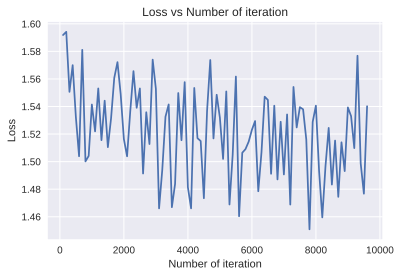

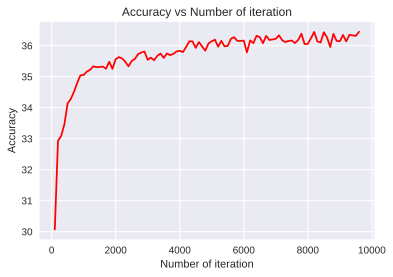

In [96]:
draw_visualization(iteration_list, loss_list, accuracy_list)

In [97]:
_ = load_checkpoint('./glove_lstm_freeze_best_checkpoint', model_lstm_glove_freeze, optimizer)

Loading checkpoint './glove_lstm_freeze_best_checkpoint'
Loaded checkpoint './glove_lstm_freeze_best_checkpoint' from iteration 9599


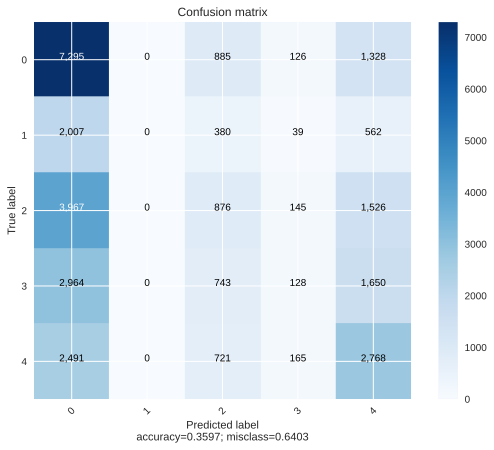

Accuracy: 0.35972 
Balanced accuracy: 0.2731 
Multiclass f1-score: 
    micro: 0.35972 
    macro: 0.22514 
    weighted: 0.28436


Classification report:

              precision    recall  f1-score   support

           0    0.38961   0.75721   0.51449      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.24300   0.13448   0.17314      6514
           3    0.21227   0.02334   0.04205      5485
           4    0.35333   0.45045   0.39602      6145

    accuracy                        0.35972     30766
   macro avg    0.23964   0.27310   0.22514     30766
weighted avg    0.28187   0.35972   0.28436     30766



In [98]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_lstm_glove_freeze(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

# **Special CNN model**

In [64]:
class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [65]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=256):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, 128, kernel_size=3),
            nn.Sigmoid(),
            GlobalMaxPooling(),
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(128, 50),
            nn.Dropout(p=0.5),
            nn.Sigmoid(),
            # nn.BatchNorm1d(hid_size),
            nn.Linear(50, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features = self.joke_encoder(joke_embeddings).squeeze()

        return self.final_predictor(joke_features).squeeze()

In [66]:
model_cnn = JokeRankPredictor().to(DEVICE)
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)

In [67]:
iteration_list, loss_list, accuracy_list  = train(model_cnn, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_best_checkpoint",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5931079387664795  Accuracy: 31.473295211791992 %
Saving model and optimizer state at iteration 99 to ./cnn_best_checkpoint
Iteration: 199  Loss: 1.5662444829940796  Accuracy: 31.473295211791992 %
Iteration: 299  Loss: 1.54868745803833  Accuracy: 31.473295211791992 %
Iteration: 399  Loss: 1.5306085348129272  Accuracy: 31.473295211791992 %
Iteration: 499  Loss: 1.550767421722412  Accuracy: 31.473295211791992 %
Iteration: 599  Loss: 1.5639702081680298  Accuracy: 31.473295211791992 %
Iteration: 699  Loss: 1.6011583805084229  Accuracy: 34.536376953125 %
Saving model and optimizer state at iteration 699 to ./cnn_best_checkpoint
Iteration: 799  Loss: 1.558751106262207  Accuracy: 35.02522277832031 %
Saving model and optimizer state at iteration 799 to ./cnn_best_checkpoint
Iteration: 899  Loss: 1.5392634868621826  Accuracy: 34.91341018676758 %
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.531730055809021  Accuracy: 35.264442443847656 %
Saving model and optimizer state at iteration 999 to ./cnn_best_checkpoint
Iteration: 1099  Loss: 1.5425963401794434  Accuracy: 35.35545349121094 %
Saving model and optimizer state at iteration 1099 to ./cnn_best_checkpoint
Iteration: 1199  Loss: 1.478028416633606  Accuracy: 35.77149200439453 %
Saving model and optimizer state at iteration 1199 to ./cnn_best_checkpoint
Iteration: 1299  Loss: 1.539847493171692  Accuracy: 35.91450500488281 %
Saving model and optimizer state at iteration 1299 to ./cnn_best_checkpoint
Iteration: 1399  Loss: 1.5555378198623657  Accuracy: 35.602474212646484 %
Iteration: 1499  Loss: 1.550280213356018  Accuracy: 35.58427429199219 %
Iteration: 1599  Loss: 1.5428333282470703  Accuracy: 35.99510955810547 %
Saving model and optimizer state at iteration 1599 to ./cnn_best_checkpoint
Iteration: 1699  Loss: 1.5491406917572021  Accuracy: 36.16932678222656 %
Saving model and optimizer state at iter

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5034064054489136  Accuracy: 36.30194091796875 %
Saving model and optimizer state at iteration 1999 to ./cnn_best_checkpoint
Iteration: 2099  Loss: 1.4974550008773804  Accuracy: 36.03151321411133 %
Iteration: 2199  Loss: 1.5548313856124878  Accuracy: 36.35394287109375 %
Saving model and optimizer state at iteration 2199 to ./cnn_best_checkpoint
Iteration: 2299  Loss: 1.4553827047348022  Accuracy: 36.25773620605469 %
Iteration: 2399  Loss: 1.4894695281982422  Accuracy: 36.45015335083008 %
Saving model and optimizer state at iteration 2399 to ./cnn_best_checkpoint
Iteration: 2499  Loss: 1.5183112621307373  Accuracy: 36.35914611816406 %
Iteration: 2599  Loss: 1.4561505317687988  Accuracy: 36.38514709472656 %
Iteration: 2699  Loss: 1.5184849500656128  Accuracy: 36.43455123901367 %
Iteration: 2799  Loss: 1.4401813745498657  Accuracy: 36.109519958496094 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.4684772491455078  Accuracy: 36.31753921508789 %
Iteration: 2999  Loss: 1.4803365468978882  Accuracy: 36.36174392700195 %
Iteration: 3099  Loss: 1.421736717224121  Accuracy: 36.127723693847656 %
Iteration: 3199  Loss: 1.5055381059646606  Accuracy: 35.94310760498047 %
Iteration: 3299  Loss: 1.4445997476577759  Accuracy: 36.010711669921875 %
Iteration: 3399  Loss: 1.4872568845748901  Accuracy: 36.28373718261719 %
Iteration: 3499  Loss: 1.5108178853988647  Accuracy: 36.03151321411133 %
Iteration: 3599  Loss: 1.4253733158111572  Accuracy: 35.589473724365234 %
Iteration: 3699  Loss: 1.485576868057251  Accuracy: 35.615474700927734 %
Iteration: 3799  Loss: 1.4658734798431396  Accuracy: 35.72988510131836 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.4376587867736816  Accuracy: 35.4178581237793 %
Iteration: 3999  Loss: 1.4619451761245728  Accuracy: 35.73768615722656 %
Iteration: 4099  Loss: 1.4330081939697266  Accuracy: 35.98210906982422 %
Iteration: 4199  Loss: 1.411369800567627  Accuracy: 35.997711181640625 %
Iteration: 4299  Loss: 1.4891259670257568  Accuracy: 36.03151321411133 %
Iteration: 4399  Loss: 1.3982480764389038  Accuracy: 35.79749298095703 %
Iteration: 4499  Loss: 1.4029030799865723  Accuracy: 36.13812255859375 %
Iteration: 4599  Loss: 1.4809561967849731  Accuracy: 36.02631378173828 %
Iteration: 4699  Loss: 1.422595739364624  Accuracy: 35.542667388916016 %
Iteration: 4799  Loss: 1.3992661237716675  Accuracy: 35.950904846191406 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.4119834899902344  Accuracy: 35.76369094848633 %
Iteration: 4999  Loss: 1.4232395887374878  Accuracy: 35.638877868652344 %
Iteration: 5099  Loss: 1.4176346063613892  Accuracy: 35.76369094848633 %
Iteration: 5199  Loss: 1.3733363151550293  Accuracy: 35.47246170043945 %
Iteration: 5299  Loss: 1.375136375427246  Accuracy: 35.83389663696289 %
Iteration: 5399  Loss: 1.3908740282058716  Accuracy: 35.81309509277344 %
Iteration: 5499  Loss: 1.48729407787323  Accuracy: 35.493263244628906 %
Iteration: 5599  Loss: 1.4384719133377075  Accuracy: 35.54526901245117 %
Iteration: 5699  Loss: 1.3998390436172485  Accuracy: 35.828697204589844 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.3914954662322998  Accuracy: 35.30864715576172 %
Iteration: 5899  Loss: 1.3623549938201904  Accuracy: 35.14743423461914 %
Iteration: 5999  Loss: 1.4133356809616089  Accuracy: 35.576473236083984 %
Iteration: 6099  Loss: 1.3826713562011719  Accuracy: 35.51406478881836 %
Iteration: 6199  Loss: 1.4012401103973389  Accuracy: 35.57126998901367 %
Iteration: 6299  Loss: 1.4114488363265991  Accuracy: 35.30864715576172 %
Iteration: 6399  Loss: 1.3791193962097168  Accuracy: 35.893699645996094 %
Iteration: 6499  Loss: 1.3862695693969727  Accuracy: 35.42045974731445 %
Iteration: 6599  Loss: 1.4386377334594727  Accuracy: 35.33985137939453 %
Iteration: 6699  Loss: 1.3863451480865479  Accuracy: 35.43865966796875 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.2762004137039185  Accuracy: 35.13963317871094 %
Iteration: 6899  Loss: 1.373659372329712  Accuracy: 34.9940185546875 %
Iteration: 6999  Loss: 1.393957495689392  Accuracy: 35.18903732299805 %
Iteration: 7099  Loss: 1.455100417137146  Accuracy: 35.37625503540039 %
Iteration: 7199  Loss: 1.3971689939498901  Accuracy: 34.84840393066406 %
Iteration: 7299  Loss: 1.43183171749115  Accuracy: 35.11362838745117 %
Iteration: 7399  Loss: 1.4029096364974976  Accuracy: 35.20463943481445 %
Iteration: 7499  Loss: 1.3126933574676514  Accuracy: 34.9940185546875 %
Iteration: 7599  Loss: 1.3046575784683228  Accuracy: 35.33205032348633 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.3185733556747437  Accuracy: 35.36585235595703 %
Iteration: 7799  Loss: 1.376457929611206  Accuracy: 35.059024810791016 %
Iteration: 7899  Loss: 1.38864004611969  Accuracy: 35.10322952270508 %
Iteration: 7999  Loss: 1.319380521774292  Accuracy: 34.73399353027344 %
Iteration: 8099  Loss: 1.3785719871520996  Accuracy: 34.86400604248047 %
Iteration: 8199  Loss: 1.4012095928192139  Accuracy: 35.18643569946289 %
Iteration: 8299  Loss: 1.374692440032959  Accuracy: 35.072025299072266 %
Iteration: 8399  Loss: 1.3435232639312744  Accuracy: 34.84840393066406 %
Iteration: 8499  Loss: 1.3498109579086304  Accuracy: 35.313846588134766 %
Iteration: 8599  Loss: 1.3808757066726685  Accuracy: 35.06162643432617 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.355991005897522  Accuracy: 34.92121124267578 %
Iteration: 8799  Loss: 1.3612867593765259  Accuracy: 34.87180709838867 %
Iteration: 8899  Loss: 1.405993938446045  Accuracy: 34.939414978027344 %
Iteration: 8999  Loss: 1.3402504920959473  Accuracy: 34.546775817871094 %
Iteration: 9099  Loss: 1.36520516872406  Accuracy: 34.68199157714844 %
Iteration: 9199  Loss: 1.3111999034881592  Accuracy: 34.726192474365234 %
Iteration: 9299  Loss: 1.3298531770706177  Accuracy: 34.73919677734375 %
Iteration: 9399  Loss: 1.3341617584228516  Accuracy: 34.49217224121094 %
Iteration: 9499  Loss: 1.338794231414795  Accuracy: 34.780799865722656 %
Iteration: 9599  Loss: 1.3744778633117676  Accuracy: 34.91341018676758 %


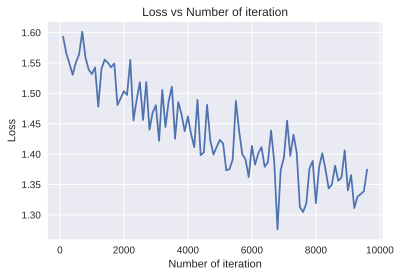

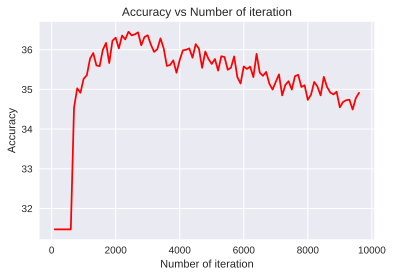

In [68]:
draw_visualization(iteration_list, loss_list, accuracy_list)